# NLP Challenge

Similar to the analysis done in the **Eluvio_NLP** notebook but the pre-processing here is now done with spark. After the pre-processing, only the topic modeling is repeated here.

## Libraries and data imports

In [1]:
# import key libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
#import nltk
from nltk.corpus import wordnet,stopwords
#from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
#from textblob import TextBlob
#import gensim
import re
import string

In [2]:
from pyspark.sql import SparkSession
#from pyspark.sql.types import StructType, StructField, IntegerType, LongType
from pyspark.sql.types import *
from pyspark.sql import functions as F
#from pyspark.sql.functions import udf
import sparknlp
#spark= sparknlp.start()

from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline

# from pyspark.ml.feature import CountVectorizer
# from pyspark.ml.feature import IDF
# from pyspark.ml.clustering import LDA

In [3]:
spark = SparkSession.builder \
    .appName("exploratory_nlp") \
    .master("local[*]") \
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:3.0.1") \
    .getOrCreate()

In [4]:
Schema = StructType([ \
                     StructField("time_created", DateType(), True), \
                     StructField("date_created", DateType(), True), \
                     StructField("up_votes", IntegerType(), True), \
                     StructField("down_votes", IntegerType(), True),
                     StructField("title", StringType(), True), \
                     StructField("over_18", BooleanType(), True), \
                     StructField("author", StringType(), True), \
                     StructField("category", StringType(), True)])

In [5]:
df_spark = spark.read \
      .option("header", True) \
      .schema(Schema) \
      .csv("Eluvio_DS_Challenge.csv")

In [6]:
main_text = df_spark.select('title', 'date_created', 'author', 'up_votes')
text_col = "title"

In [7]:
main_text.limit(5).show(truncate = 50)

+-----------------------------------------------+------------+--------+--------+
|                                          title|date_created|  author|up_votes|
+-----------------------------------------------+------------+--------+--------+
|              Scores killed in Pakistan clashes|  2008-01-25|   polar|       3|
|               Japan resumes refuelling mission|  2008-01-25|   polar|       2|
|                US presses Egypt on Gaza border|  2008-01-25|   polar|       3|
|   Jump-start economy: Give health care to all |  2008-01-25| fadi420|       1|
|Council of Europe bashes EU&UN terror blacklist|  2008-01-25|mhermans|       4|
+-----------------------------------------------+------------+--------+--------+



In [8]:
main_text.count()

520310

In [9]:
main_text.filter(main_text.author.isNull()).count()

20245

## Data pre-processing

In [10]:
# Spark NLP pipeline. It follows a 'fit' and 'transform' methodology (similar to scikit-learn). The annotators (as they are called),
# like Tokenizer(), Normalizer(), Lemmatizer(), etc. below process the data as part of the training pipeline. This is achieved 
# by fitting this pipeline to the given data and then subsequently this fitted model can be used to transform the same data. 

documentAssembler = DocumentAssembler() \
                        .setInputCol(text_col) \
                        .setOutputCol('document')

tokenizer = Tokenizer() \
     .setInputCols(['document']) \
     .setOutputCol('tokenized')

normalizer = Normalizer() \
     .setInputCols(['tokenized']) \
     .setOutputCol('normalized') \
     .setLowercase(True)

lemmatizer = LemmatizerModel.pretrained() \
     .setInputCols(['normalized']) \
     .setOutputCol('lemmatized')

stopwords_english = stopwords.words('english')

stopwords_cleaner = StopWordsCleaner() \
     .setInputCols(['lemmatized']) \
     .setOutputCol('title_processed') \
     .setStopWords(stopwords_english)

# ngrammer = NGramGenerator() \
#     .setInputCols(['unigrams']) \
#     .setOutputCol('ngrams') \
#     .setN(2) \
#     .setEnableCumulative(True) 


finisher = Finisher() \
     .setInputCols(['title_processed'])

pipeline = Pipeline() \
     .setStages([documentAssembler,                  
                 tokenizer,
                 normalizer,                  
                 lemmatizer,                  
                 stopwords_cleaner,  
                 finisher])

processed_text = pipeline.fit(main_text).transform(main_text)

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


In [11]:
processed_text.limit(5).show()

+--------------------+------------+--------+--------+------------------------+
|               title|date_created|  author|up_votes|finished_title_processed|
+--------------------+------------+--------+--------+------------------------+
|Scores killed in ...|  2008-01-25|   polar|       3|    [score, kill, pak...|
|Japan resumes ref...|  2008-01-25|   polar|       2|    [japan, resume, r...|
|US presses Egypt ...|  2008-01-25|   polar|       3|    [press, egypt, ga...|
|Jump-start econom...|  2008-01-25| fadi420|       1|    [jumpstart, econo...|
|Council of Europe...|  2008-01-25|mhermans|       4|    [council, europe,...|
+--------------------+------------+--------+--------+------------------------+



In [12]:
def remove_say(words_list):
    return [token for token in words_list if token != 'say']

udf_remove_say = F.udf(lambda x:remove_say(x), ArrayType(StringType()))
processed_text = processed_text.withColumn('finished_title_processed', udf_remove_say(F.col('finished_title_processed')))

In [13]:
udf_join = F.udf(lambda x: ' '.join(x), StringType())
processed_text  = processed_text.withColumn('title_processed_joined', udf_join(F.col('finished_title_processed')))

In [14]:
processed_text.limit(5).show()

+--------------------+------------+--------+--------+------------------------+----------------------+
|               title|date_created|  author|up_votes|finished_title_processed|title_processed_joined|
+--------------------+------------+--------+--------+------------------------+----------------------+
|Scores killed in ...|  2008-01-25|   polar|       3|    [score, kill, pak...|  score kill pakist...|
|Japan resumes ref...|  2008-01-25|   polar|       2|    [japan, resume, r...|  japan resume refu...|
|US presses Egypt ...|  2008-01-25|   polar|       3|    [press, egypt, ga...|  press egypt gaza ...|
|Jump-start econom...|  2008-01-25| fadi420|       1|    [jumpstart, econo...|  jumpstart economy...|
|Council of Europe...|  2008-01-25|mhermans|       4|    [council, europe,...|  council europe ba...|
+--------------------+------------+--------+--------+------------------------+----------------------+



## Yearwise Topic Modeling

In [15]:
processed_text = processed_text.withColumn('year', F.year(F.col("date_created")))
processed_text = processed_text.select('finished_title_processed', 'title_processed_joined', 'up_votes', 'author','year')

In [16]:
processed_text = processed_text.dropna()

In [17]:
processed_text.show()

+------------------------+----------------------+--------+--------------+----+
|finished_title_processed|title_processed_joined|up_votes|        author|year|
+------------------------+----------------------+--------+--------------+----+
|    [score, kill, pak...|  score kill pakist...|       3|         polar|2008|
|    [japan, resume, r...|  japan resume refu...|       2|         polar|2008|
|    [press, egypt, ga...|  press egypt gaza ...|       3|         polar|2008|
|    [jumpstart, econo...|  jumpstart economy...|       1|       fadi420|2008|
|    [council, europe,...|  council europe ba...|       4|      mhermans|2008|
|    [hay, presto, far...|  hay presto farmer...|      15|Armagedonovich|2008|
|    [strike, protest,...|  strike protest gr...|       5|       Clythos|2008|
|    [un, mismanagemen...|  un mismanagement ...|       0|     Moldavite|2008|
|    [nicolas, sarkozy...|  nicolas sarkozy t...|       4|     Moldavite|2008|
|    [plan, missile, s...|  plan missile shie...|   

In [18]:
spark.conf.set("spark.sql.execution.arrow.enabled", "true")

In [19]:
## Sort of a bottleneck. Works for now but not the best thing for a spark dataframe. But still saves a lot of time 
## as compared to pandas apply() function for the pre-processing part.

df = processed_text.toPandas()   

In [20]:
df.head()

finished_title_processed  \
0                    [score, kill, pakistan, clash]   
1                  [japan, resume, refuel, mission]   
2                      [press, egypt, gaza, border]   
3          [jumpstart, economy, give, health, care]   
4  [council, europe, bash, euun, terror, blacklist]   

                      title_processed_joined  up_votes    author  year  
0                  score kill pakistan clash         3     polar  2008  
1                japan resume refuel mission         2     polar  2008  
2                    press egypt gaza border         3     polar  2008  
3         jumpstart economy give health care         1   fadi420  2008  
4  council europe bash euun terror blacklist         4  mhermans  2008

In [21]:
set(df.year)

{2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016}

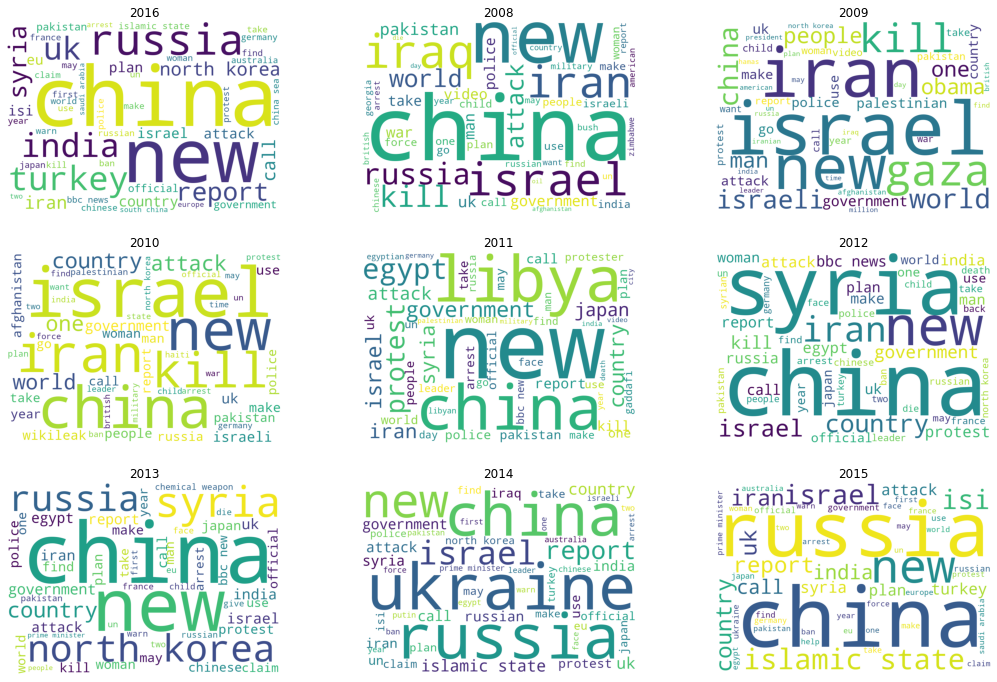

In [22]:
ncols = 3
nrows = 3
fig = plt.gcf()
fig.set_size_inches(ncols*6, nrows*4)
for idx , year in enumerate(set(df.year)):
    plt.subplot(nrows,ncols,idx+1).axis('Off')
    plt.title(f'{year}')
    plt.imshow(WordCloud(max_words=50, width = 1000, height = 700, background_color='white').generate(' '.join(df.loc[df['year'] == year, 'title_processed_joined'])))

#plt.subplots_adjust(wspace=0.90, hspace=0.3)
plt.show()

In [23]:
df.loc[df['year']==2016,'title_processed_joined']

417963    dubai new year firework go ahead fire engulf h...
417964    iran deny fire rocket near warship gulf condem...
417965    geneediting injection could one day offer hope...
417966    south china sea teen camp dispute land young a...
417967    china jail activist support hong kong democrac...
                                ...                        
499850    heil trump donald trump altright white nationa...
499851              people speculate could madeleine mccann
499852              professor receive arab researcher award
499853    nigel farage attack response trump ambassador ...
499854    palestinian wield knife shoot dead west bank i...
Name: title_processed_joined, Length: 81892, dtype: object

Now we will go a step ahead and try to find some popular news topics each year. First let's defne some functions we will use for plotting. 

In [24]:
# Taken from -
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [25]:
# Apart from plotting the frequently used words, we use the upvotes column to look at the popularity of each topic.

def plot_popular_topics(nmf, tfidf_feature_names, n_top_words, title, year):
    
    plot_top_words(nmf, tfidf_feature_names, 10,
               title)

    df_copy = df.loc[df['year']==year,:].reset_index()
    nmf_topic_values = nmf.transform(tfidf)
    df_copy['nmf_topics'] = nmf_topic_values.argmax(axis=1)

    nmf_remap = {0: 'Topic 1', 1: 'Topic 2', 2: 'Topic 3', 3: 'Topic 4', 
                 4: 'Topic 5', 5: 'Topic 6', 6: 'Topic 7', 7: 'Topic 8', 
                 8: 'Topic 9', 9: 'Topic 10'}
    df_copy['nmf_topics'] = df_copy['nmf_topics'].map(nmf_remap)

    nmf_x = df_copy.groupby('nmf_topics')['up_votes'].mean().sort_values(ascending=False)
    nmf_y = list(nmf_x.index)
    plt.figure(figsize=(50,30))
    sns.barplot(x = nmf_x, y = nmf_y)
    plt.title("NMF Topic popularities", fontsize=50)
    plt.ylabel('Topics', fontsize=50)
    plt.yticks(fontsize=40)
    plt.xlabel('Mean up_votes', fontsize=50)
    plt.xticks(fontsize=40)
    plt.show()

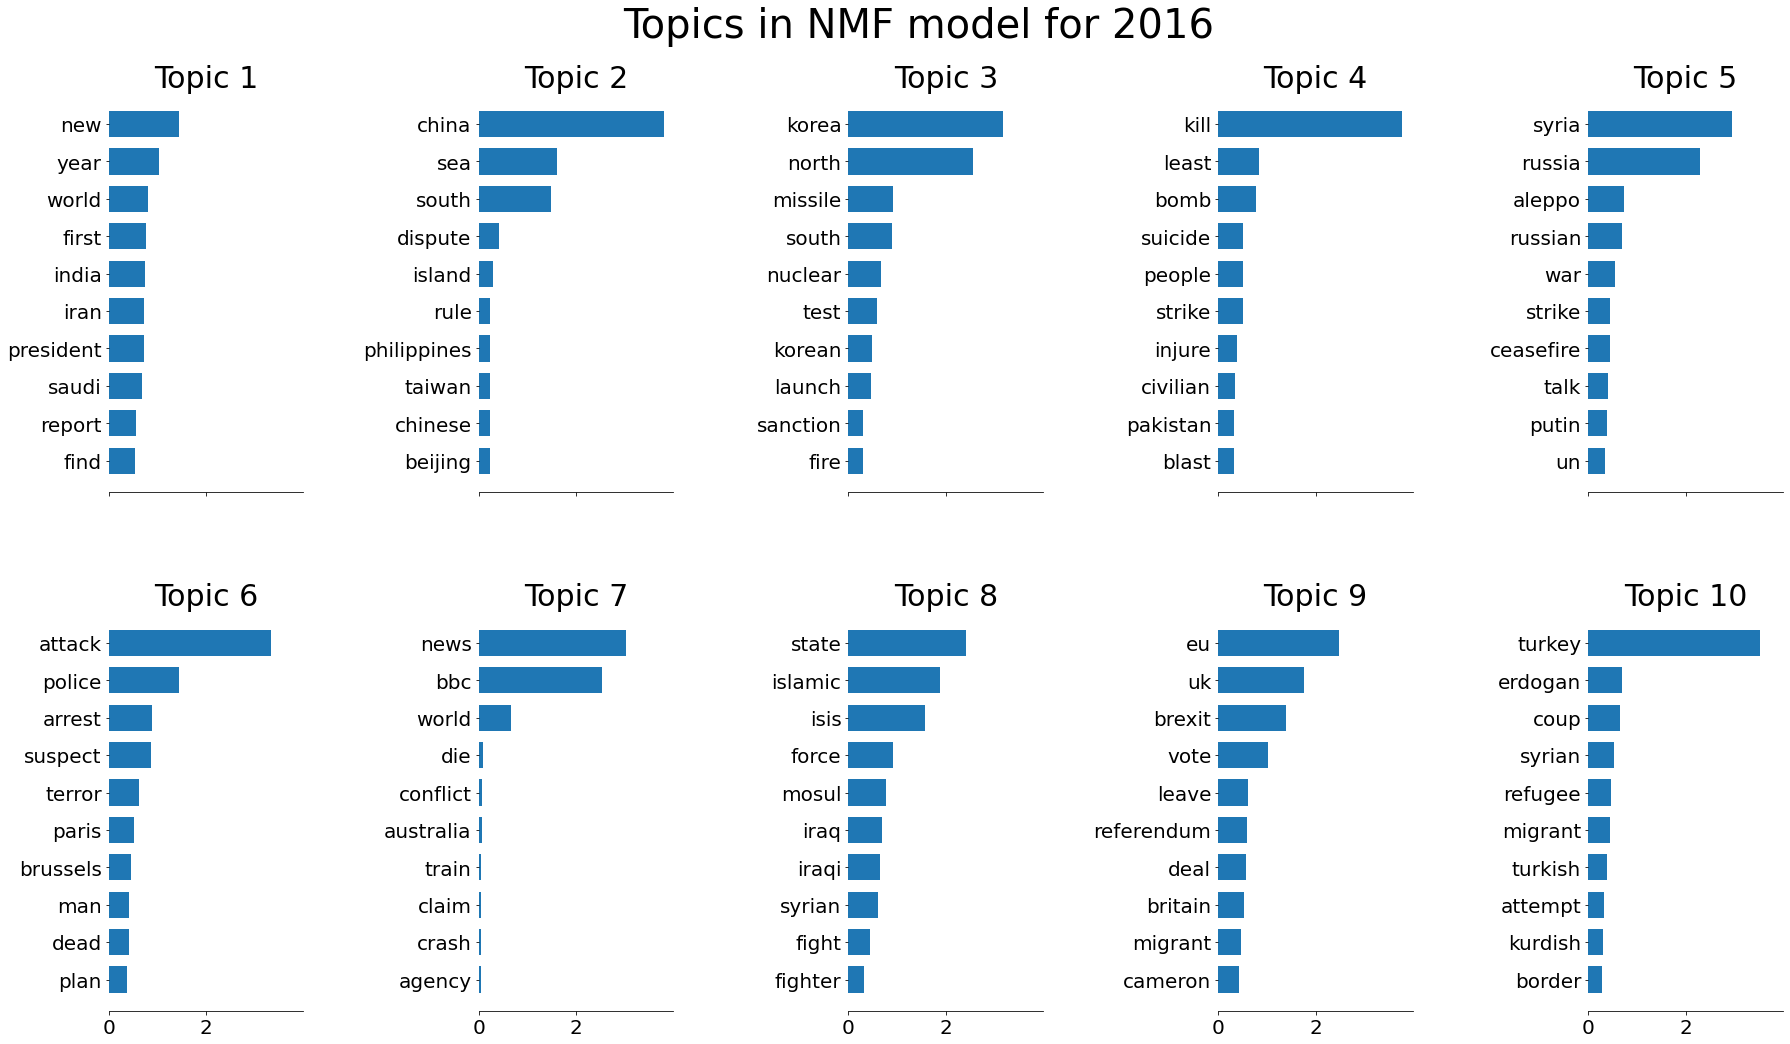

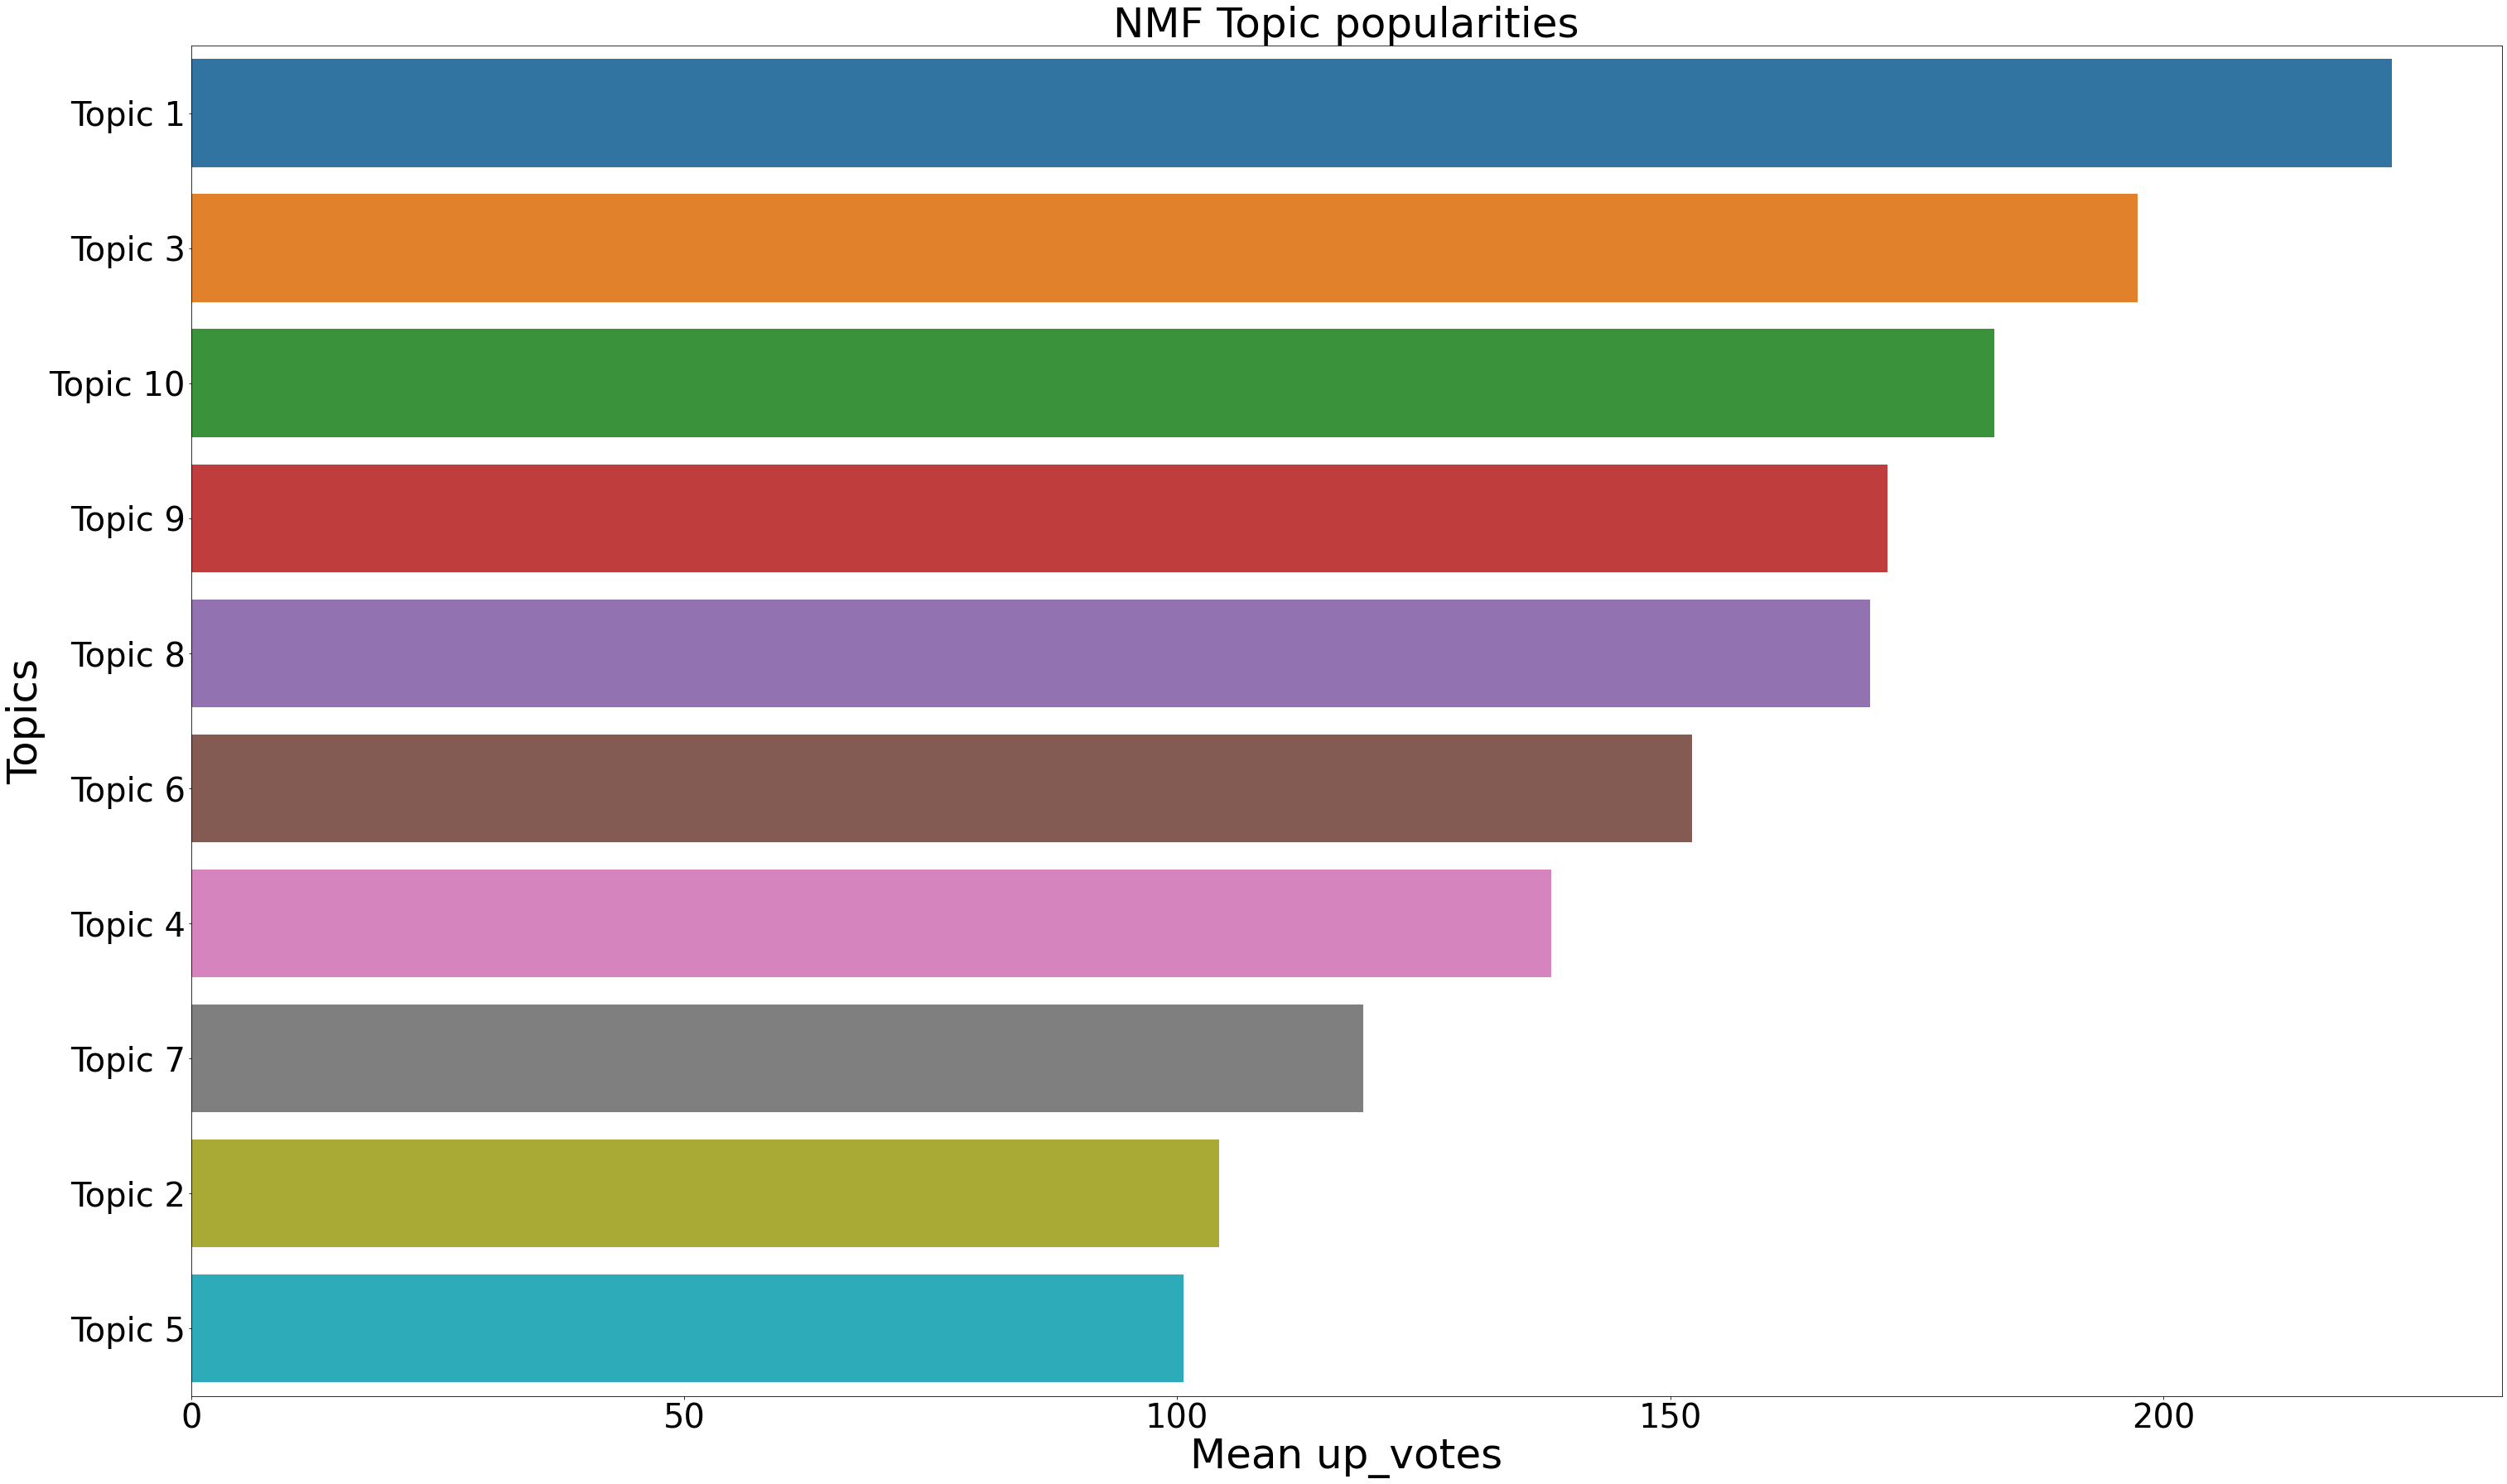

In [26]:
year = 2016

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =20, max_features=3000)
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==year,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=500).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {year}', year)

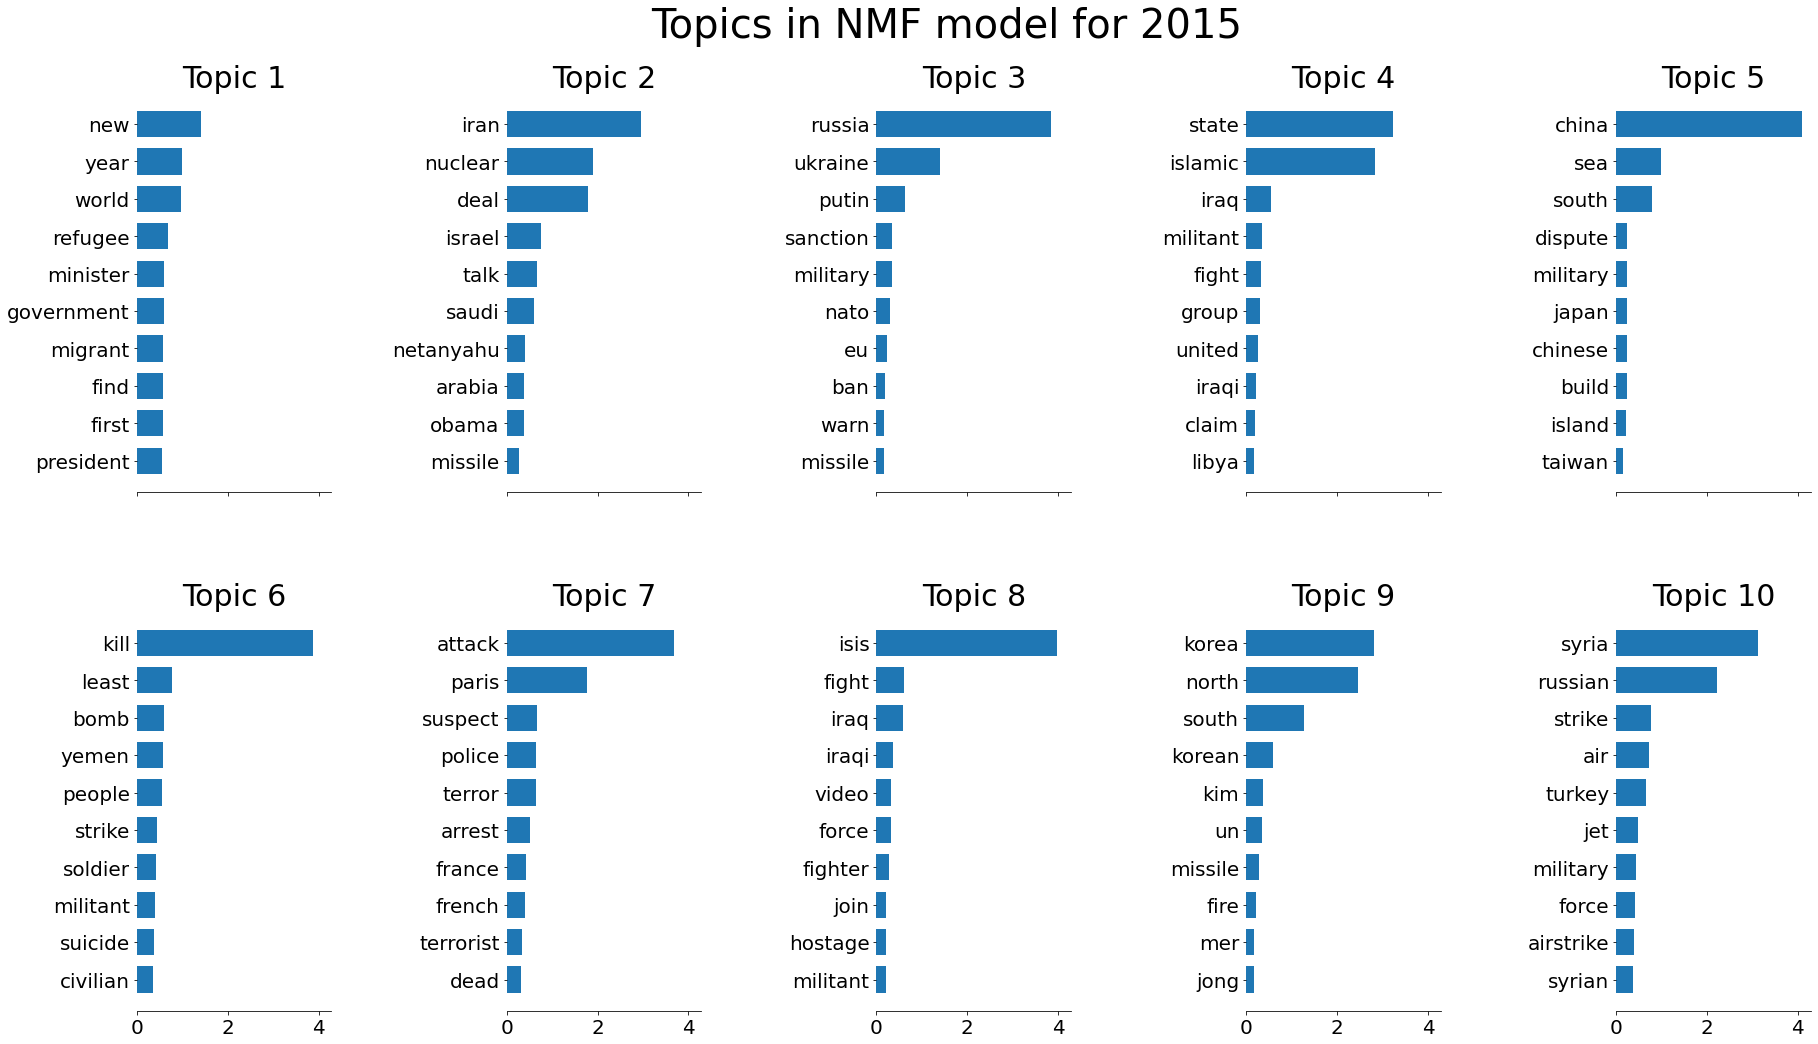

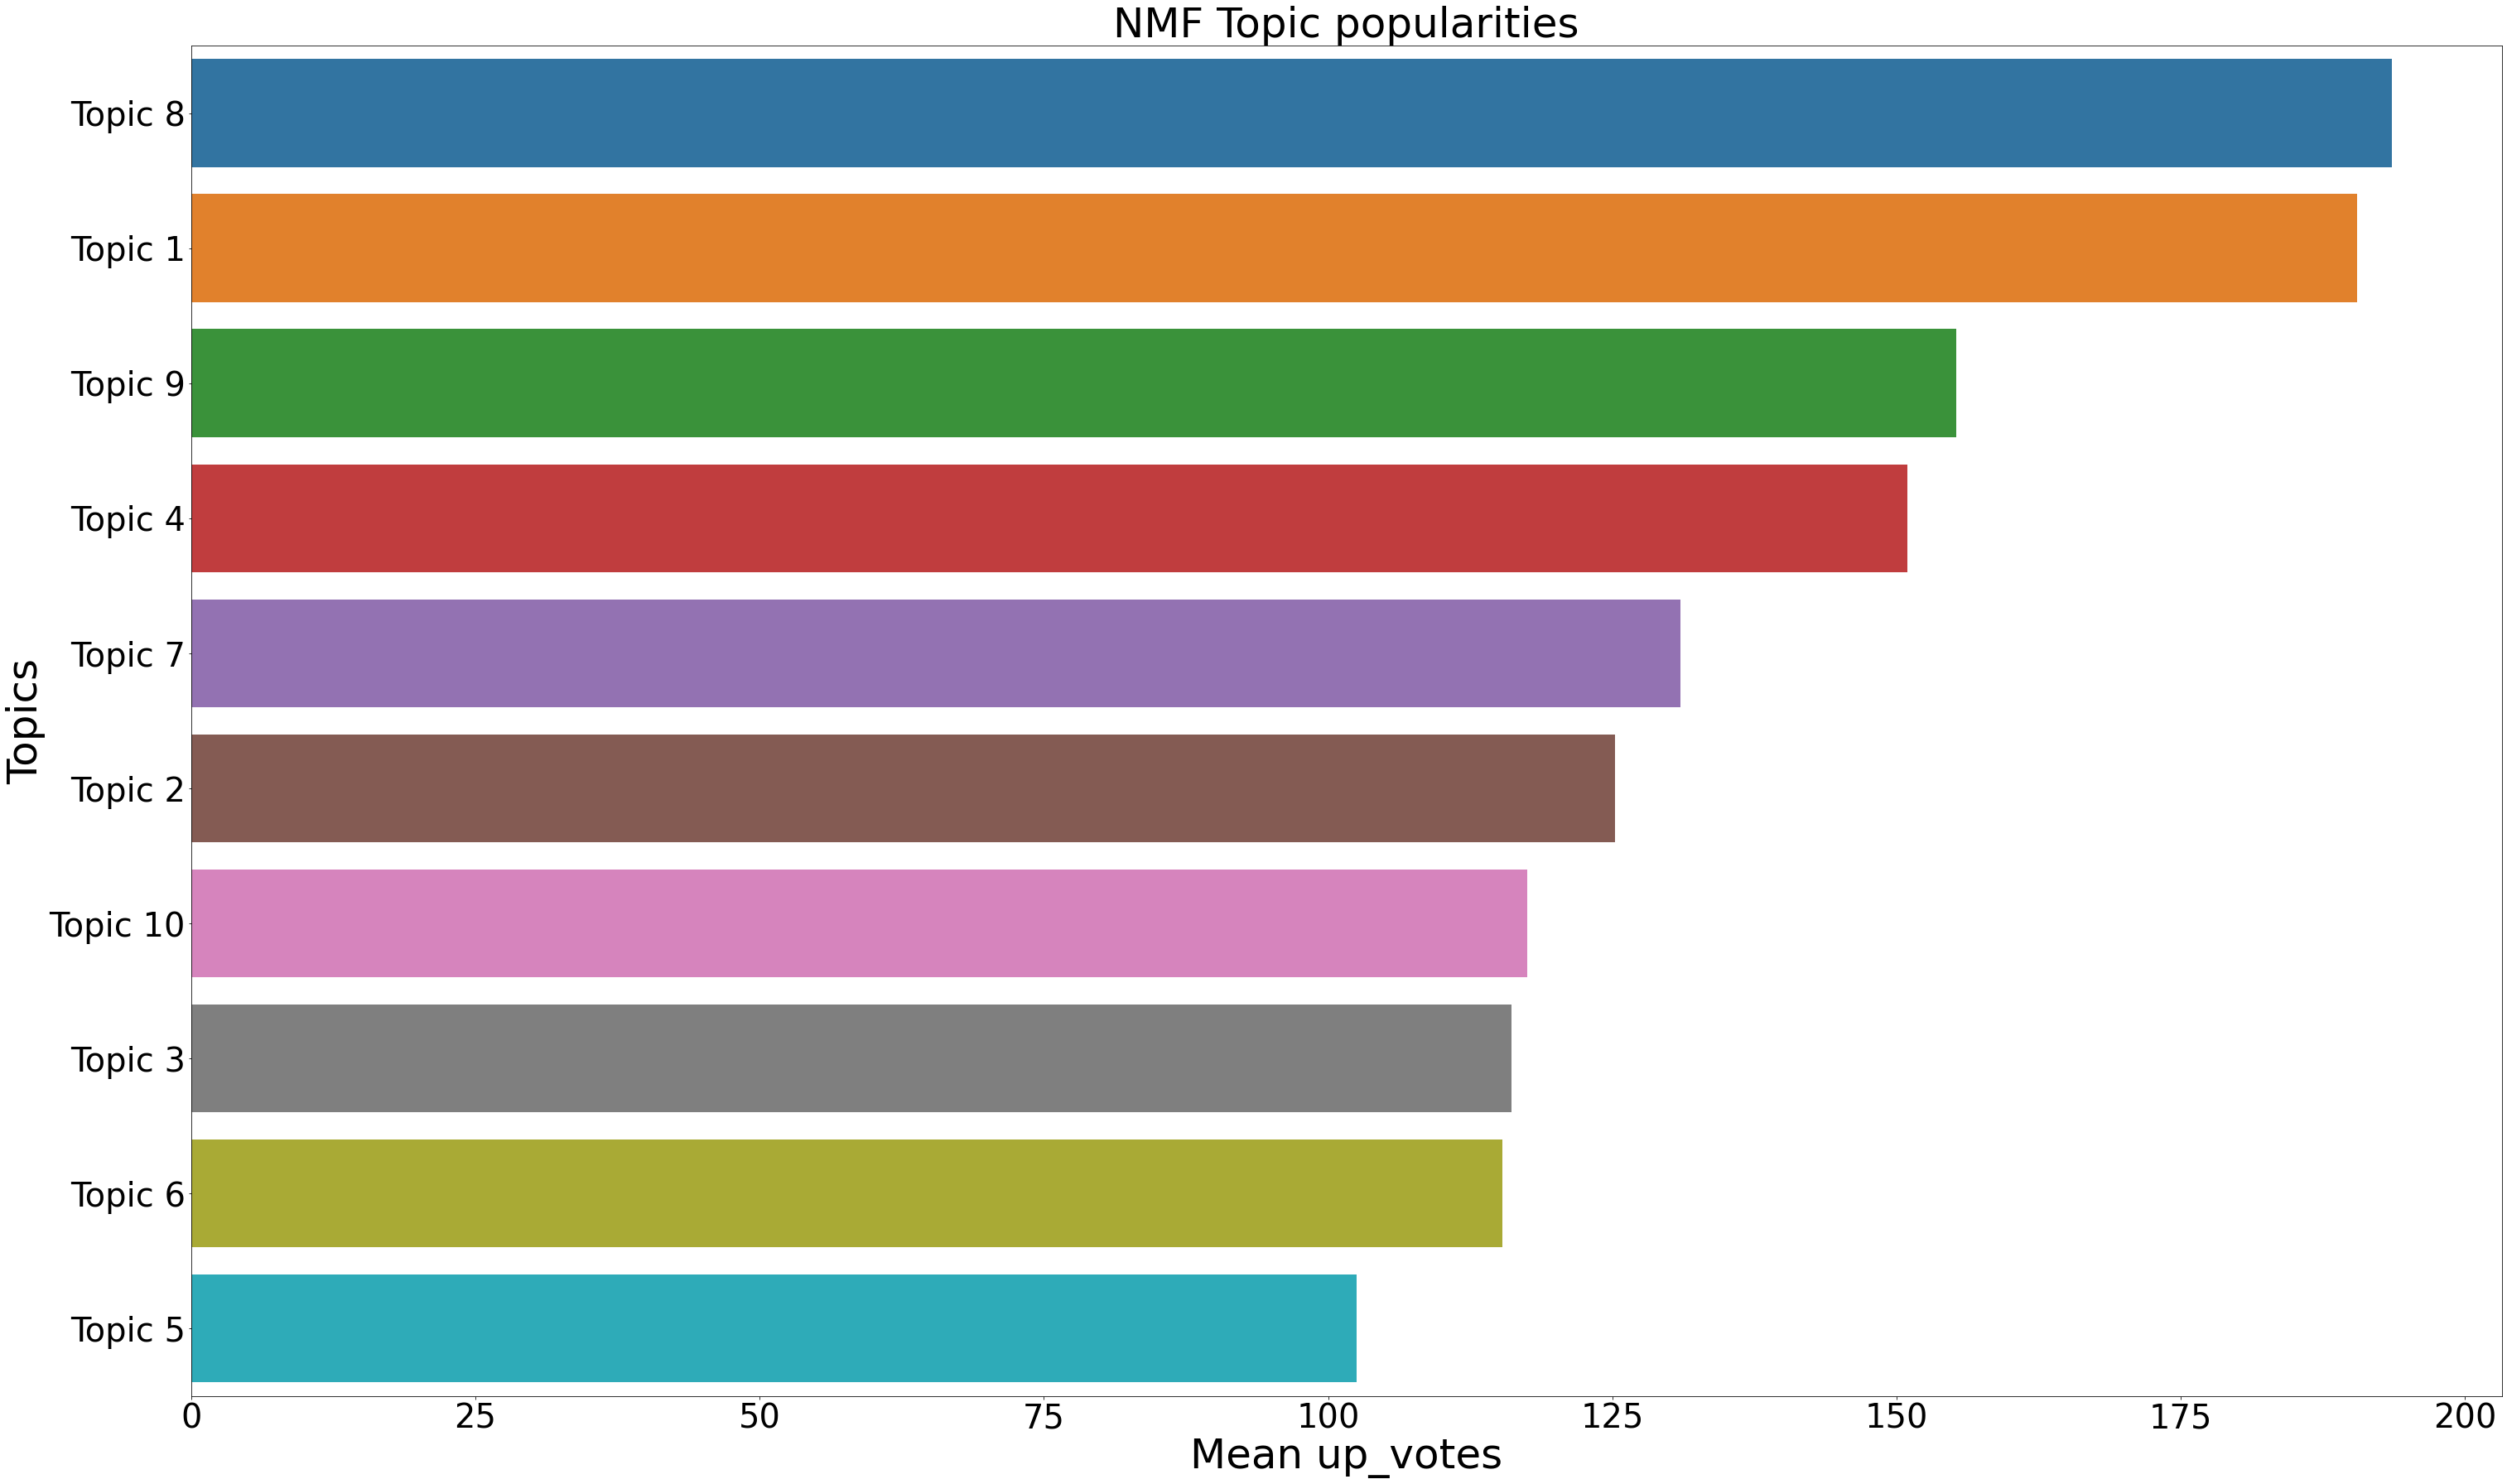

In [27]:
year = 2015

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =20, max_features=3000)
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==year,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=500).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {year}', year)

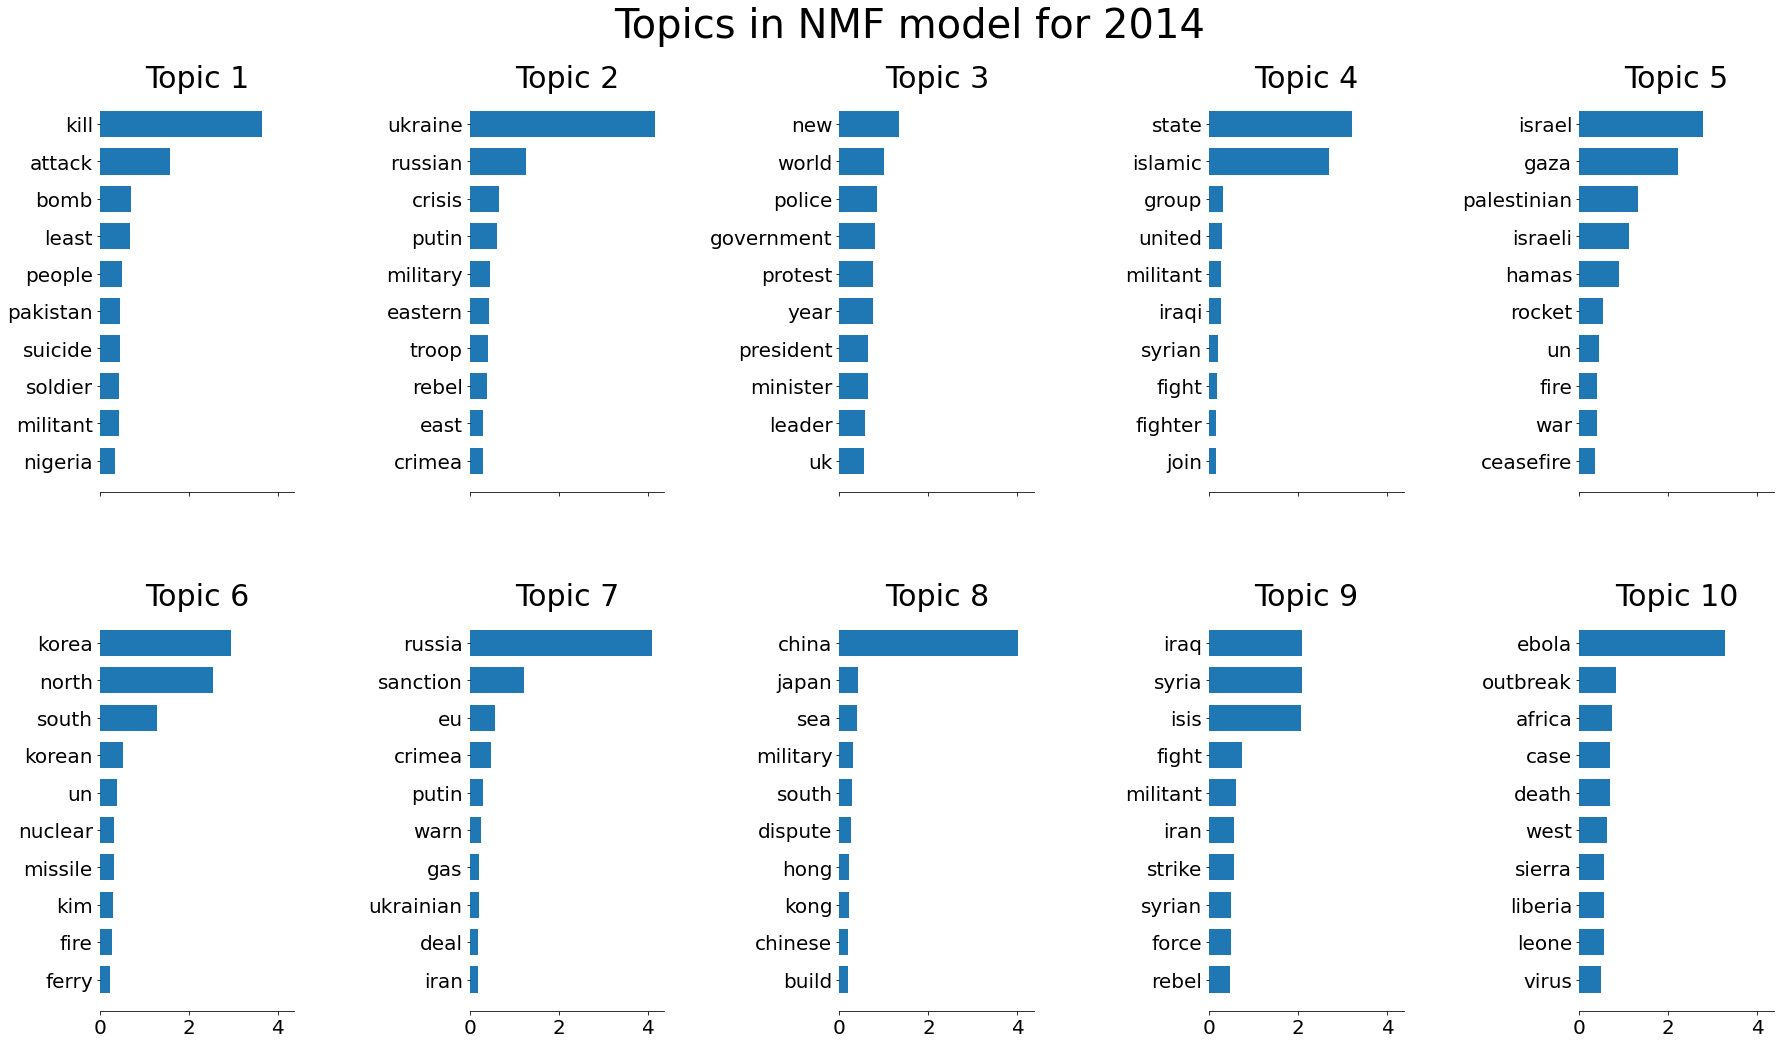

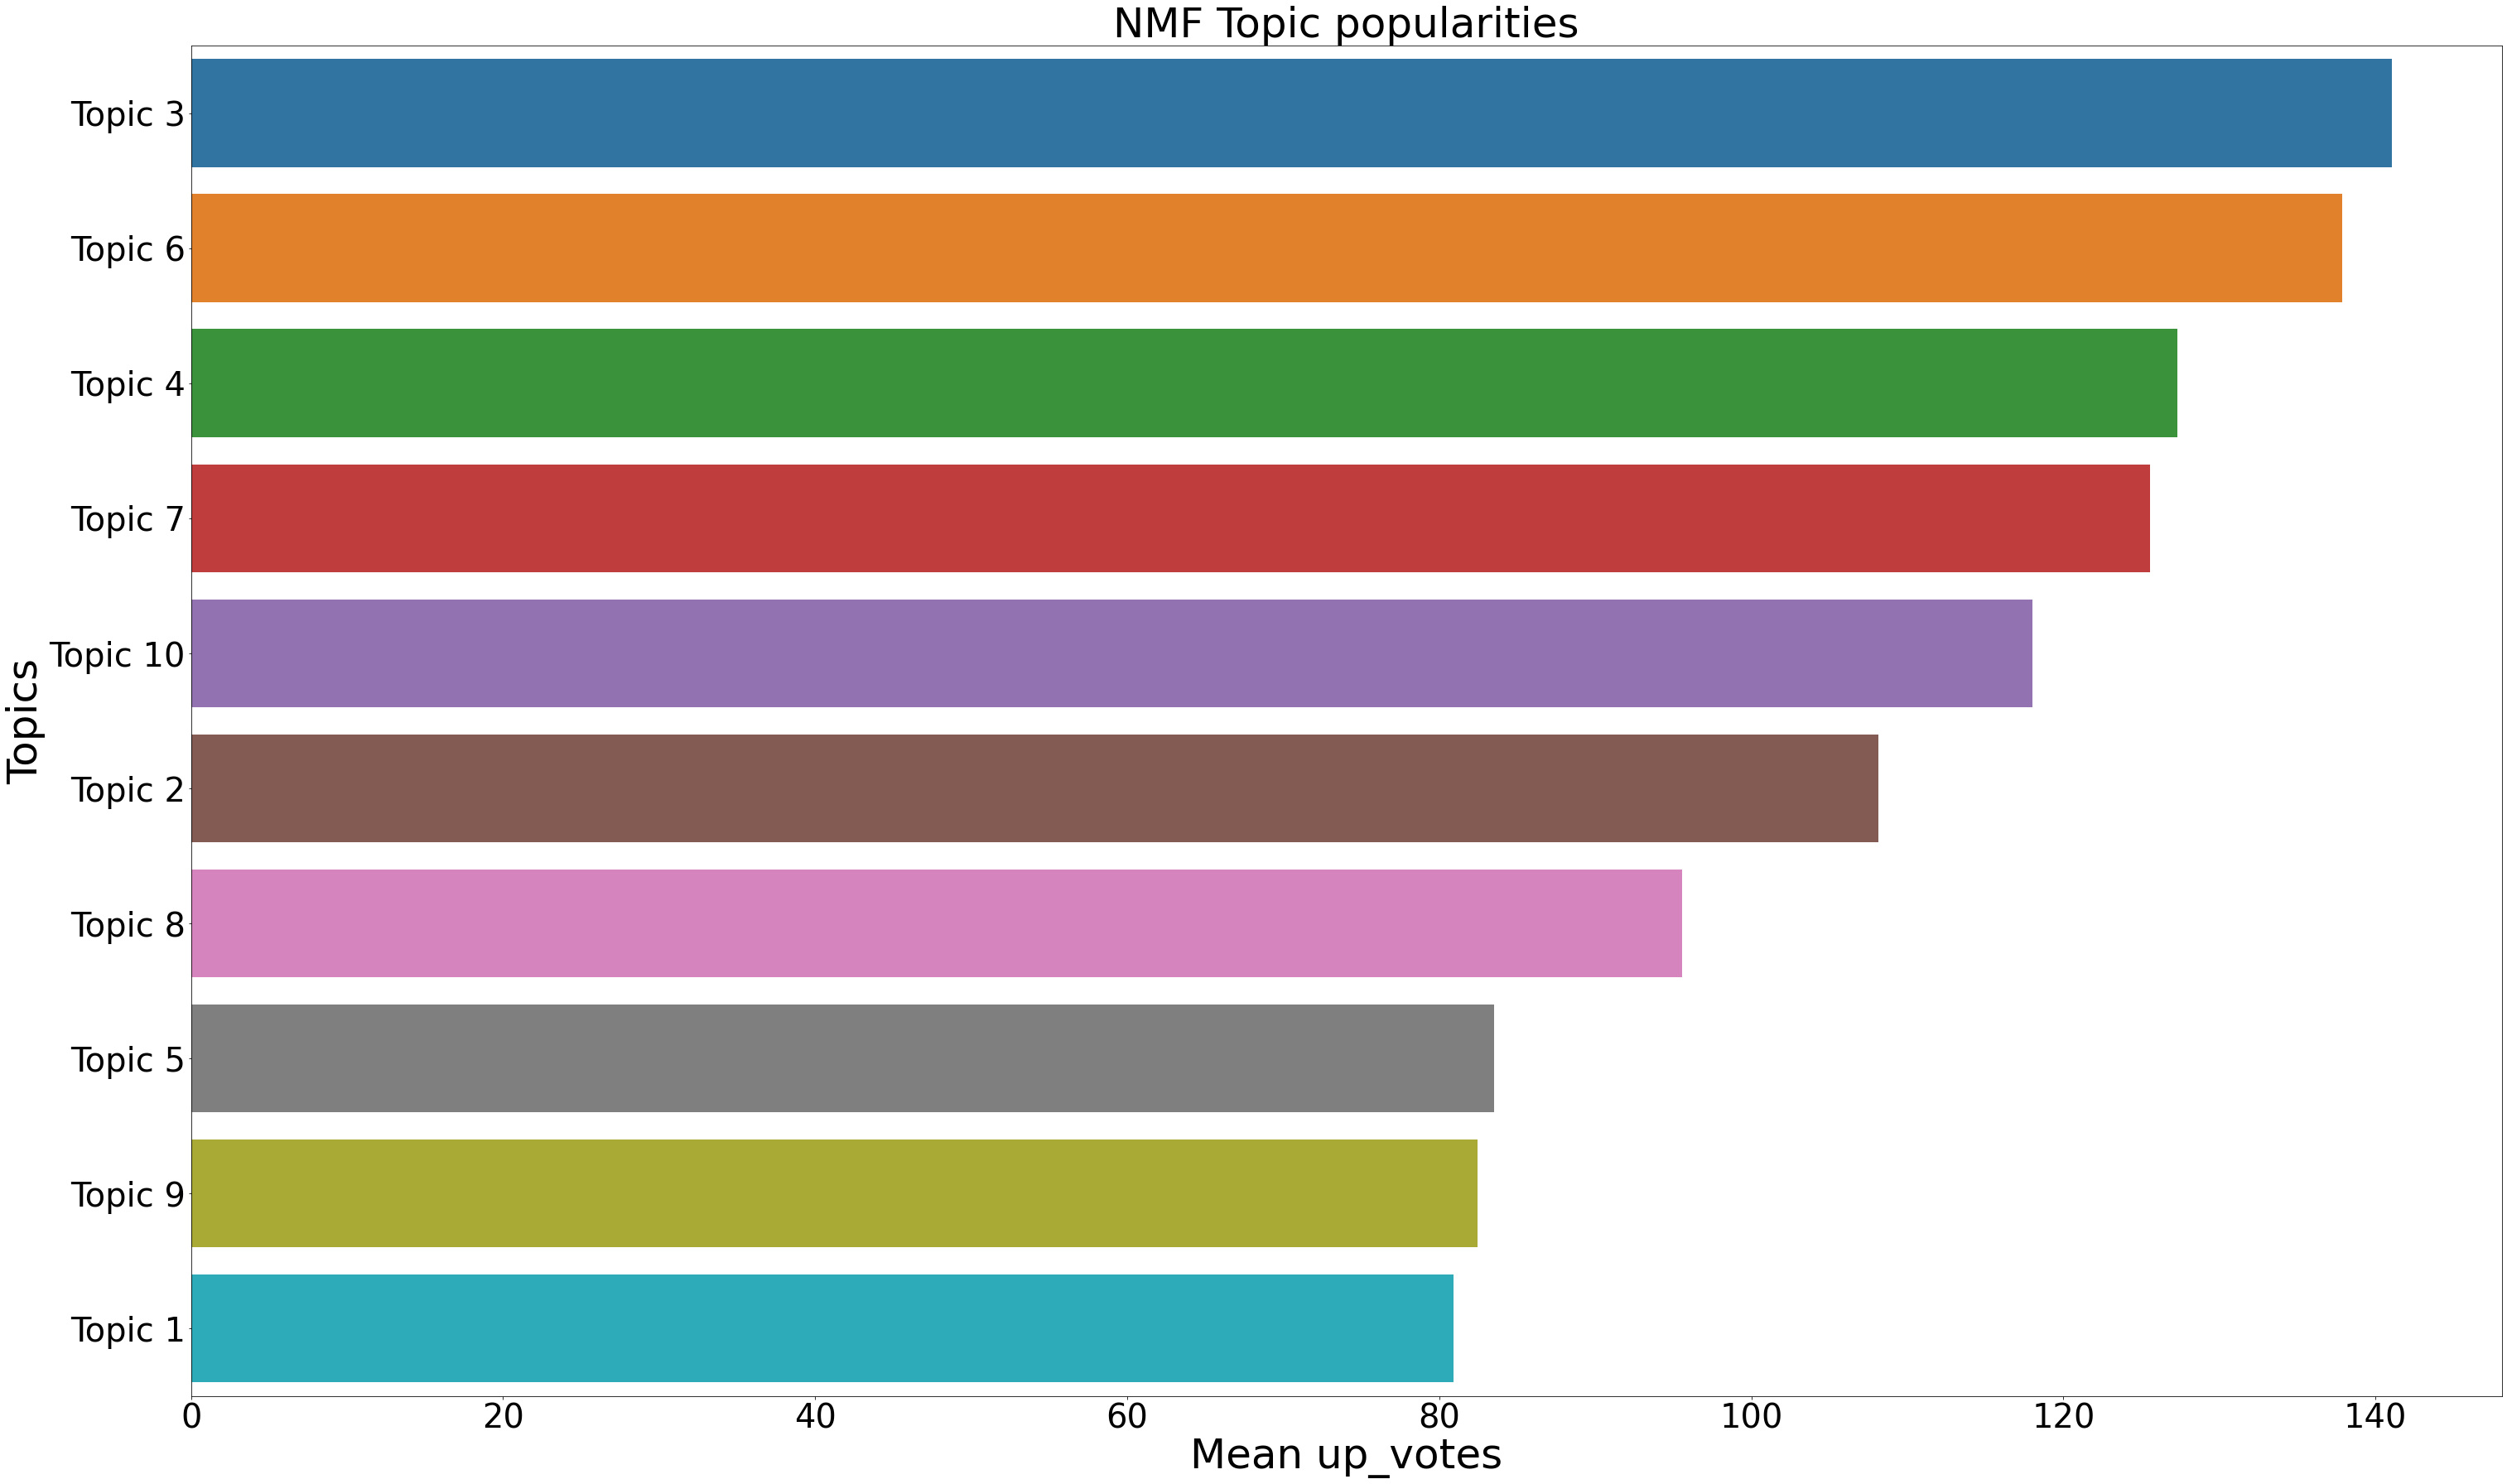

In [28]:
year = 2014

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =20, max_features=3000)
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==year,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=500).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {year}', year)

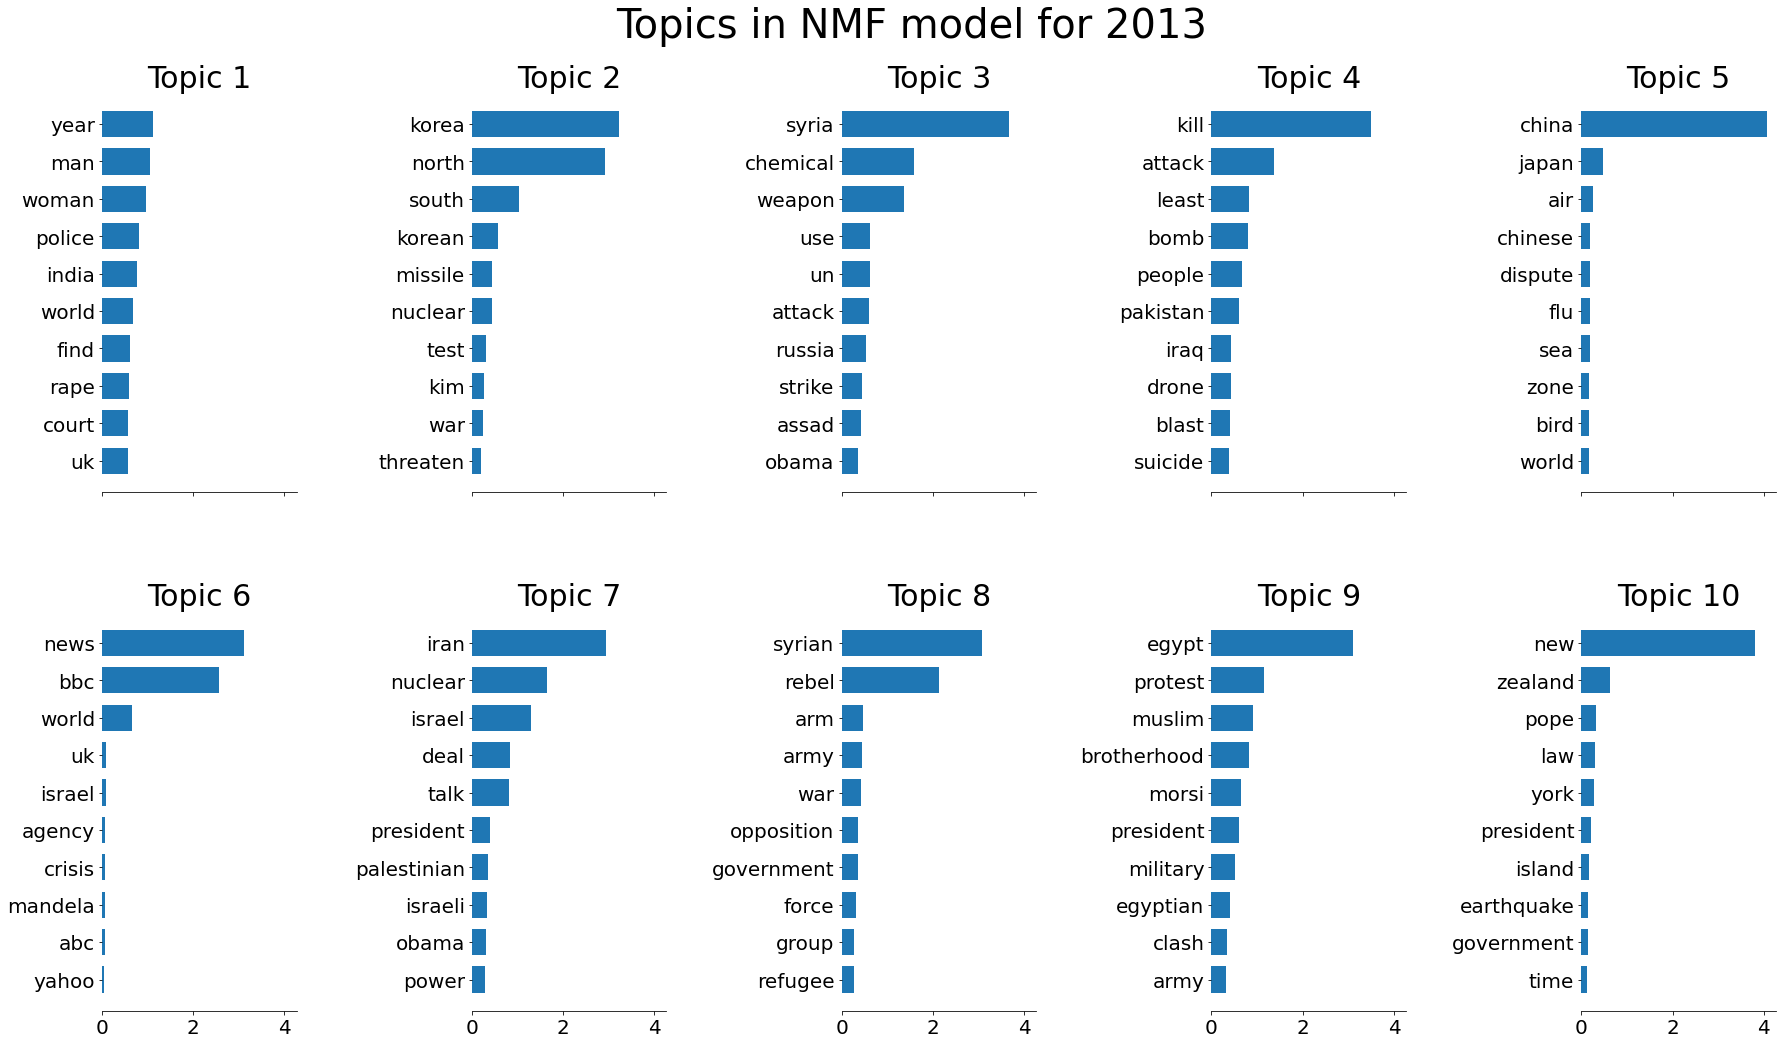

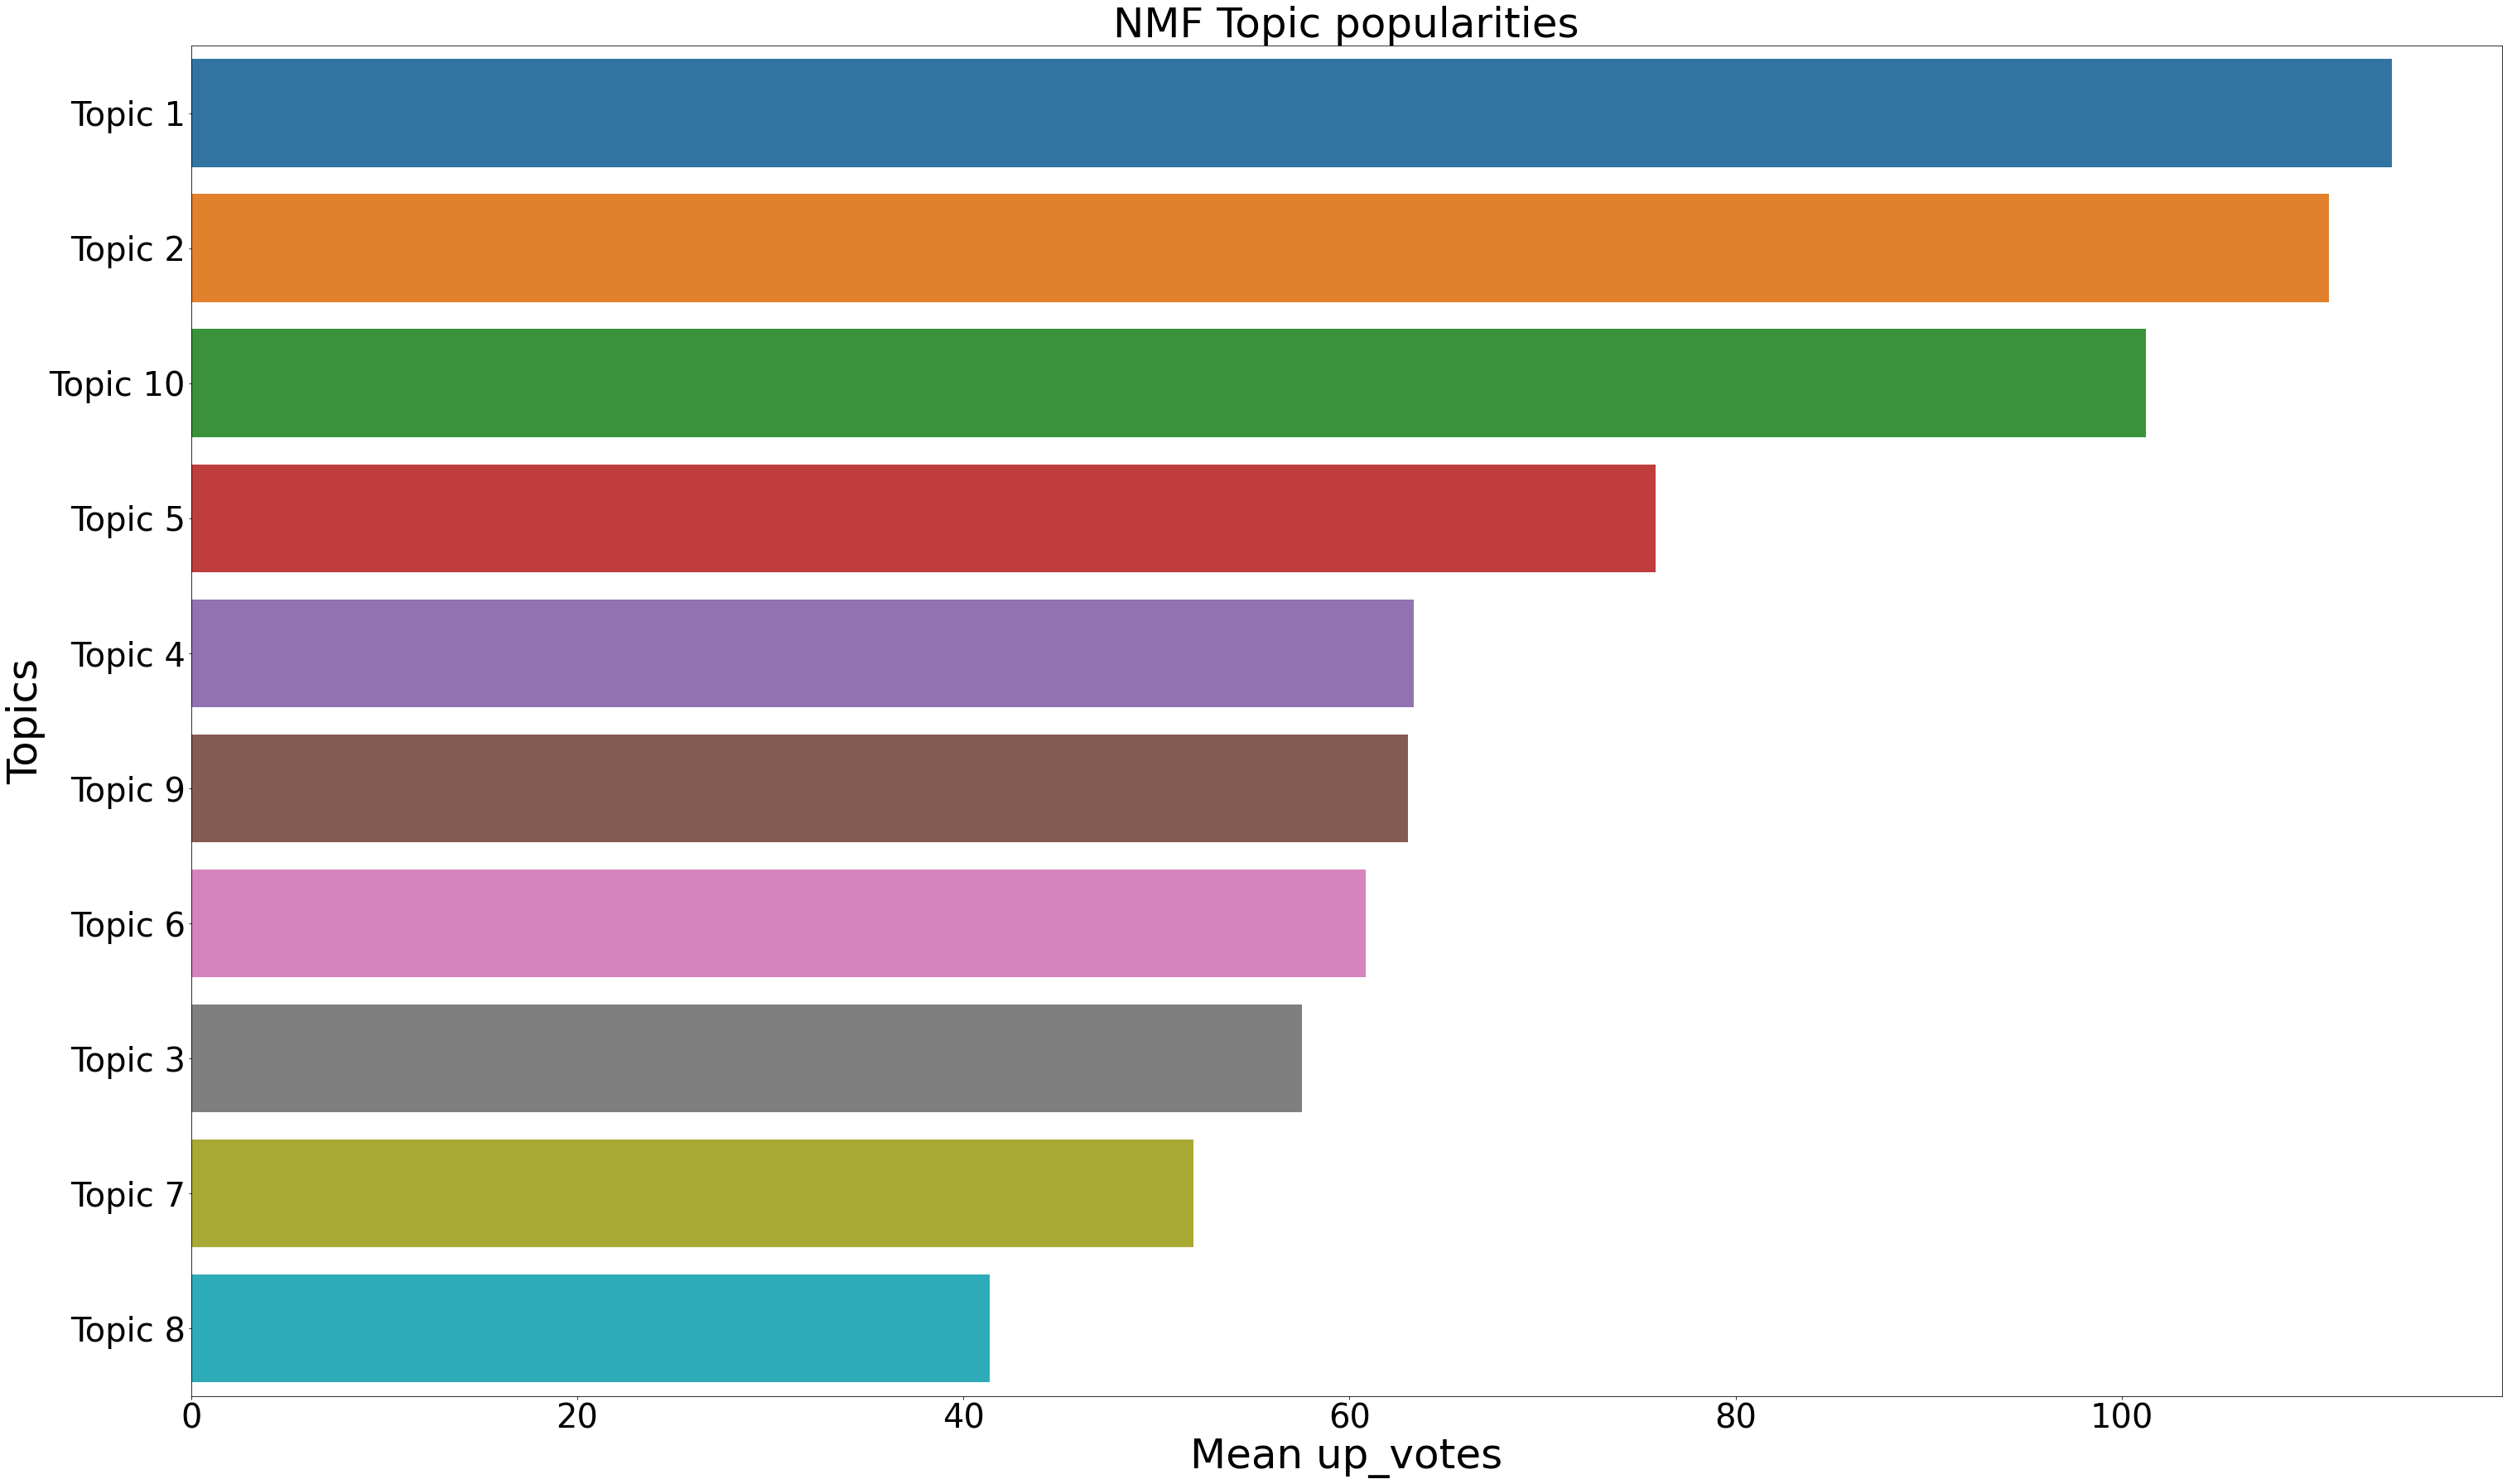

In [29]:
year = 2013

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =20, max_features=3000)
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==year,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=500).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {year}', year)

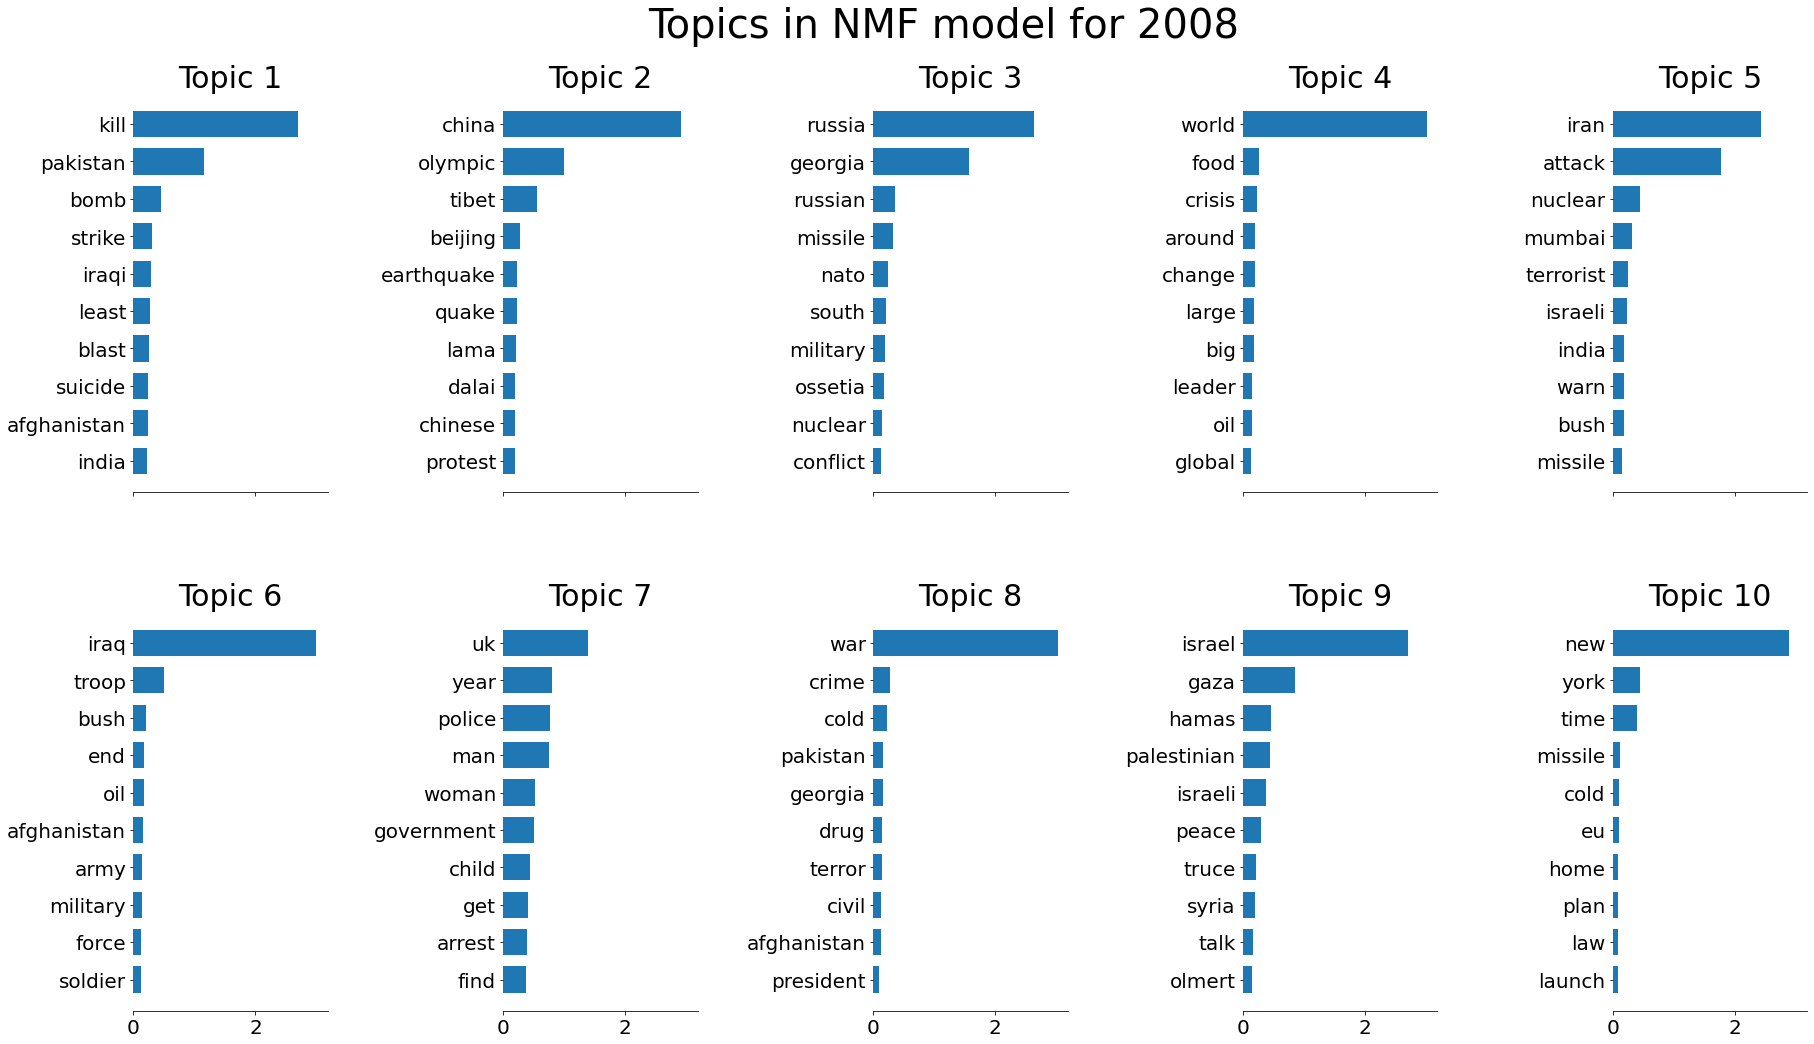

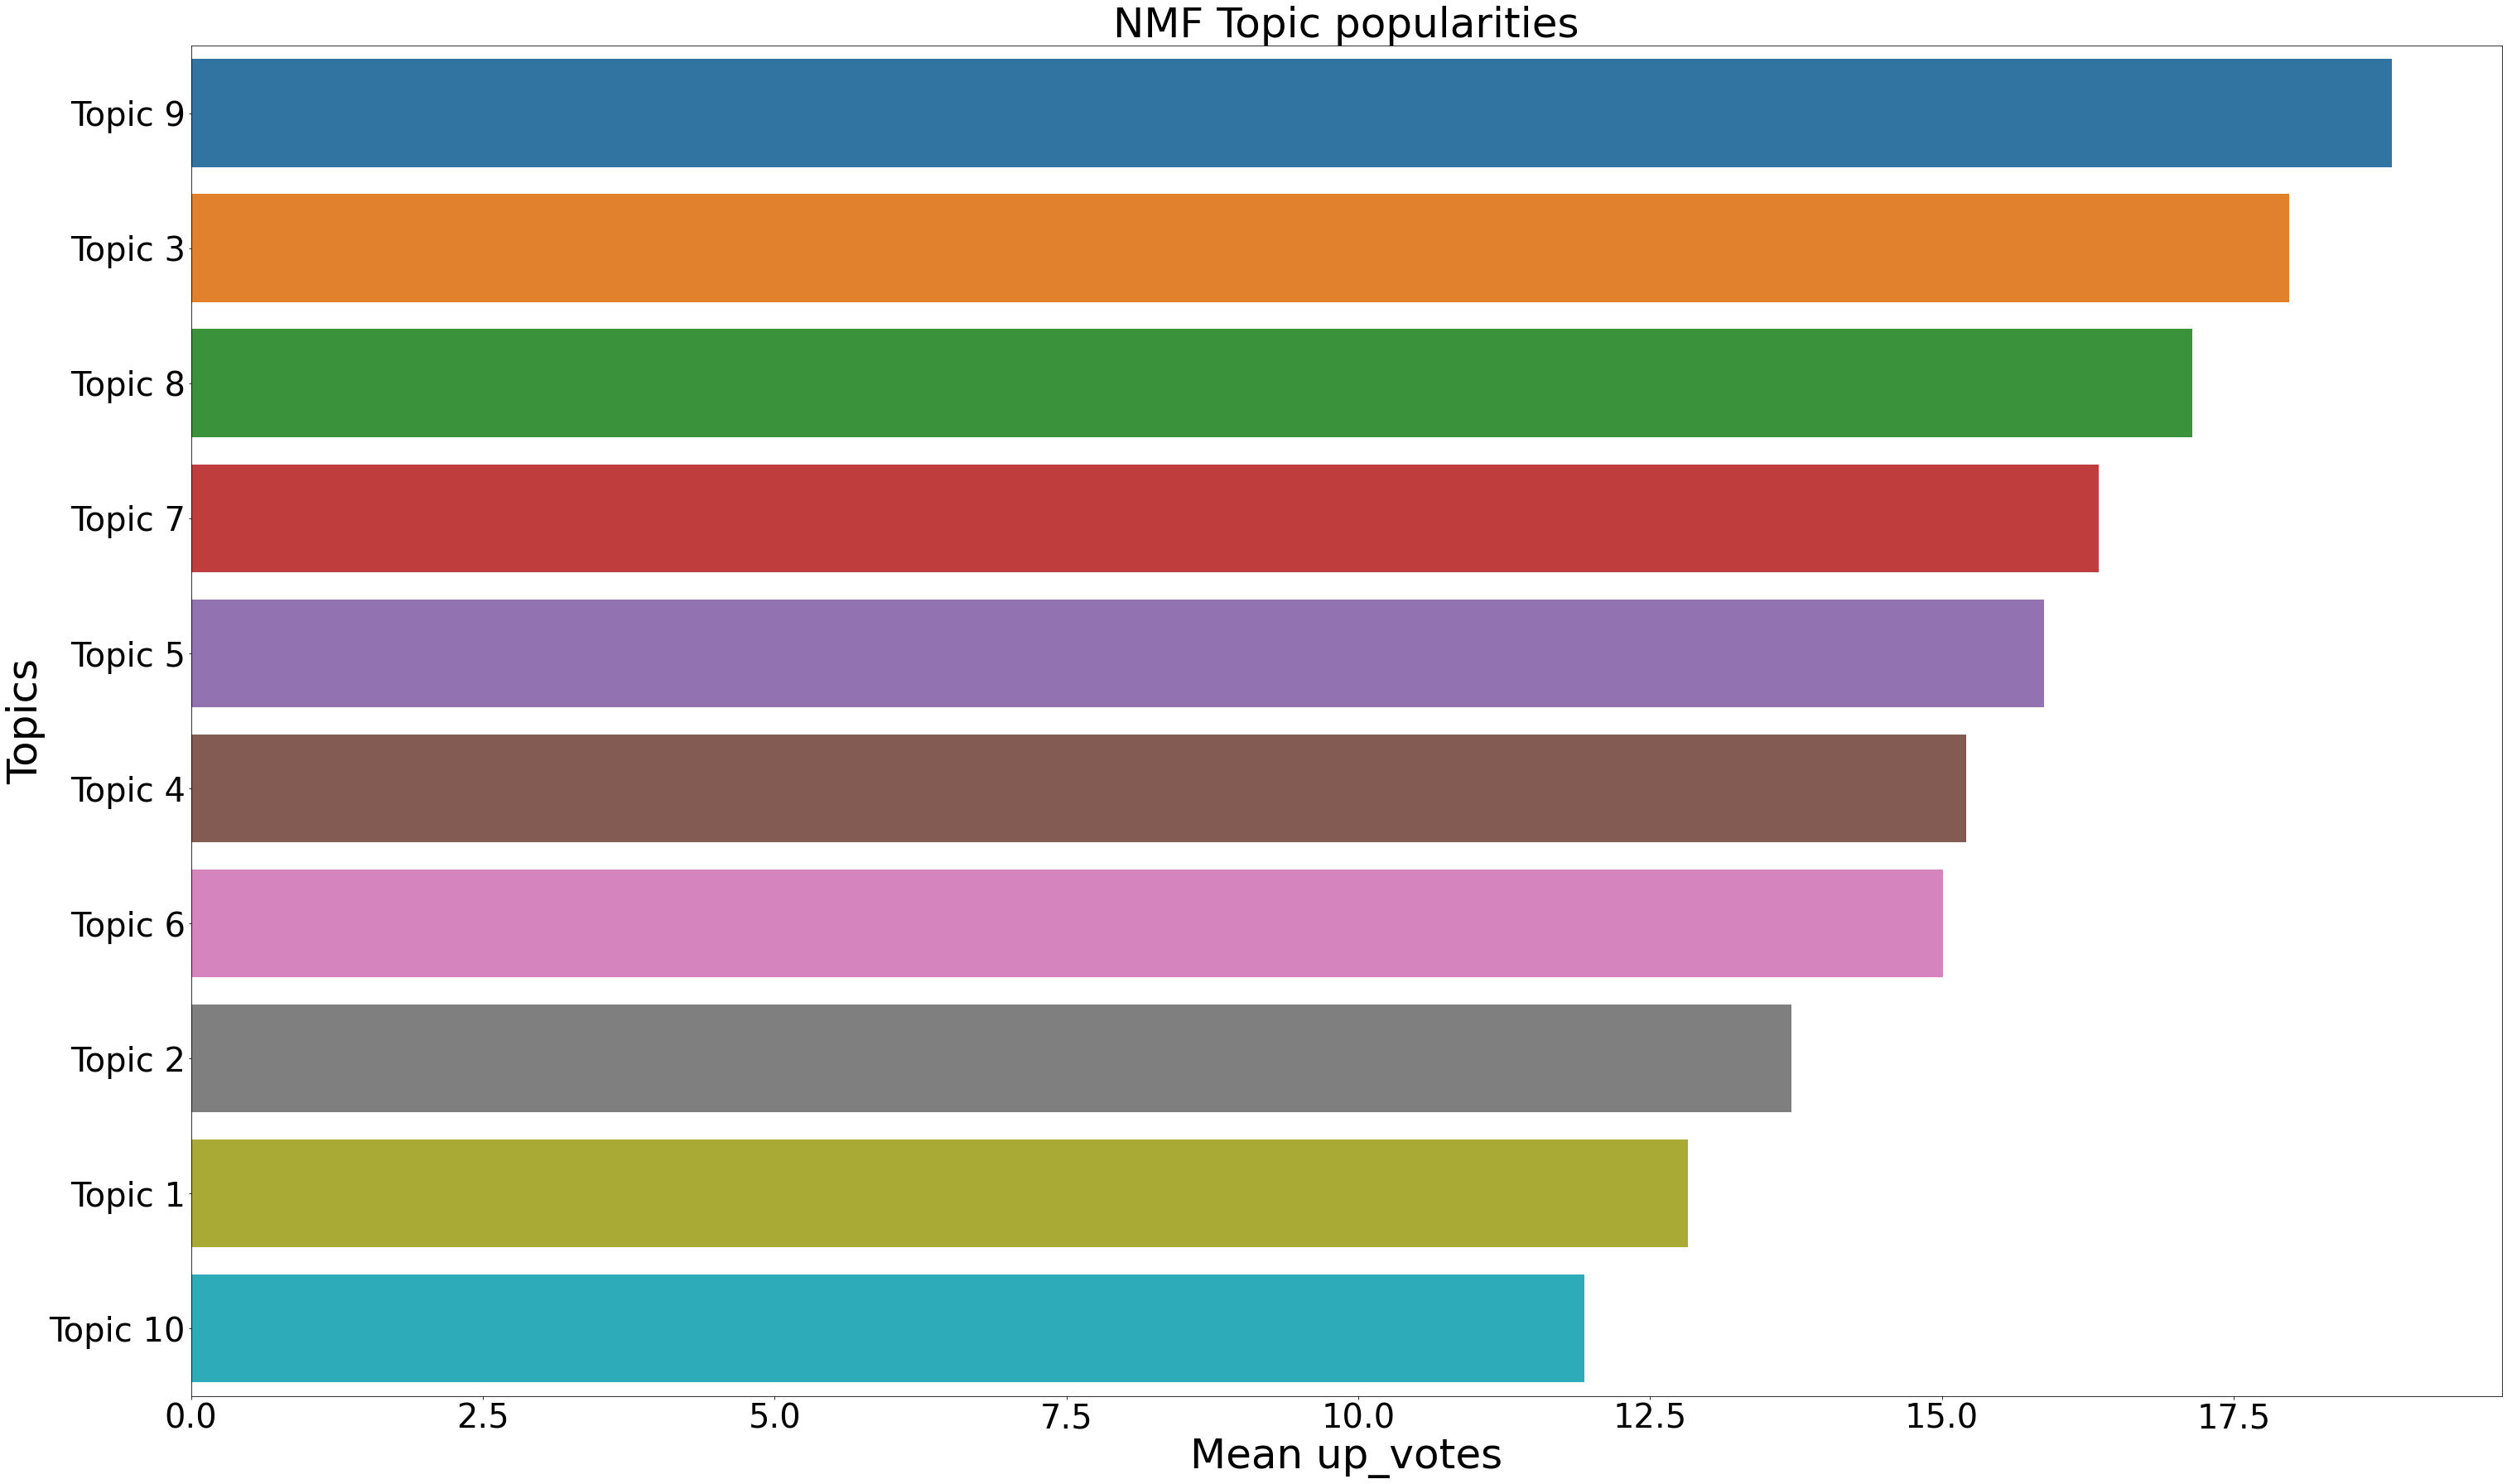

In [30]:
year = 2008

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =20, max_features=3000)
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==year,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=500).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {year}', year)

## Can inclusion of bi-grams tell us something different?

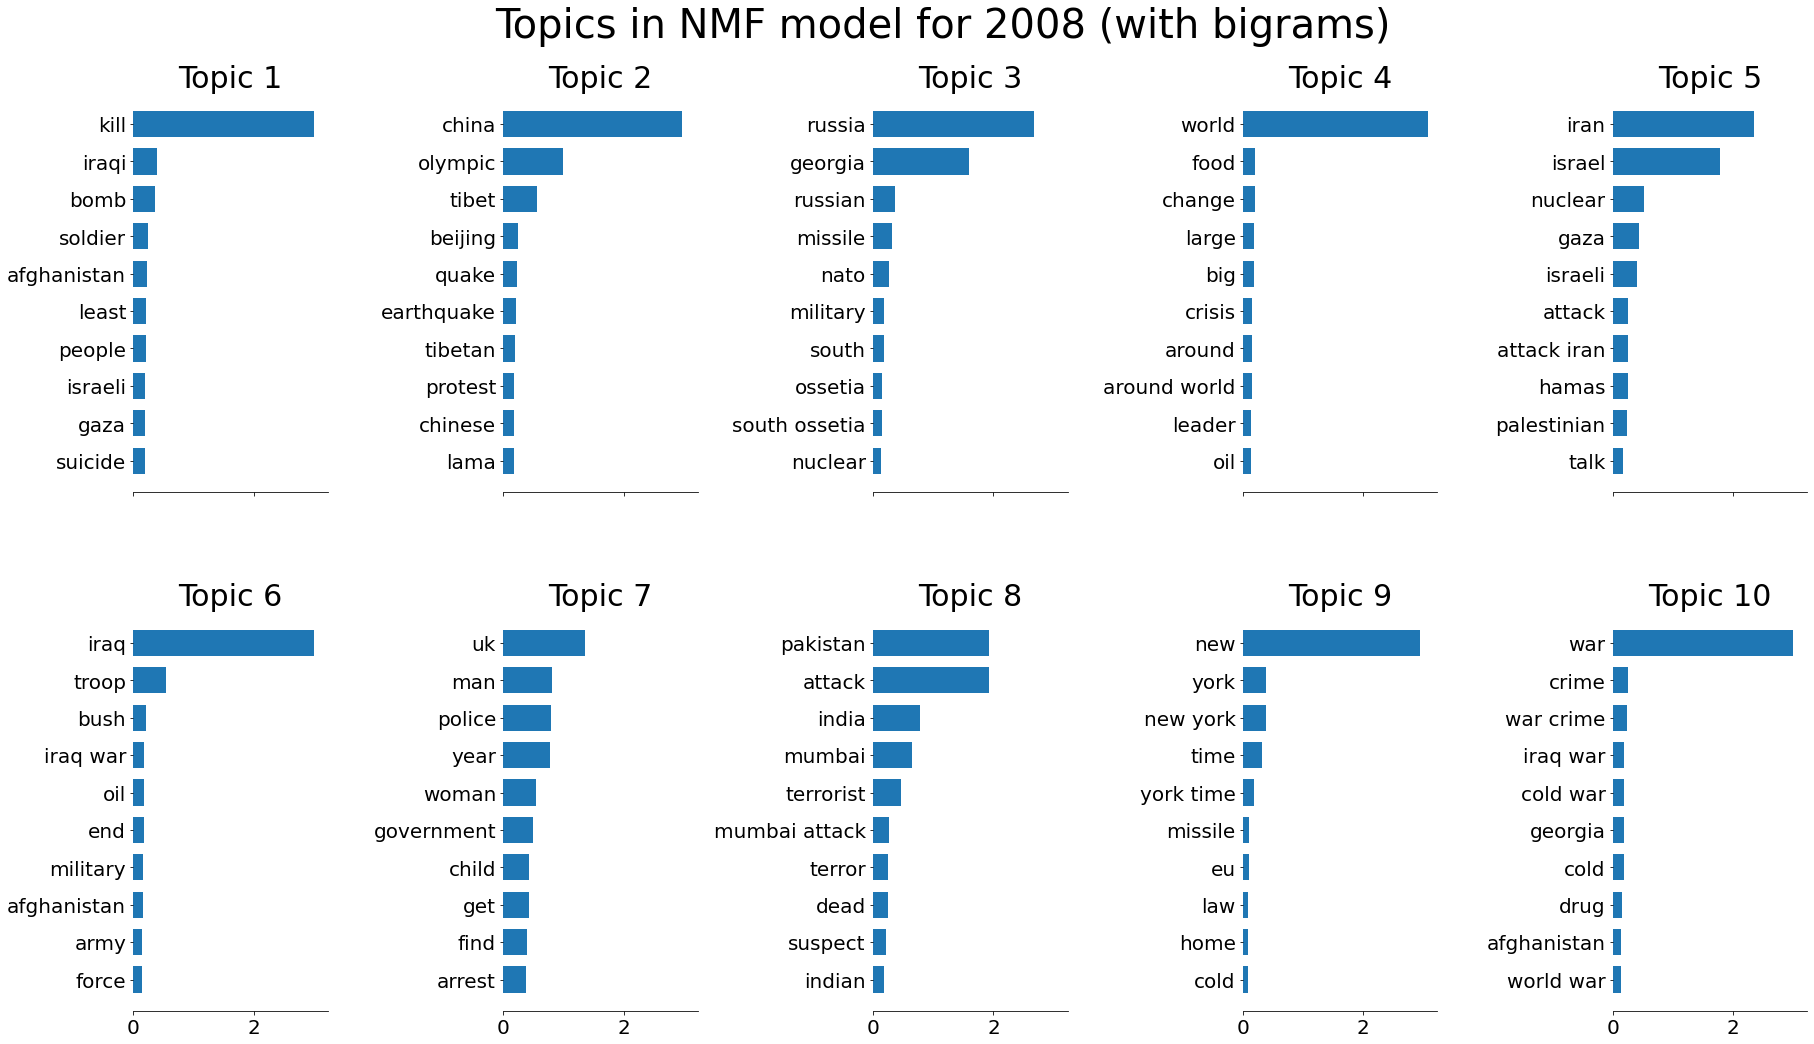

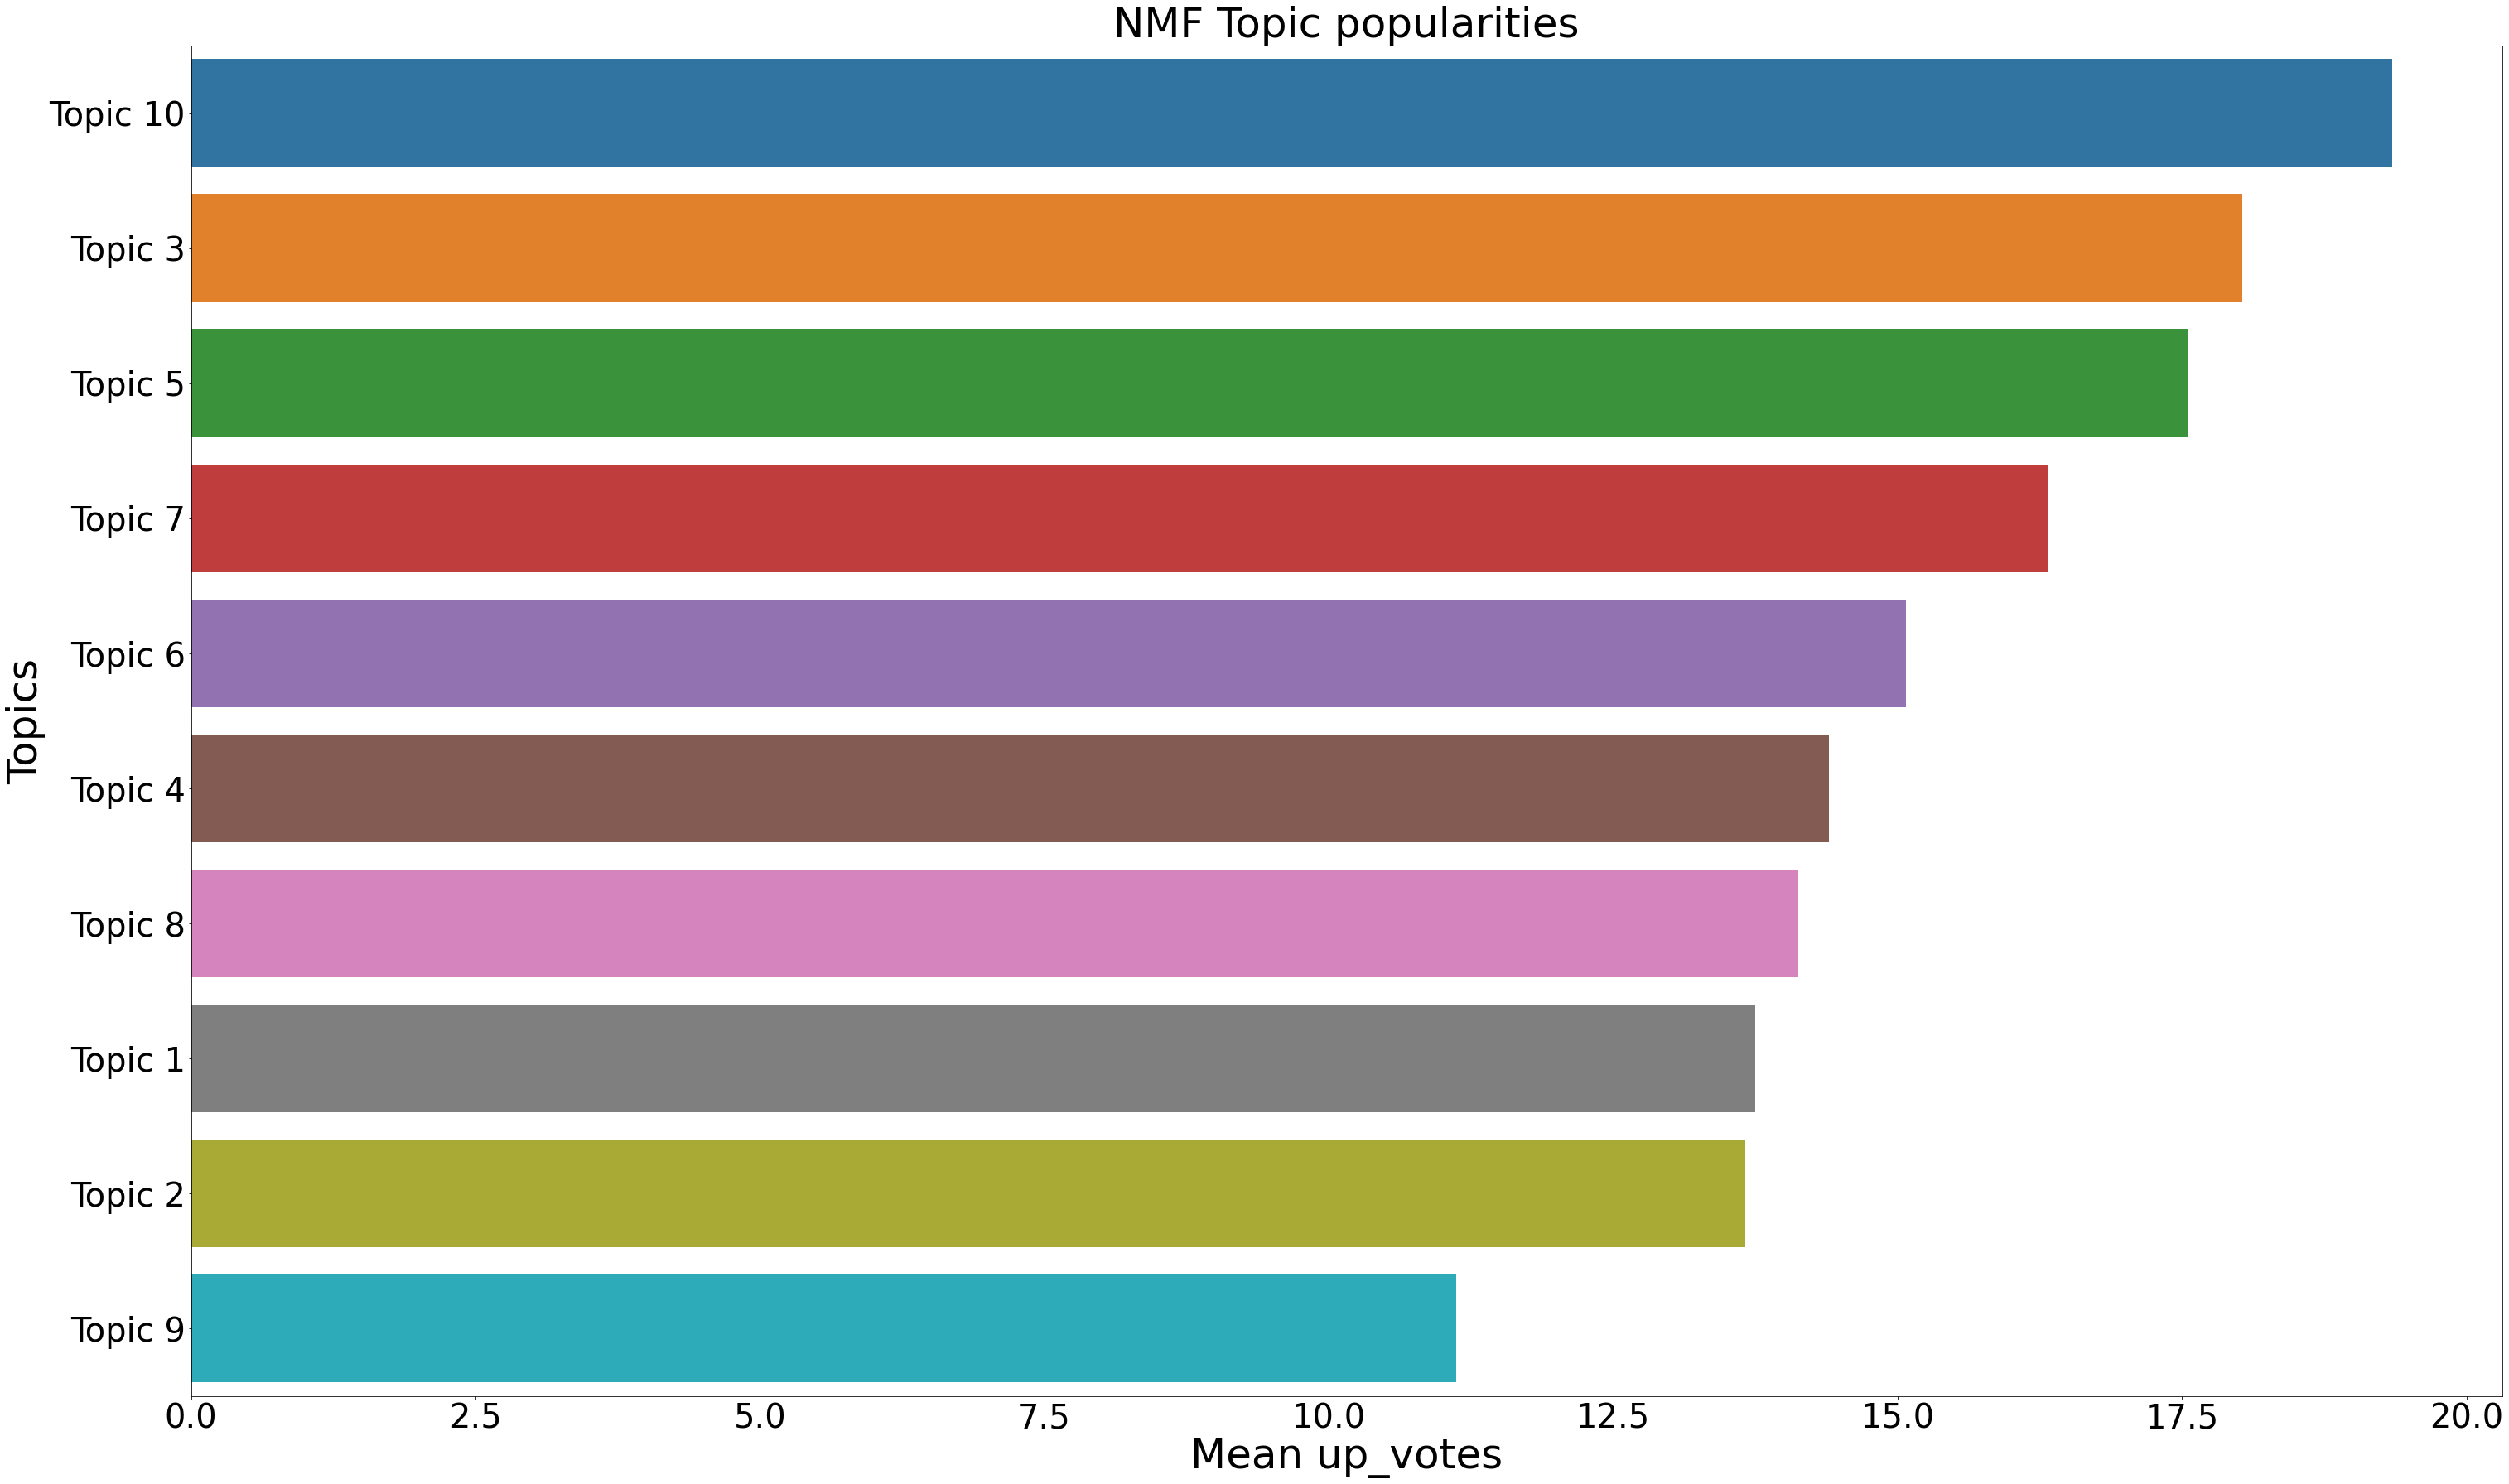

In [31]:
# Let's take a look at 2008
year = 2008

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000, ngram_range=(1,2))
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==year,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=500).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {year} (with bigrams)', year)

**There are some changes in the popularity even though the topics are largely the same.**

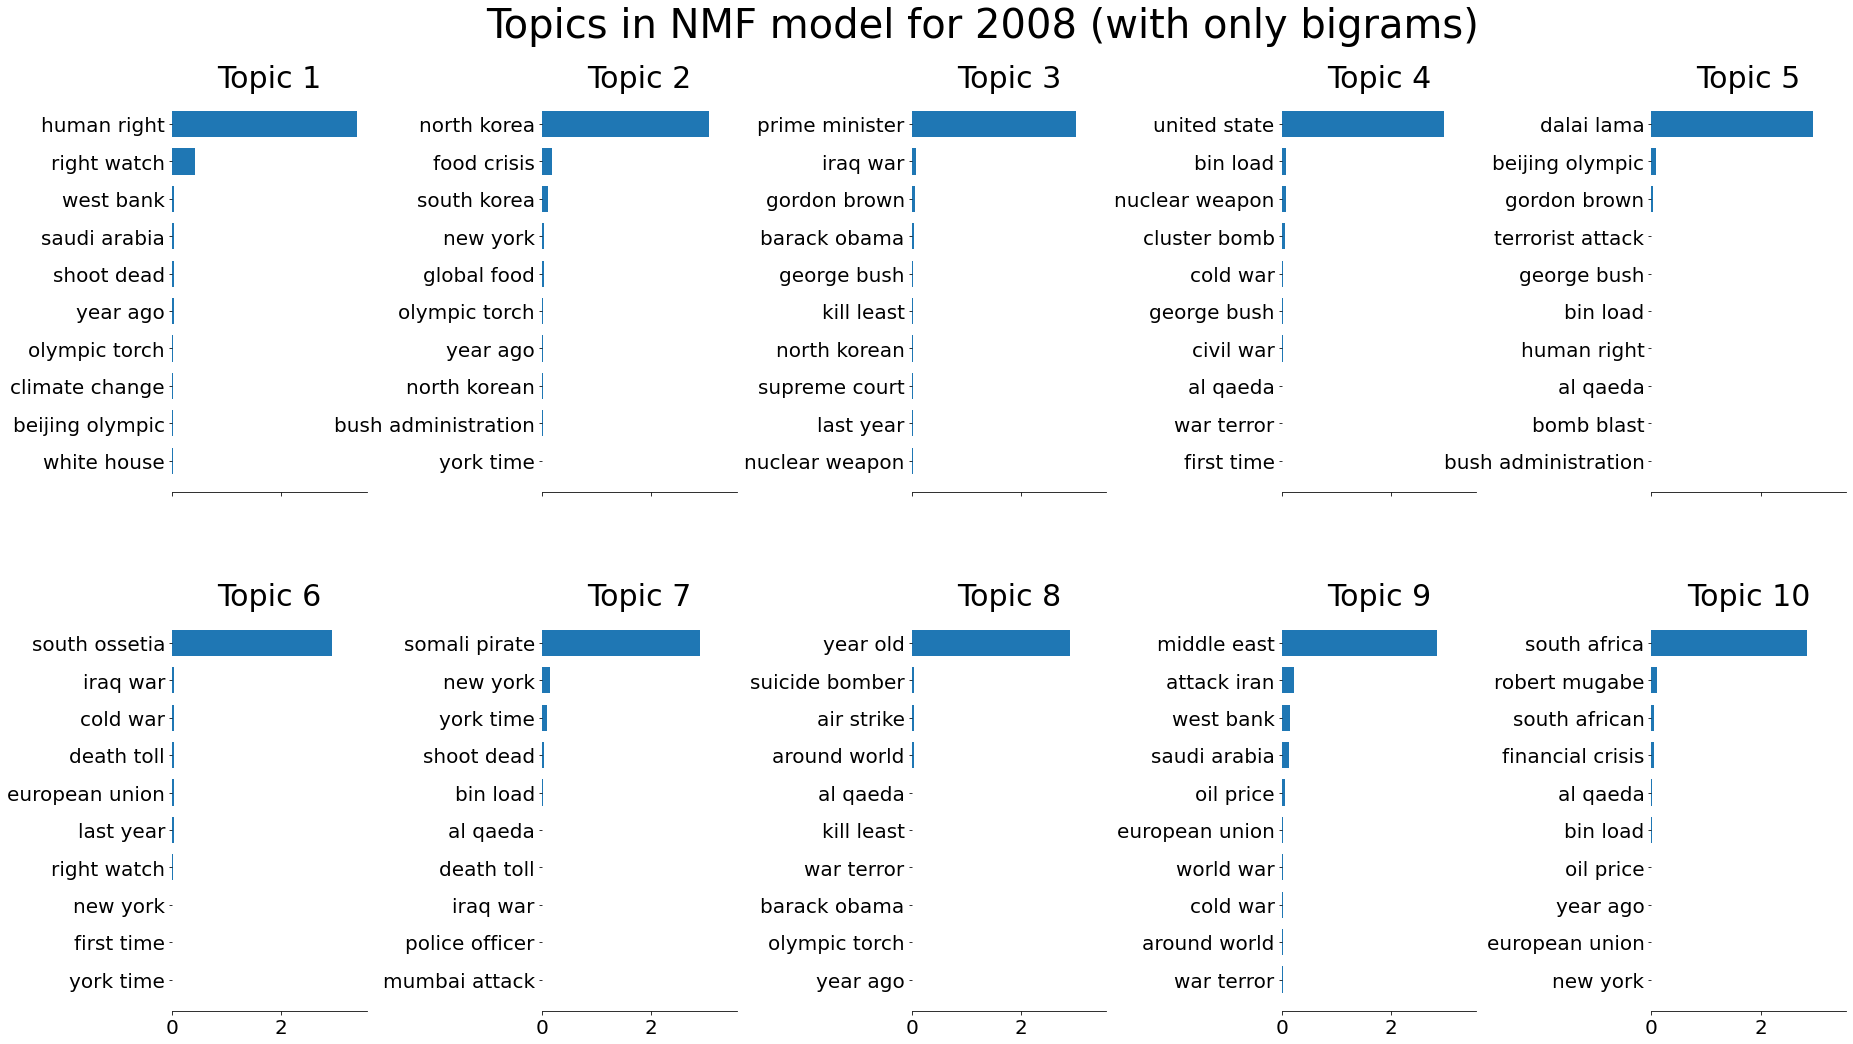

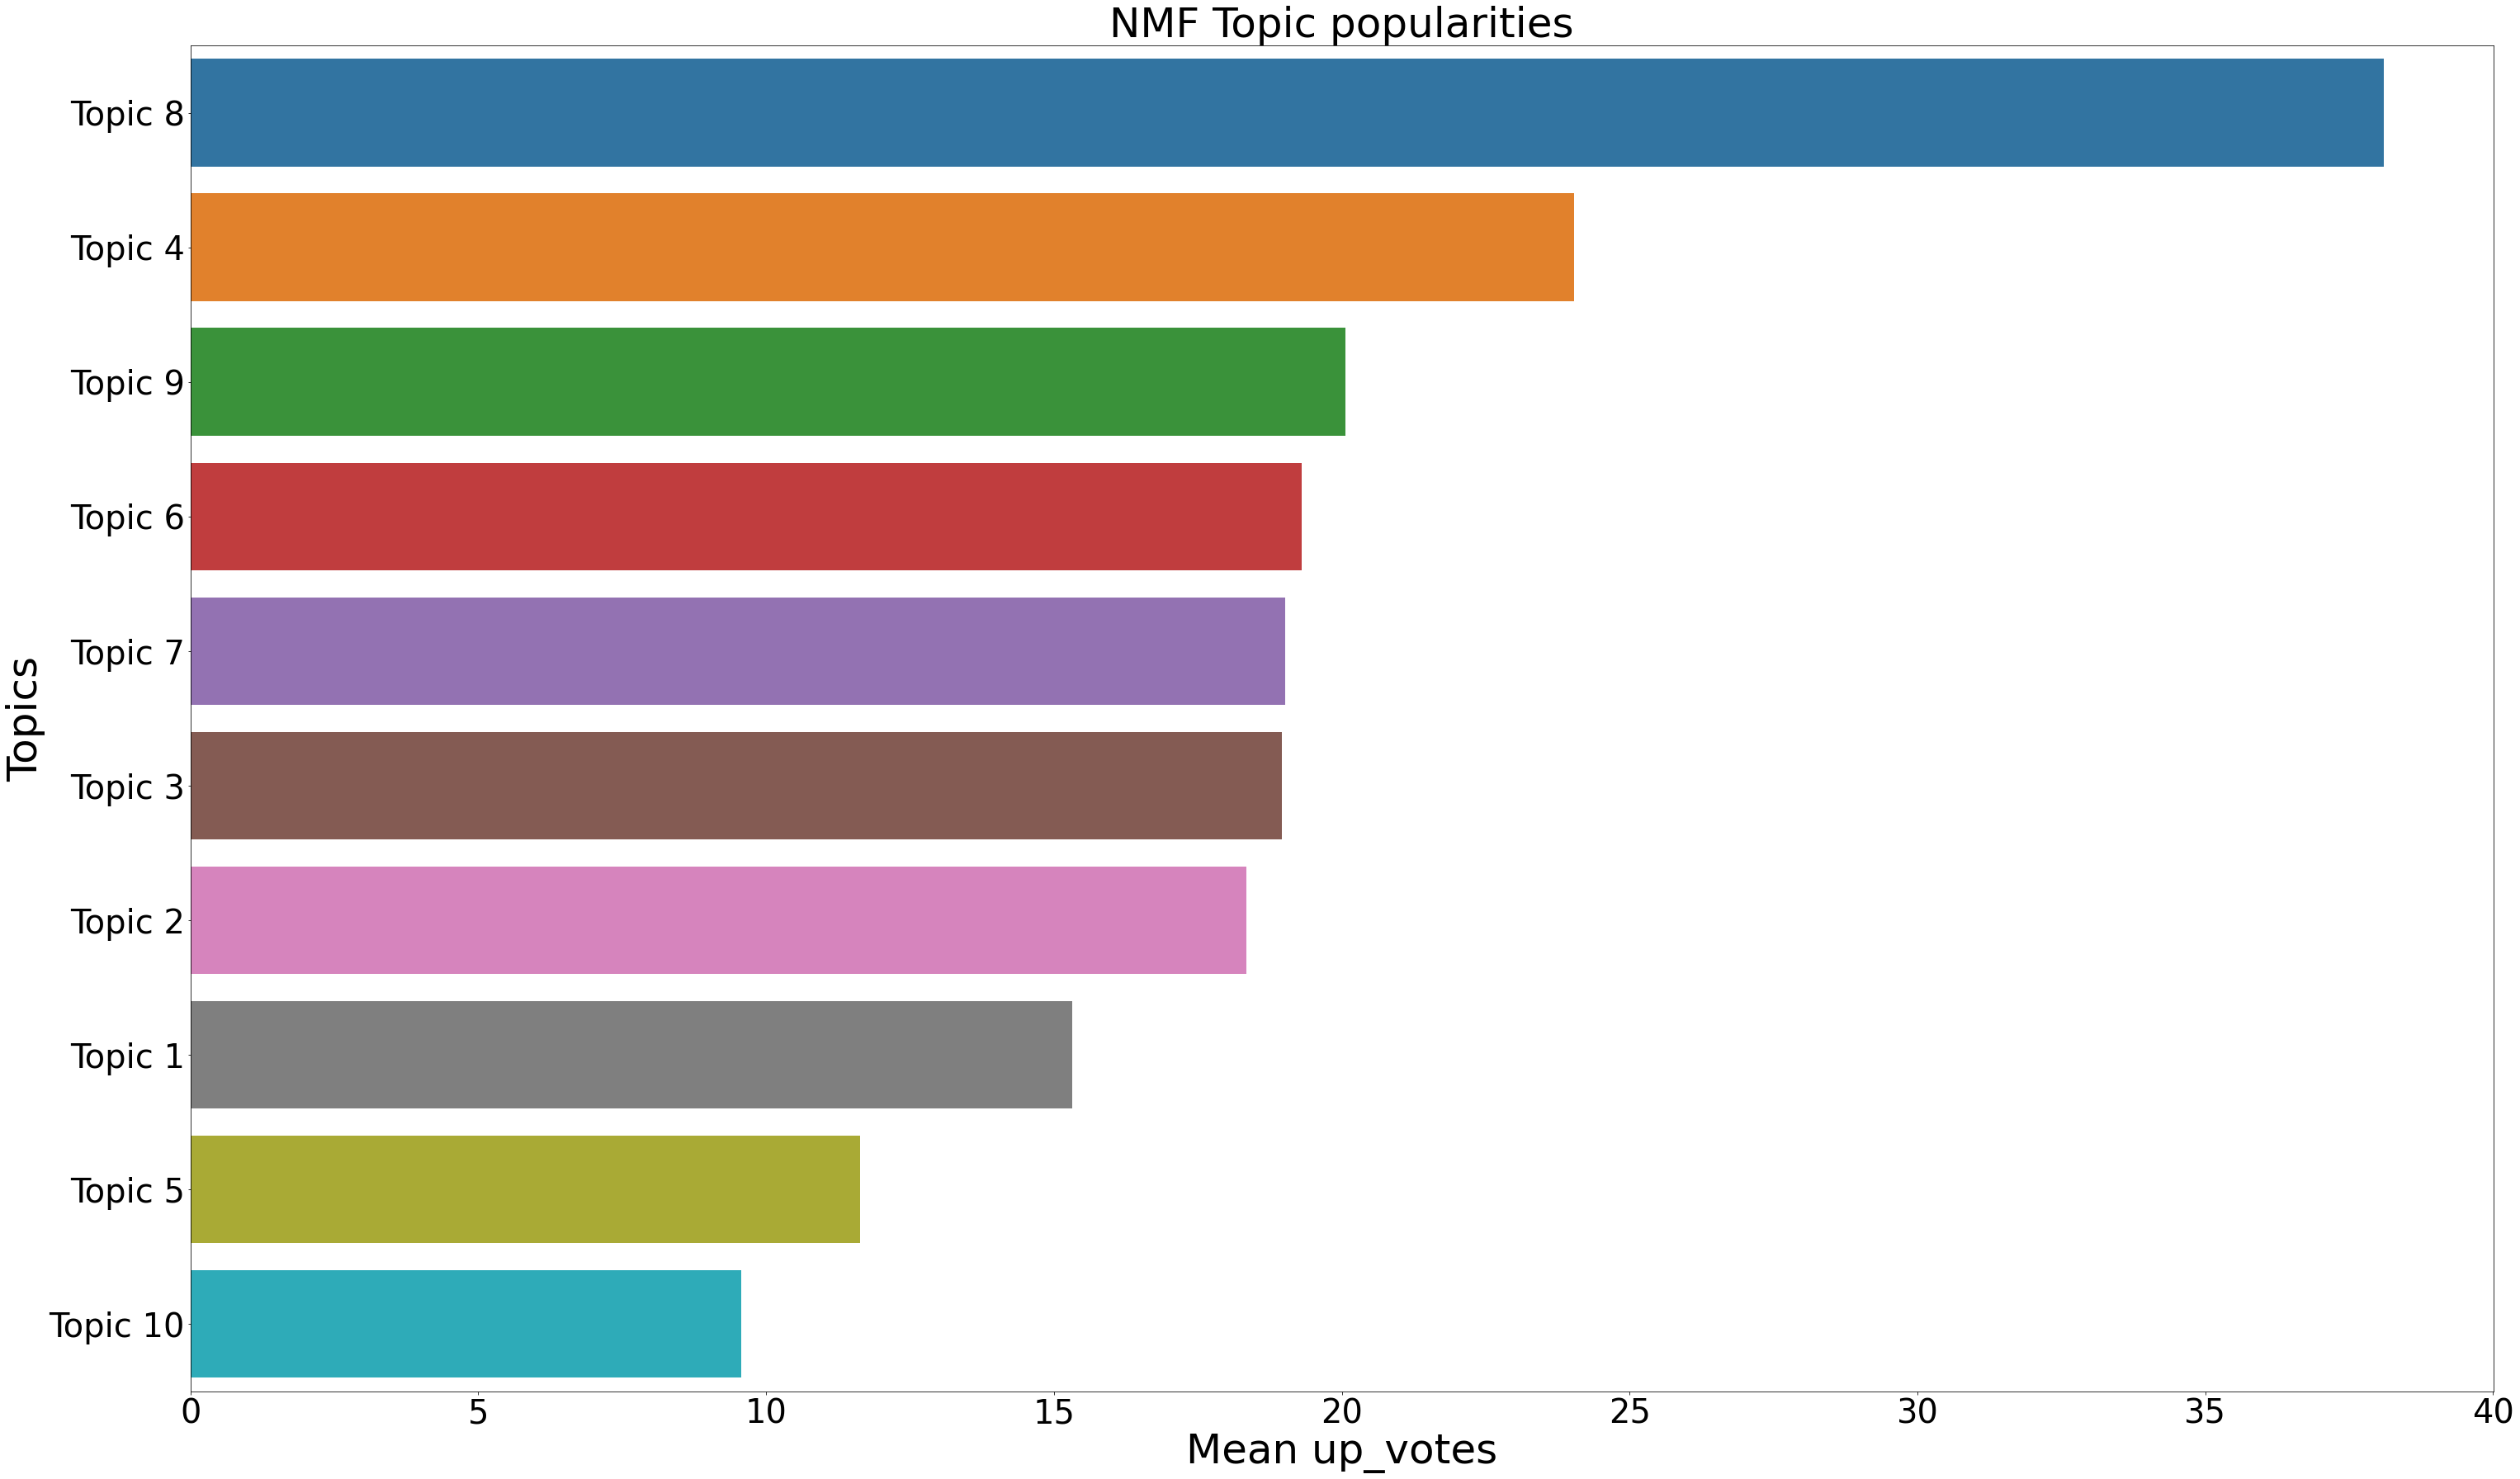

In [32]:
# Let's look at the popular bigrams only from 2008
year = 2008

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000, ngram_range=(2,2))
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==year,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=500).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {year} (with only bigrams)', year)

The way in which this is significantly different is that there aren't that many bigrams. Hence we see the bigram weights vanish almost immediately in a topic. Also bigrams tell a lot more about the topics than the unigrams on their own. For example somali and pirate occuring together clarifies the topic further. Similarly 'middle east', 'beijing olympics'. 

**Let's look at a more recent year - 2016**

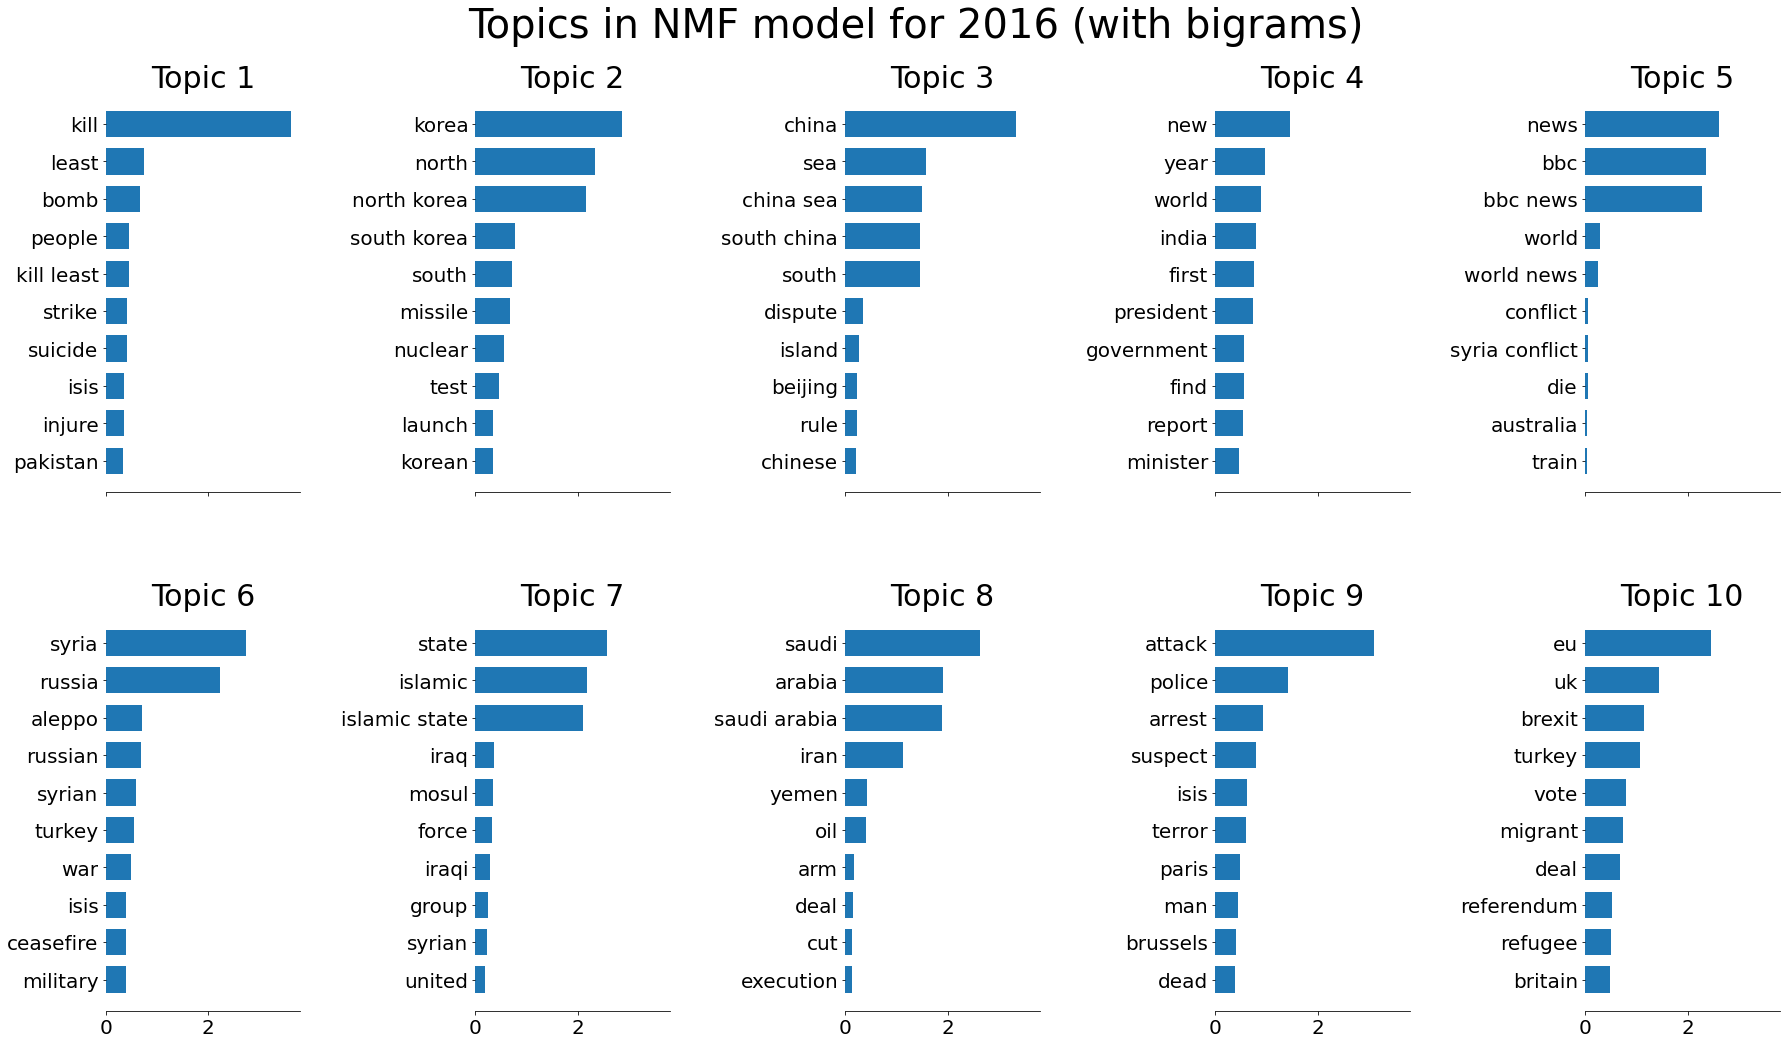

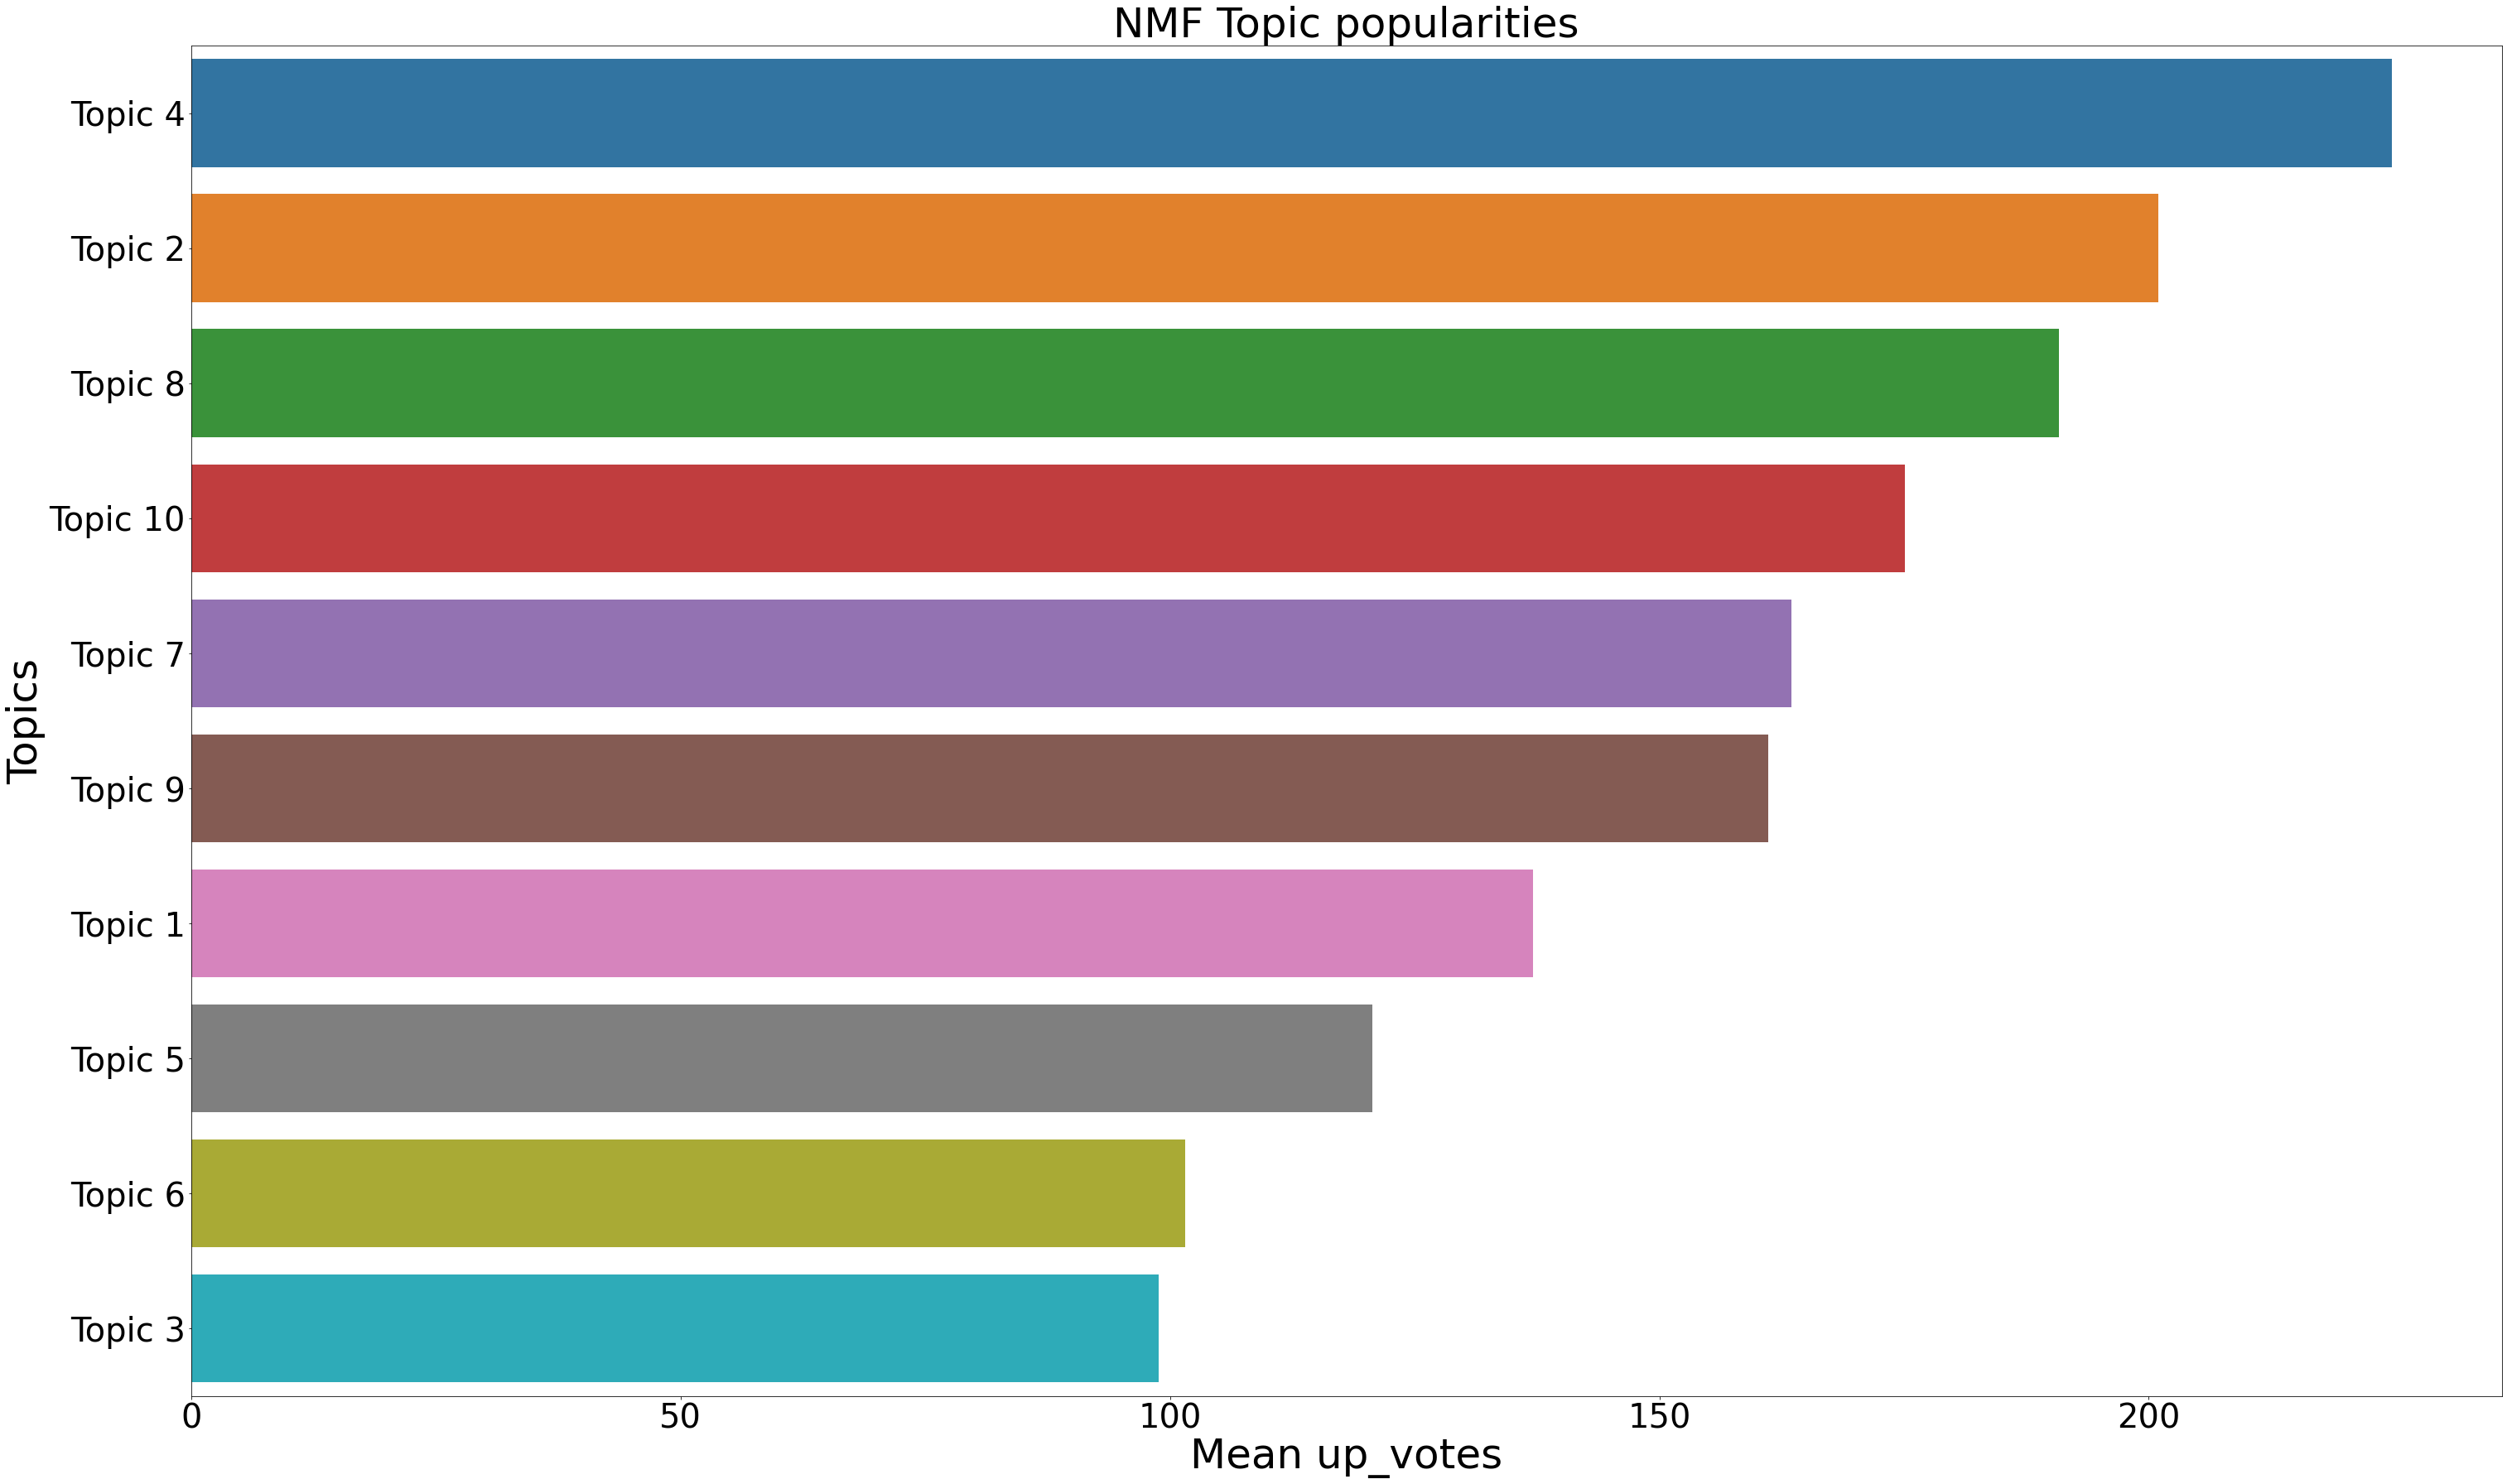

In [33]:
year = 2016

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000, ngram_range=(1,2))
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==year,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=500).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {year} (with bigrams)', year)

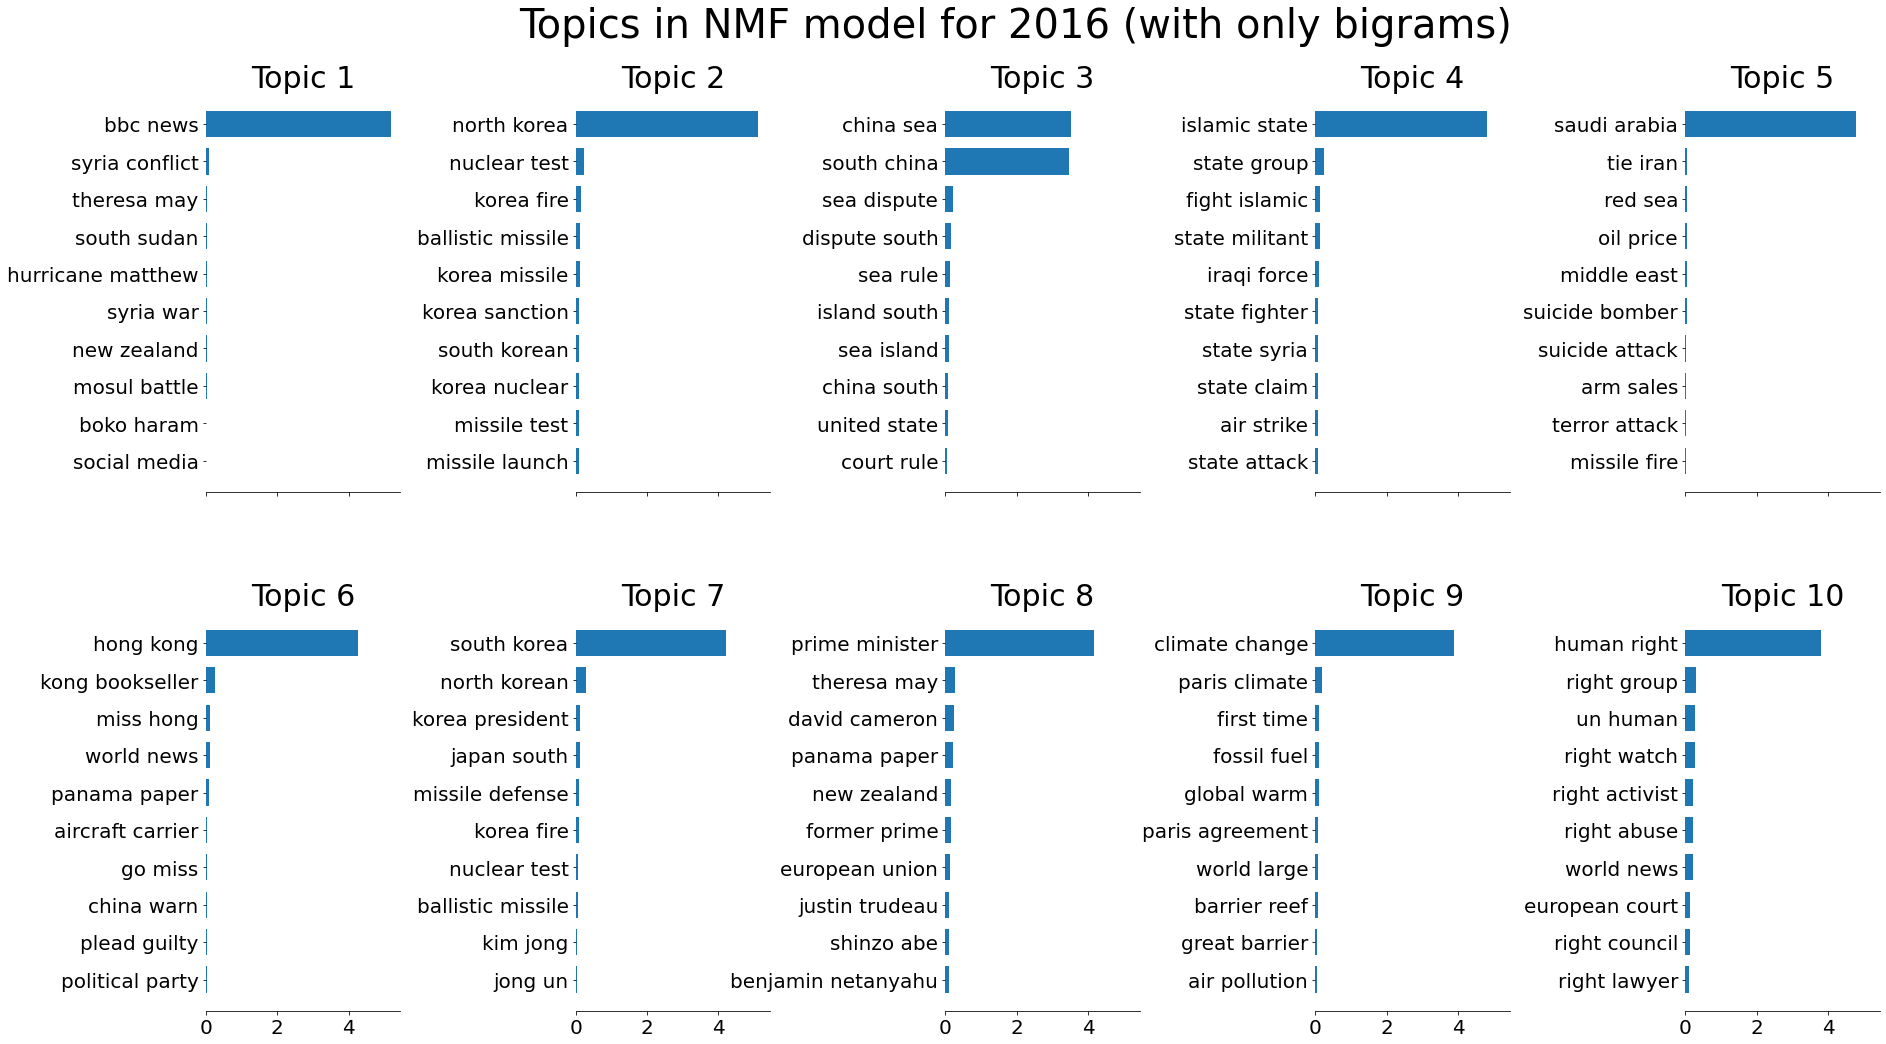

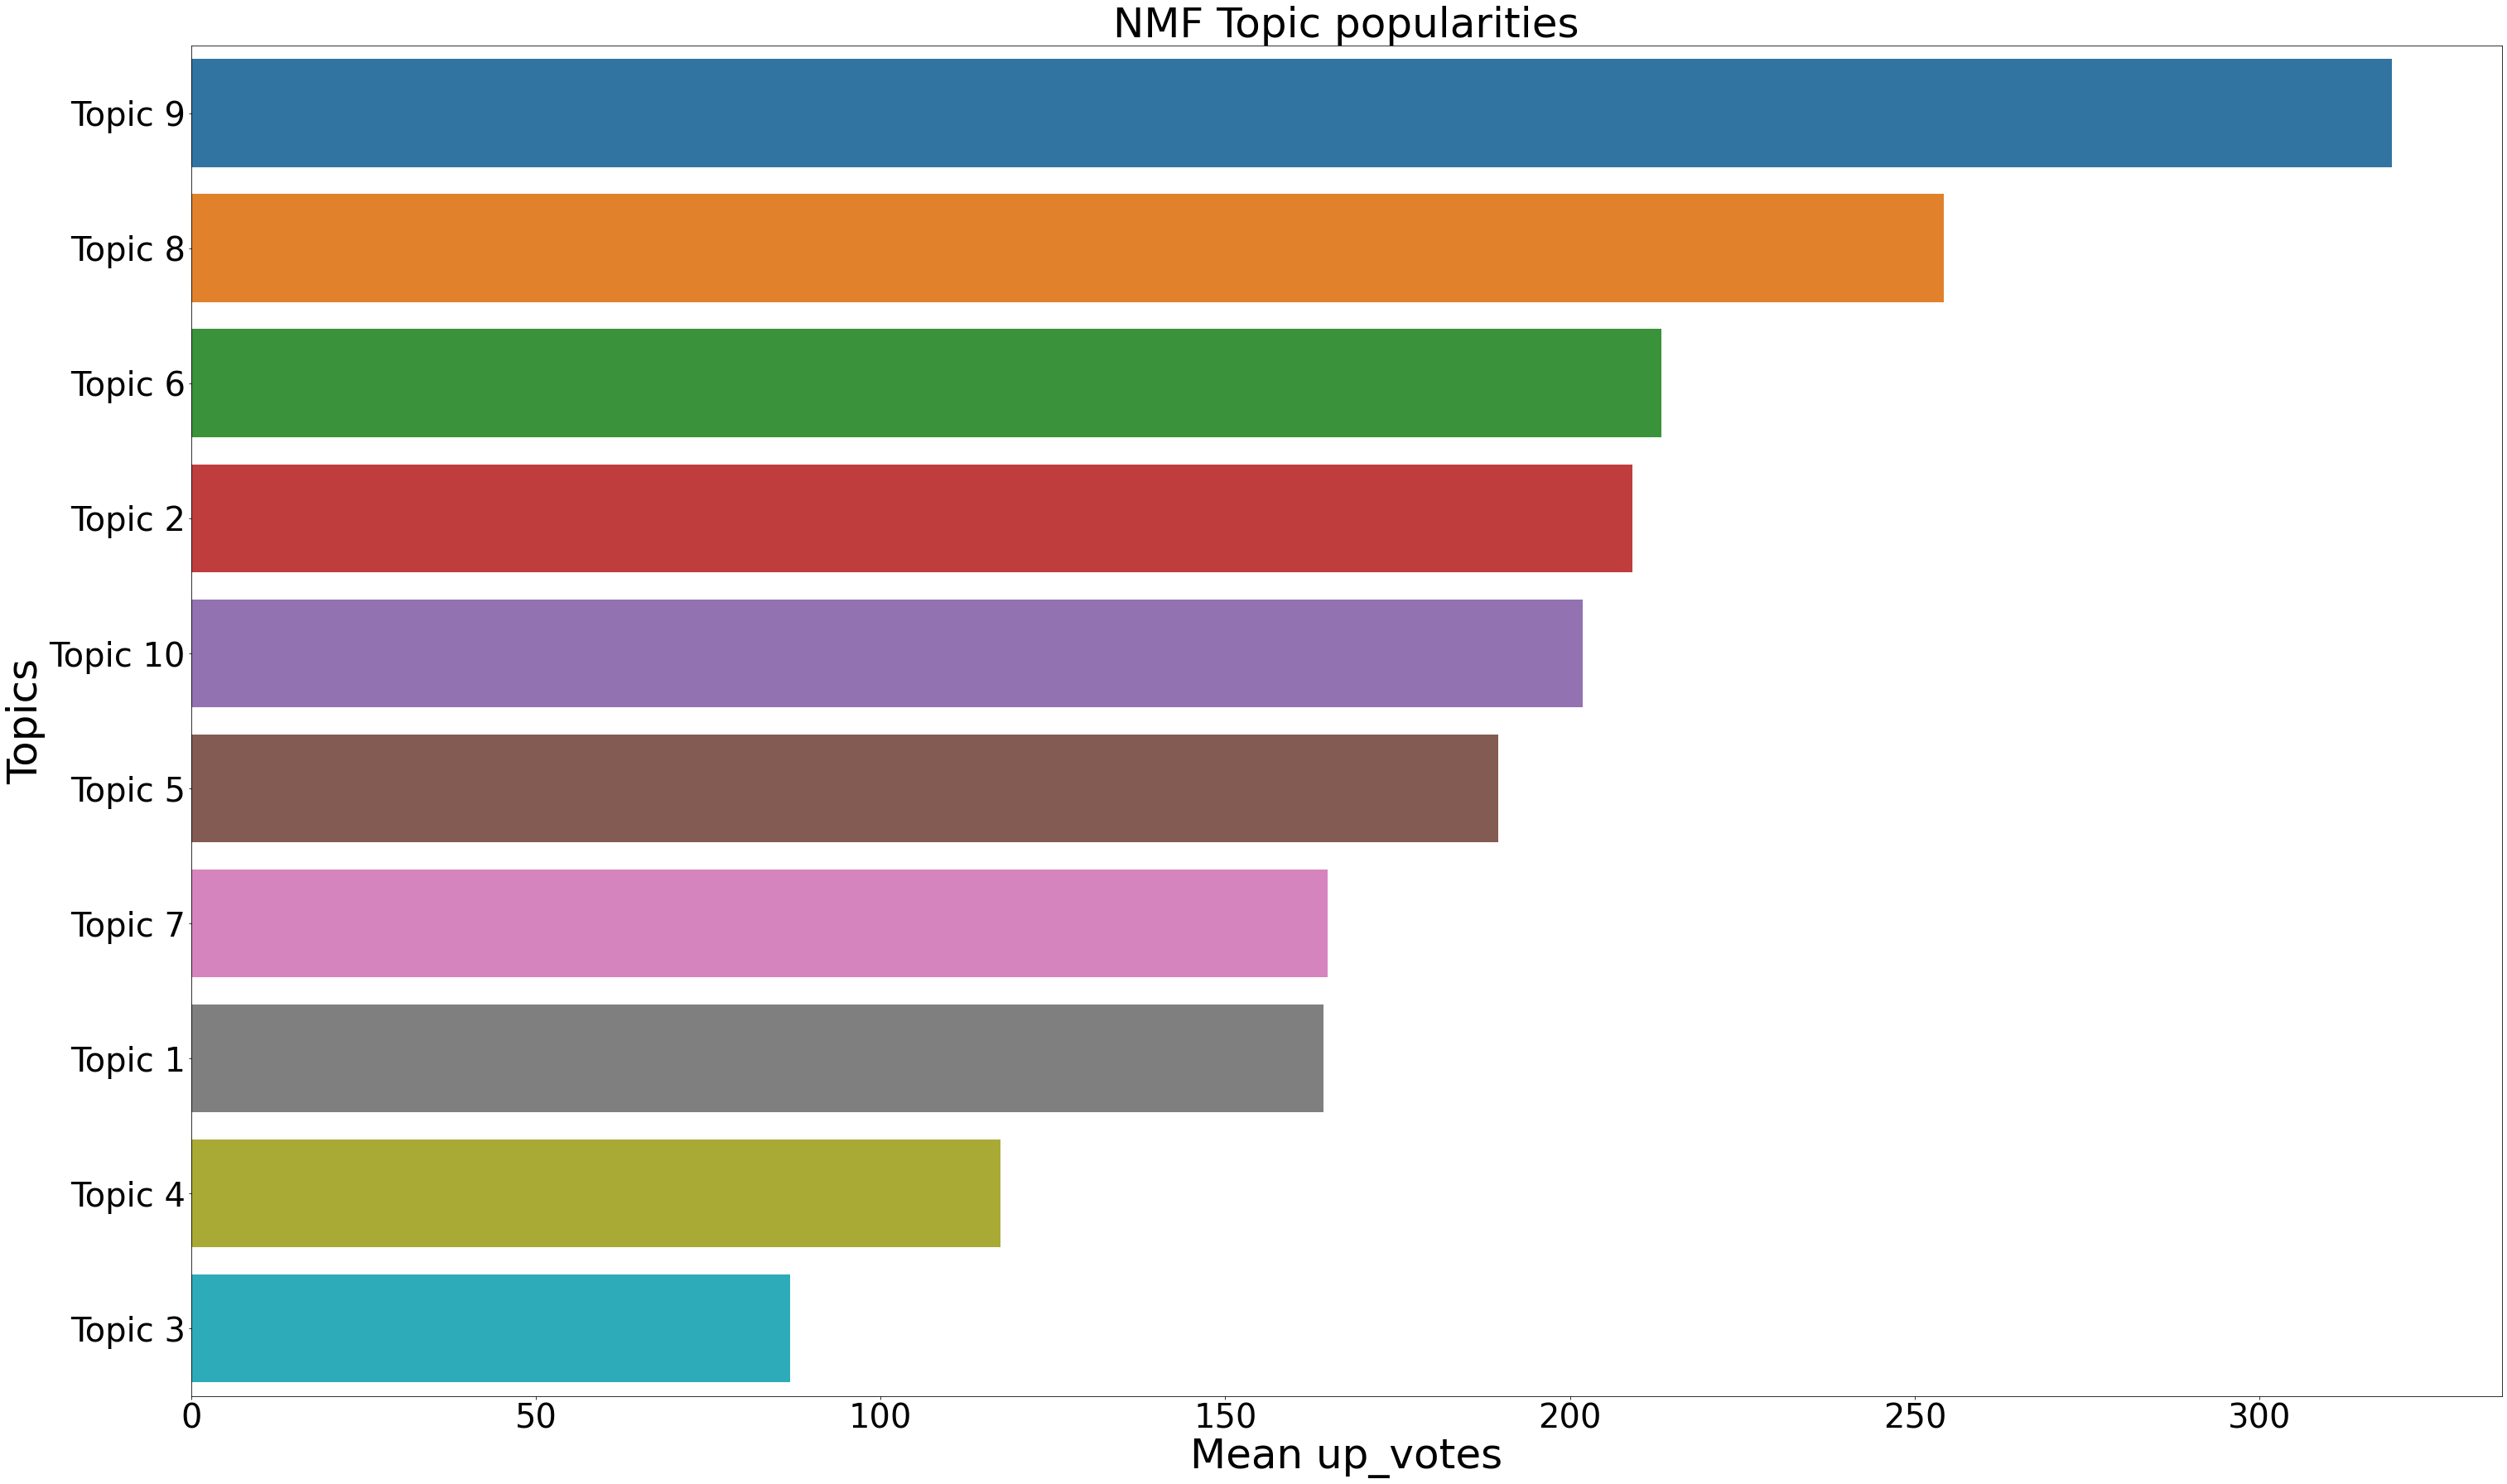

In [34]:
# Let's look at the bigrmas only
year = 2016

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000, ngram_range=(2,2))
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==year,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=500).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {year} (with only bigrams)', year)

**This is really interesting now !** We have some new topics altogther for example the one on climate change (topic 9) and if you carefully look at the other bigrams in the topic, they are all related to the topic of climate change. And on top of that, it has the highest average upvotes which is significantly higher that any of the other topics considered in the unigrams sections. Sometimes for the unigrams, even if they end up with a high weightage, they don't necessarily convey anything meaningful instead they end up clouding some of the other important topics that can only be expressed by bigrams.

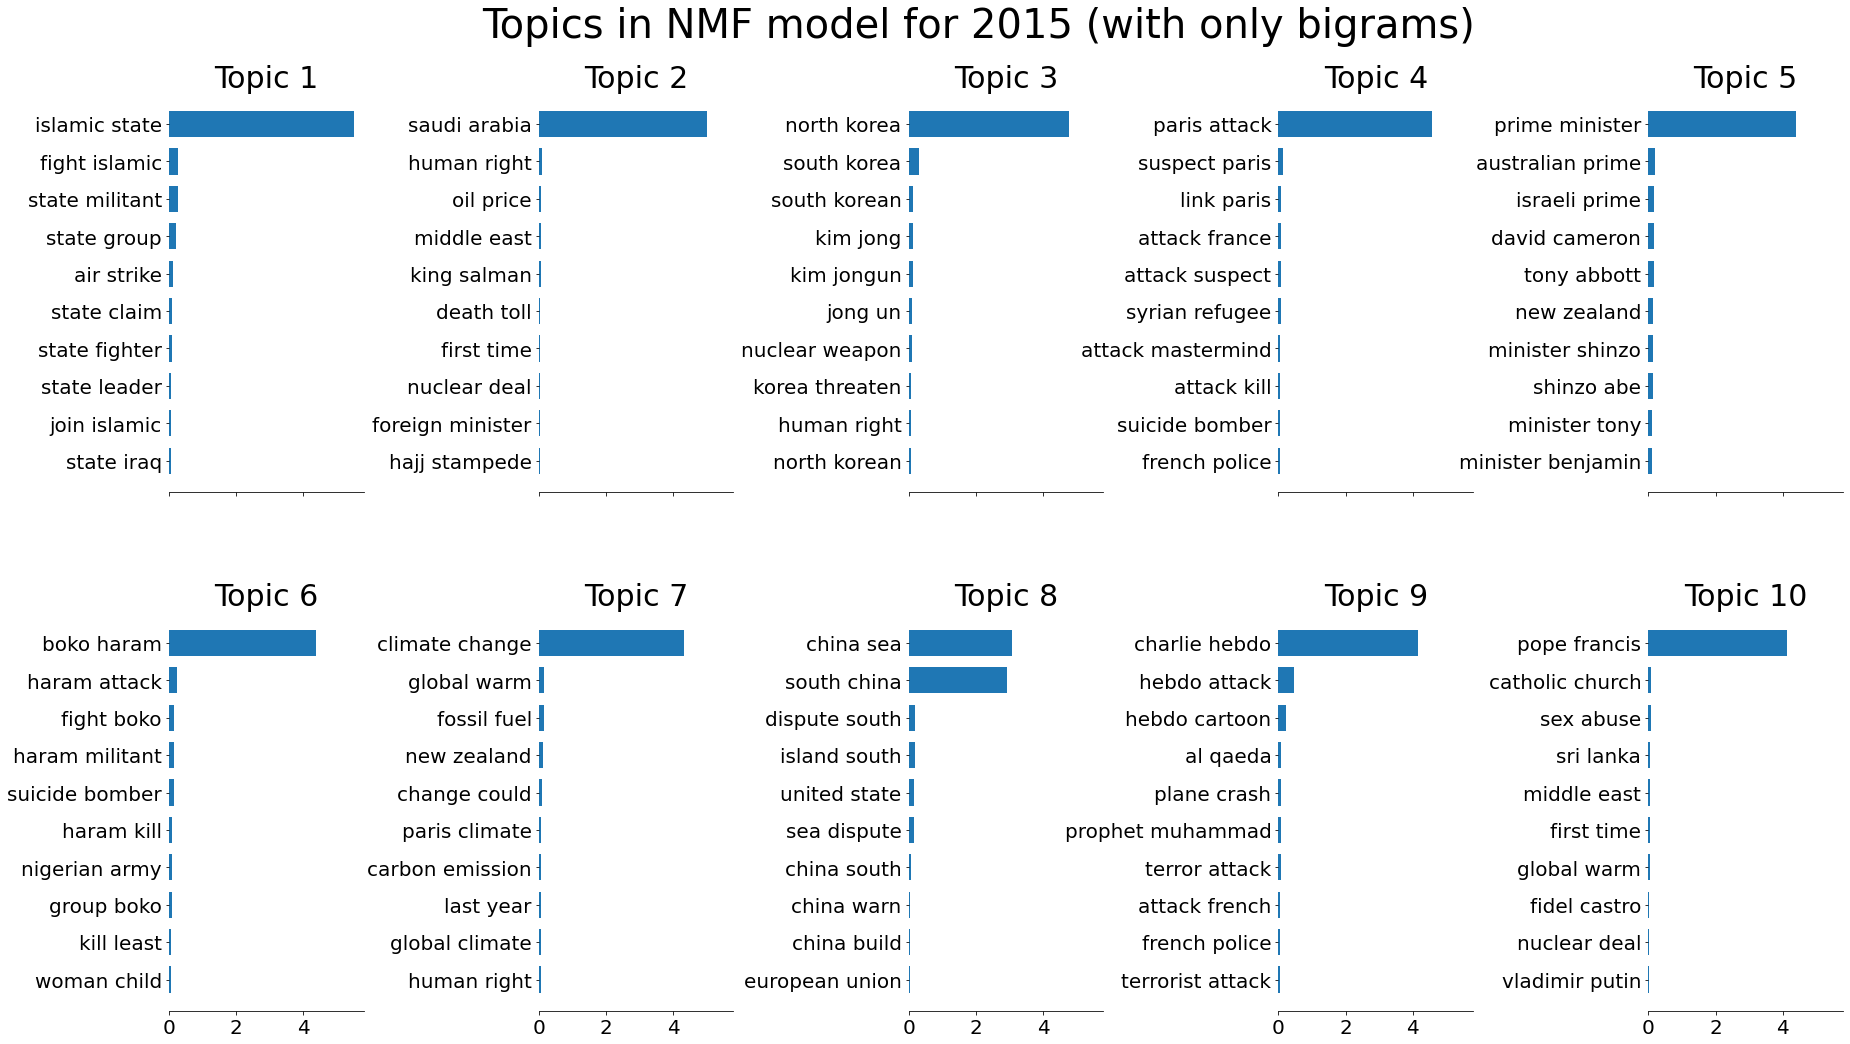

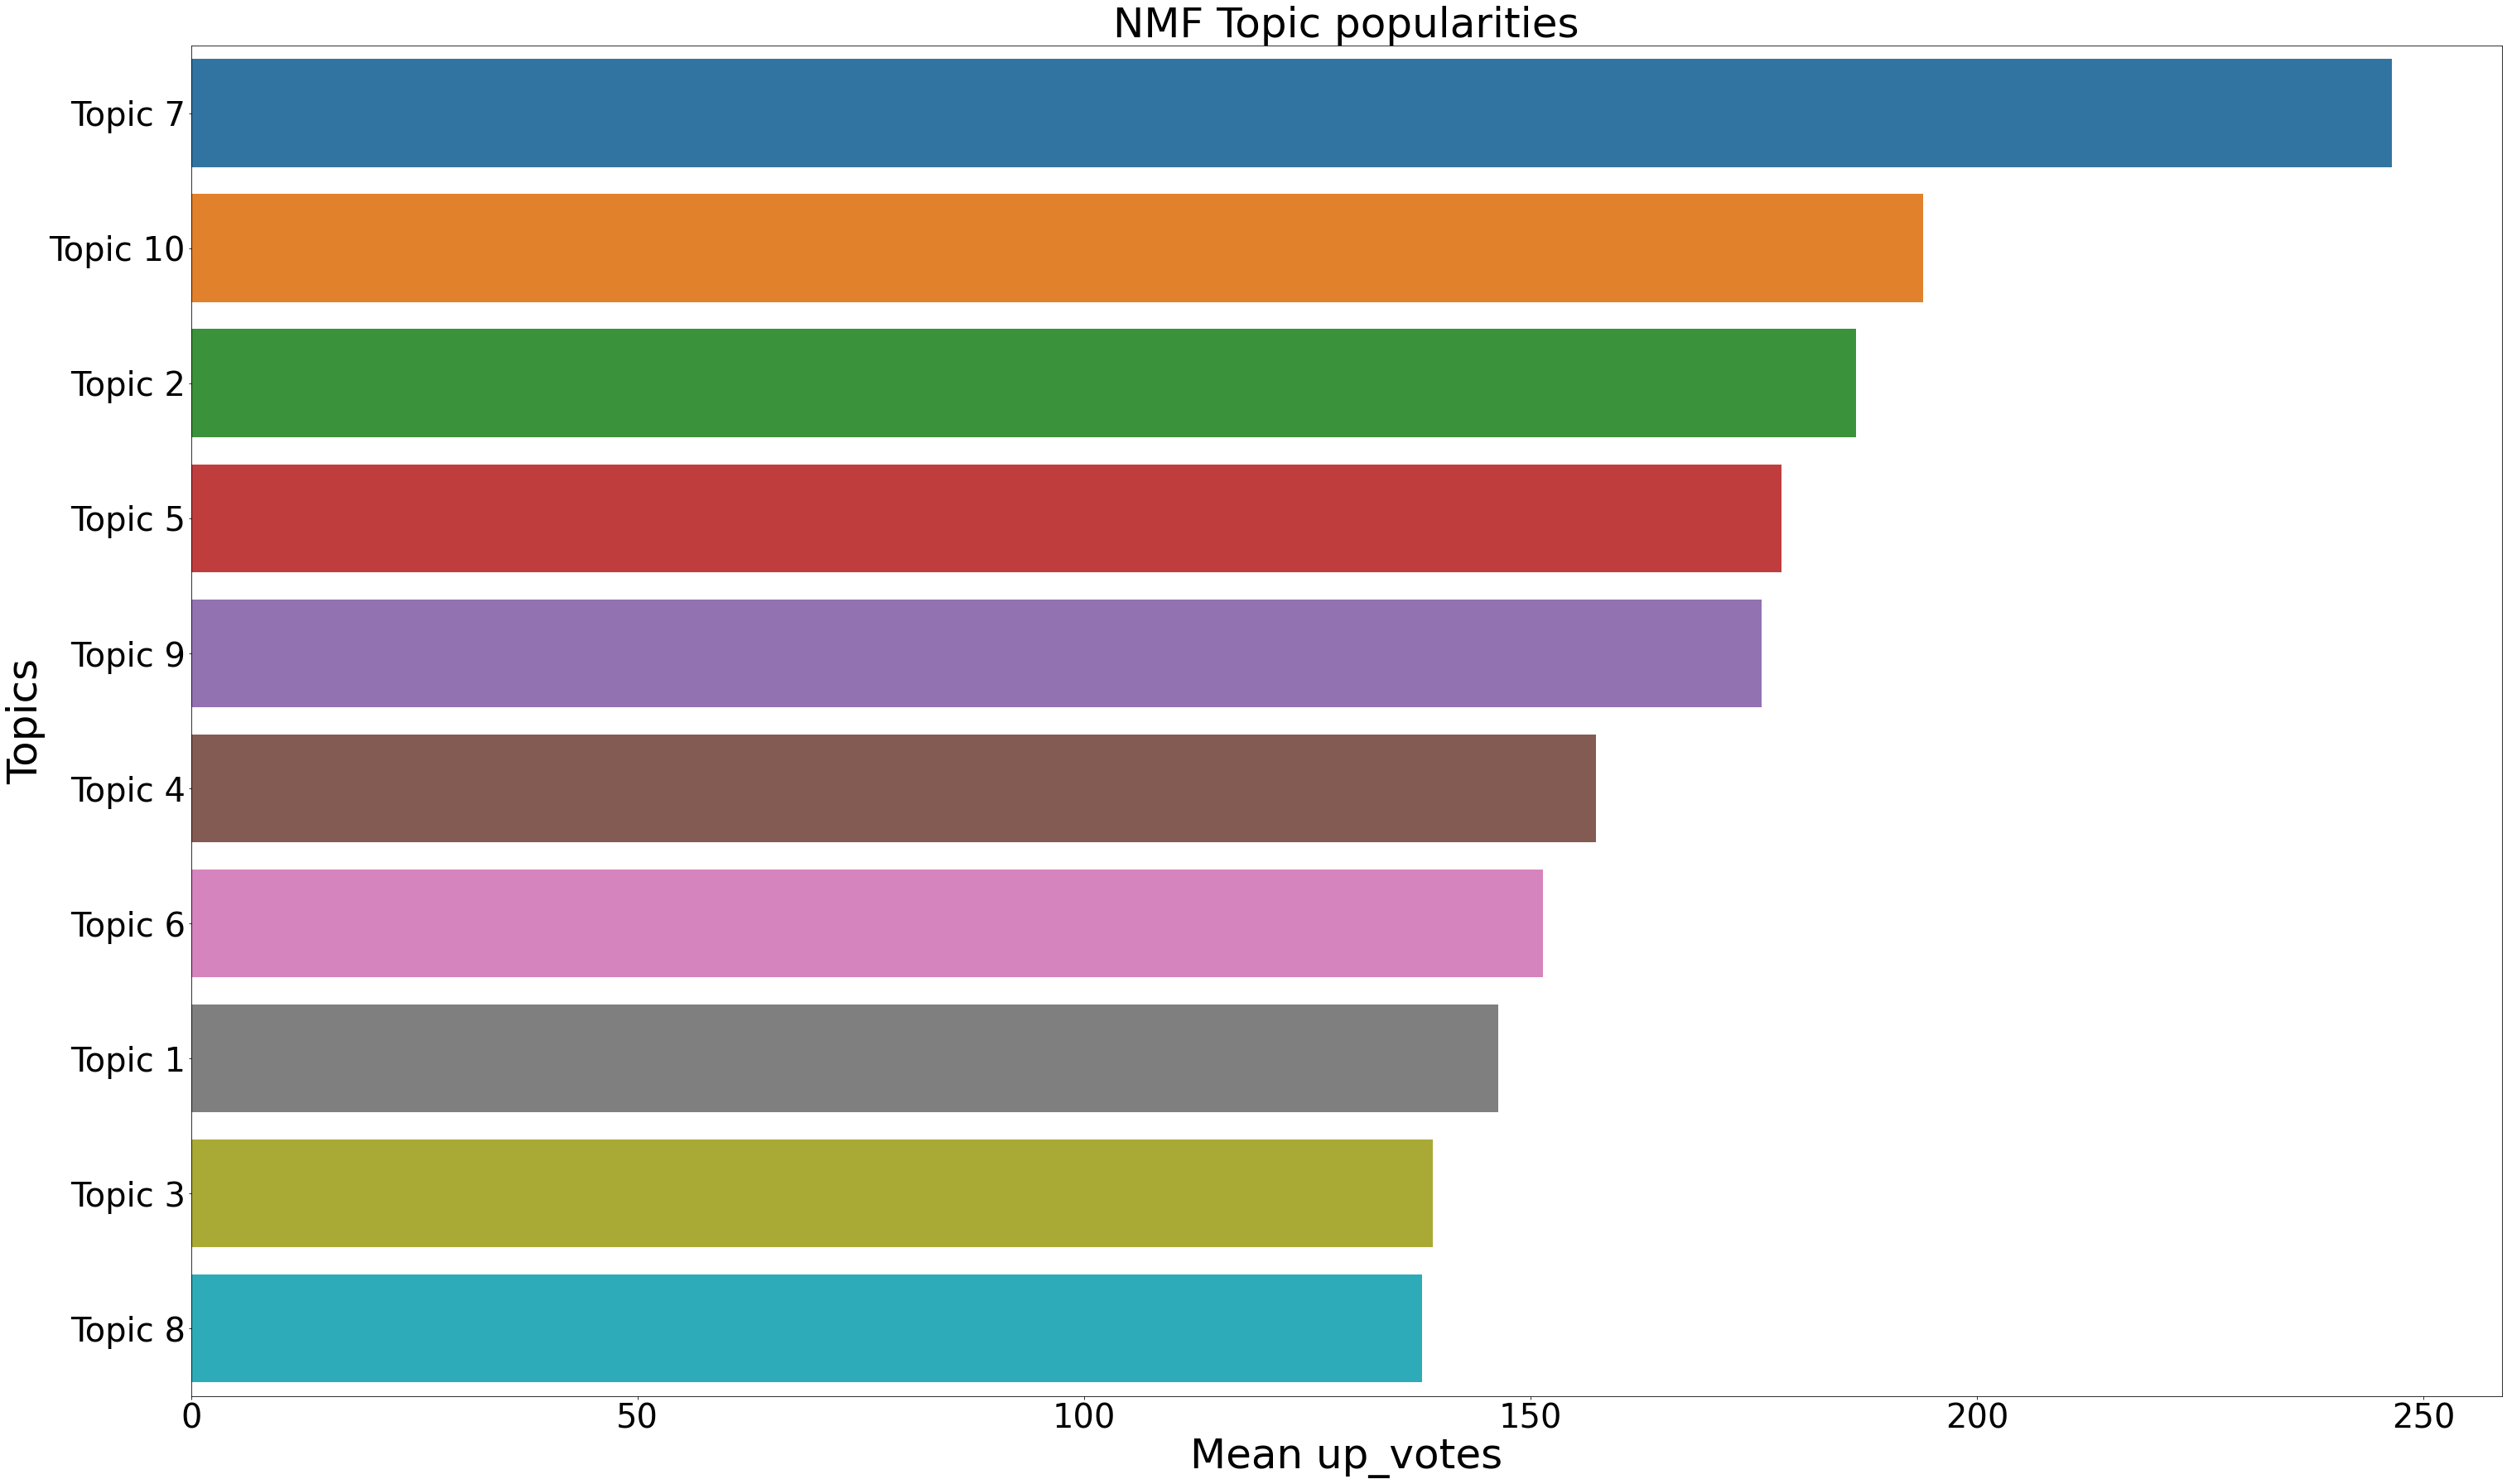

In [35]:
# Let's continue this analysis for 2015 and look at only bigrams
year = 2015

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000, ngram_range=(2,2))
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==year,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=500).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {year} (with only bigrams)', year)

Apart from some similar news from 2016 (which is expected), we have some new ones never seen in the unigrams analysis - **boko haram** and **charlie hebdo**.  

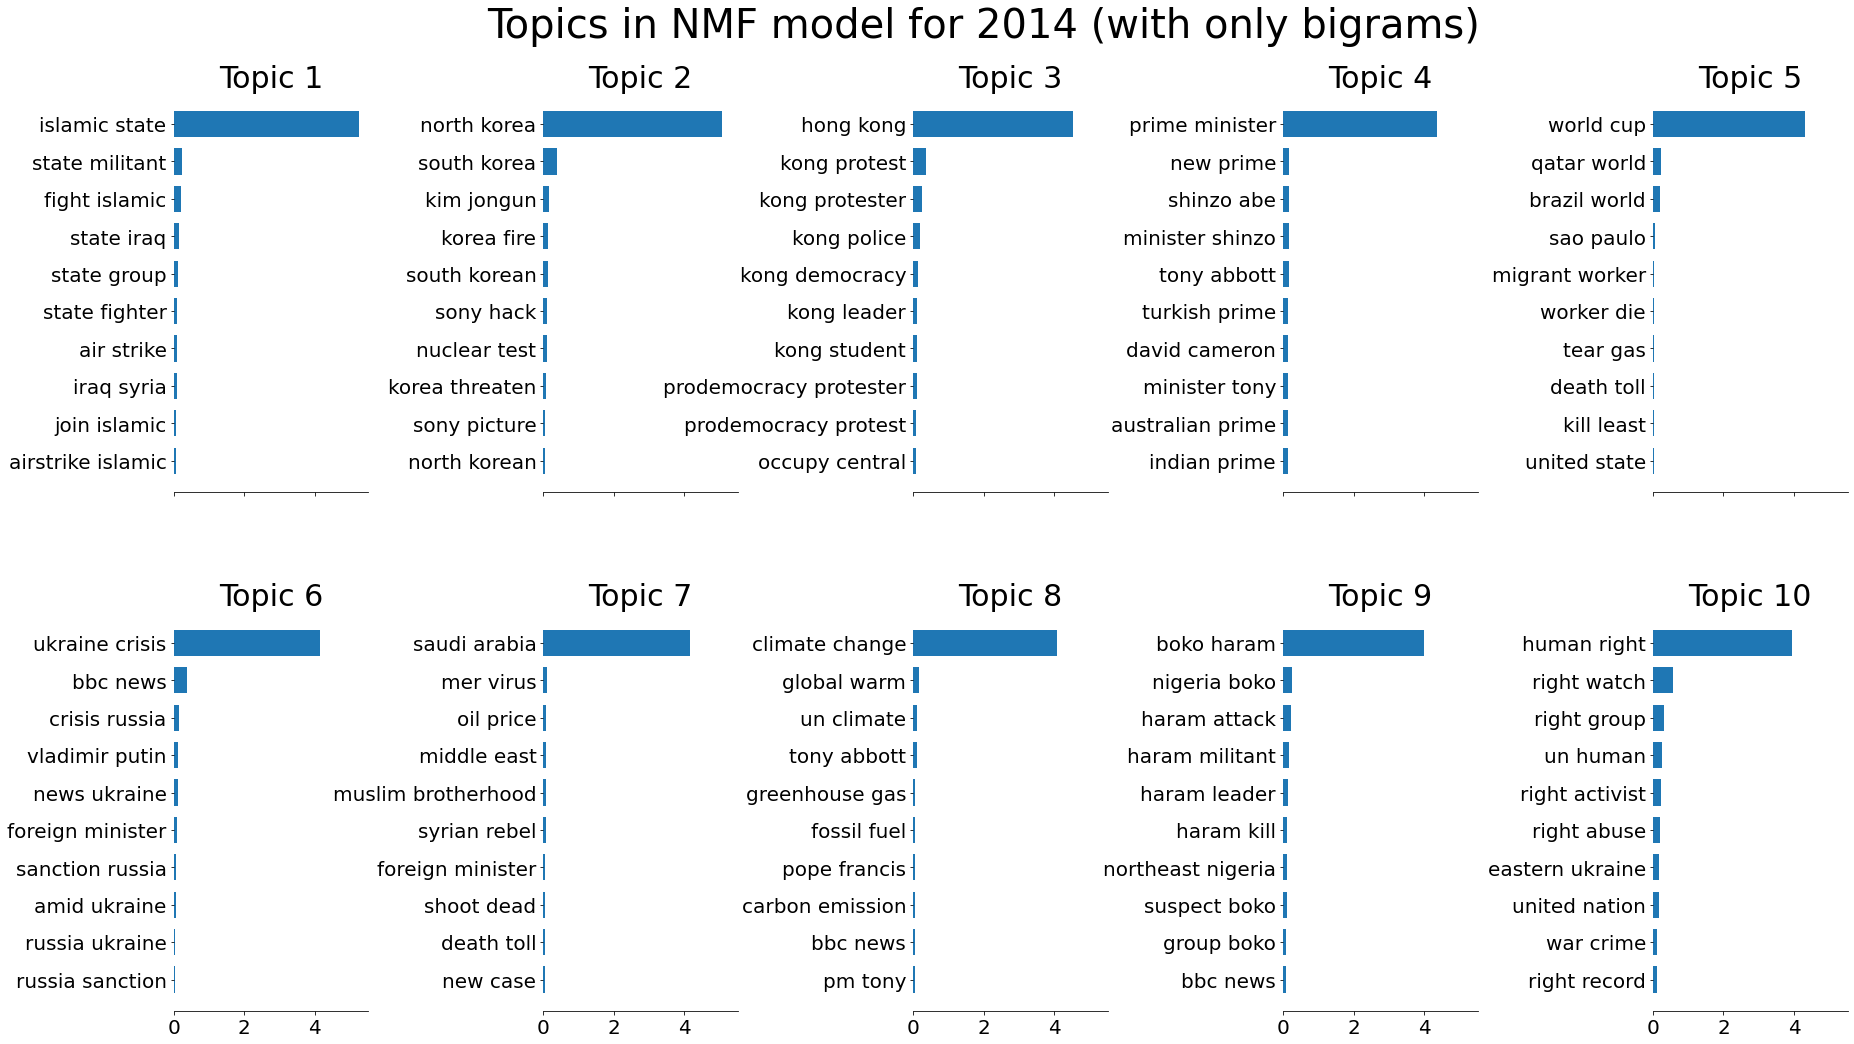

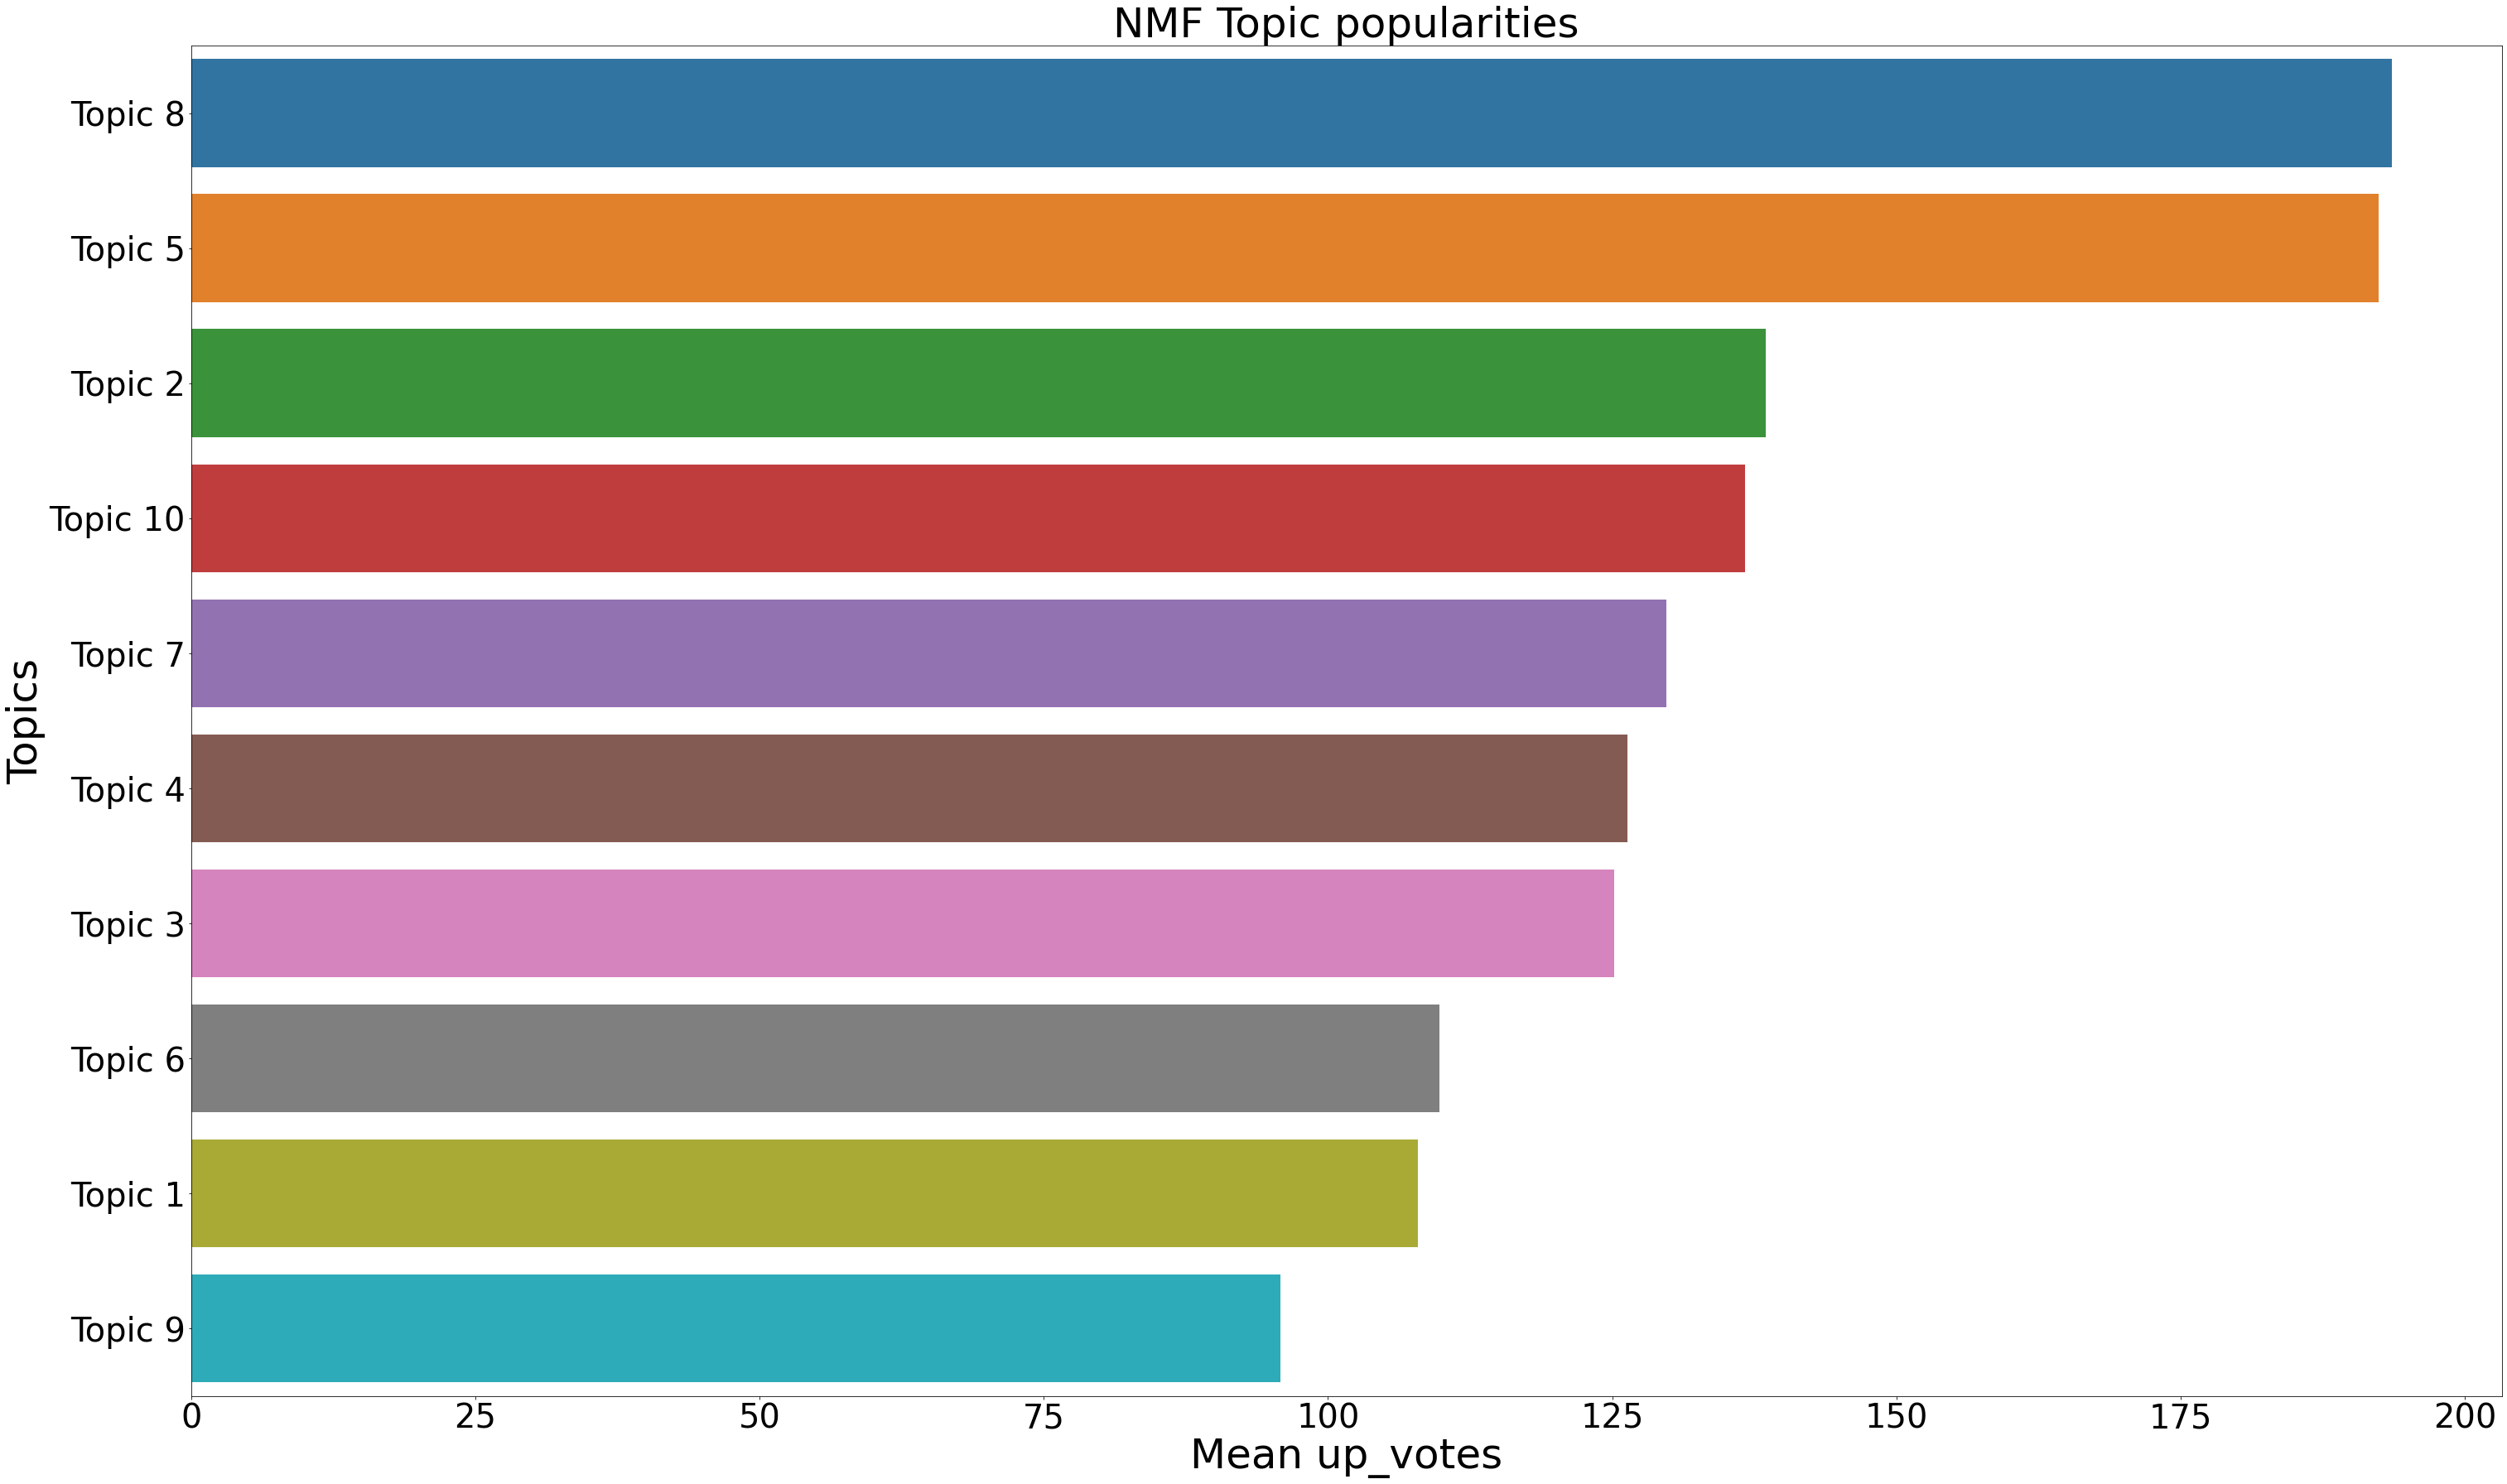

In [36]:
# 2014 men's soccer word cup in Brazil pops out with the bigram analysis
year = 2014

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000, ngram_range=(2,2))
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==year,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=500).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {year} (with only bigrams)', year)

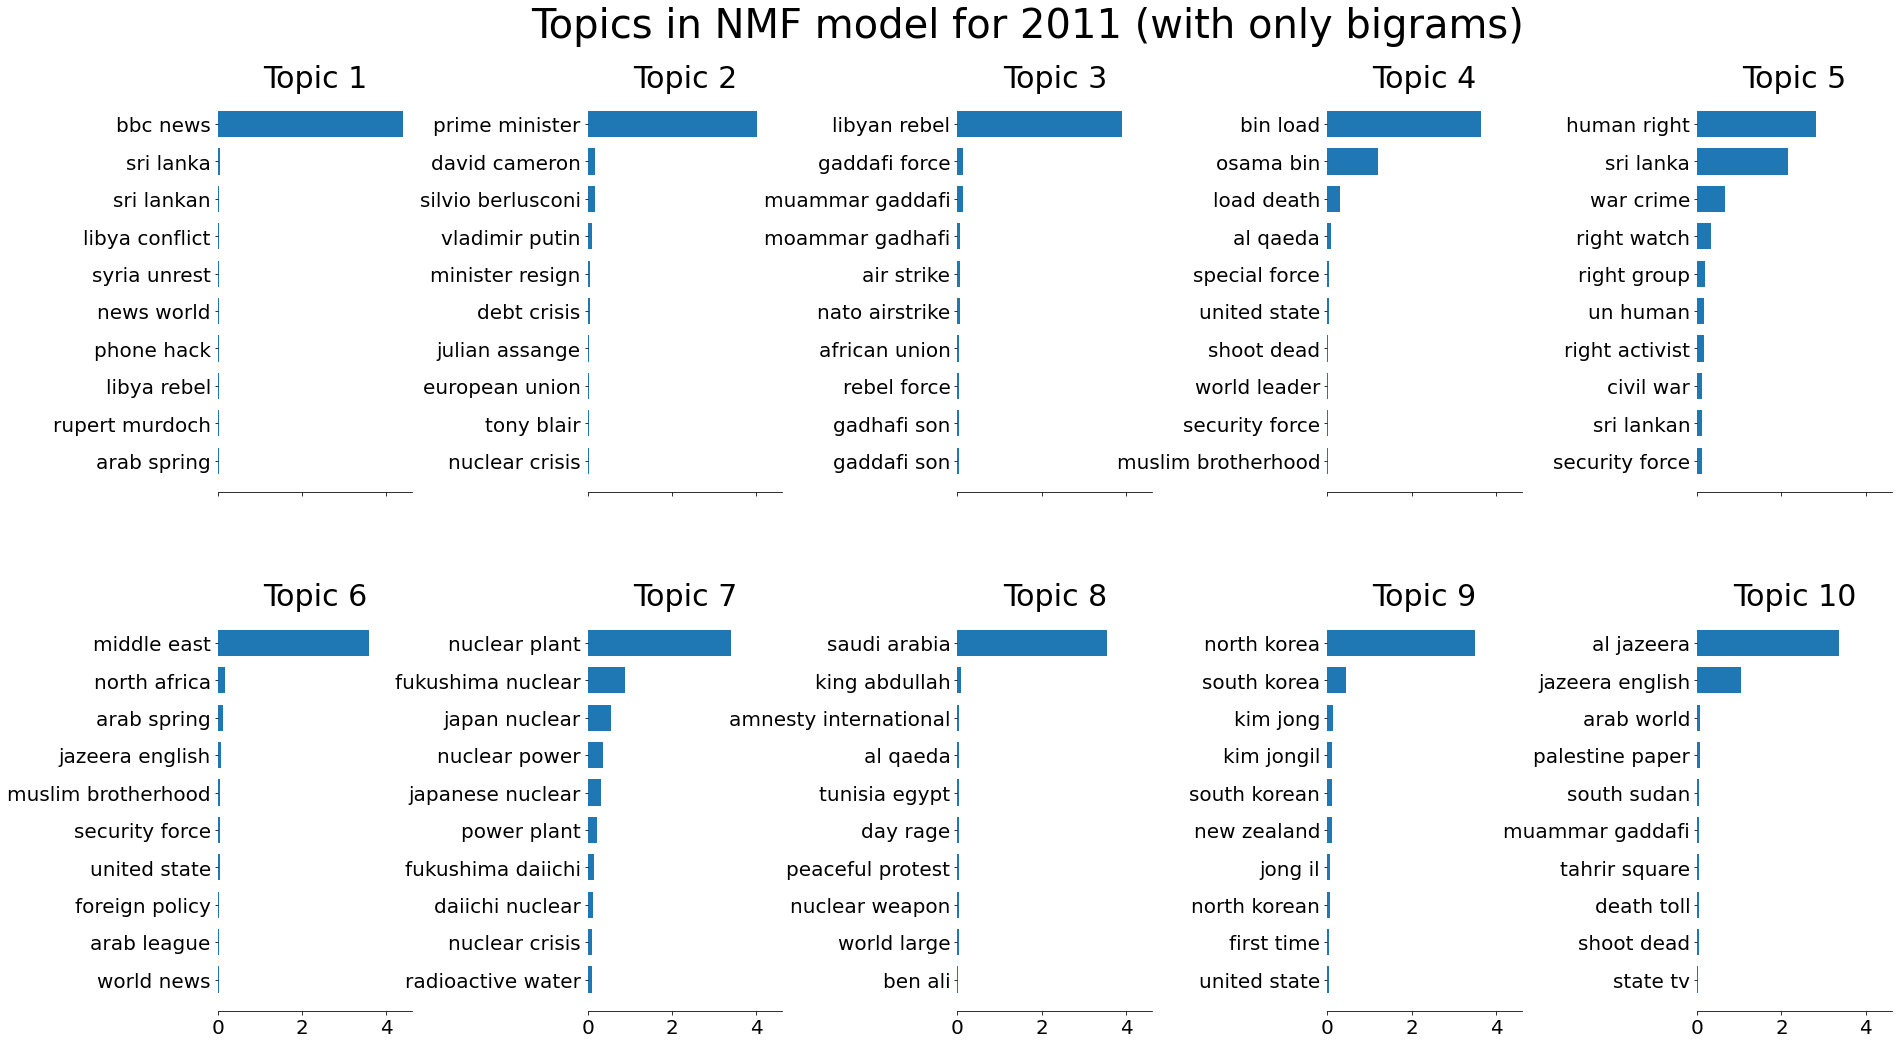

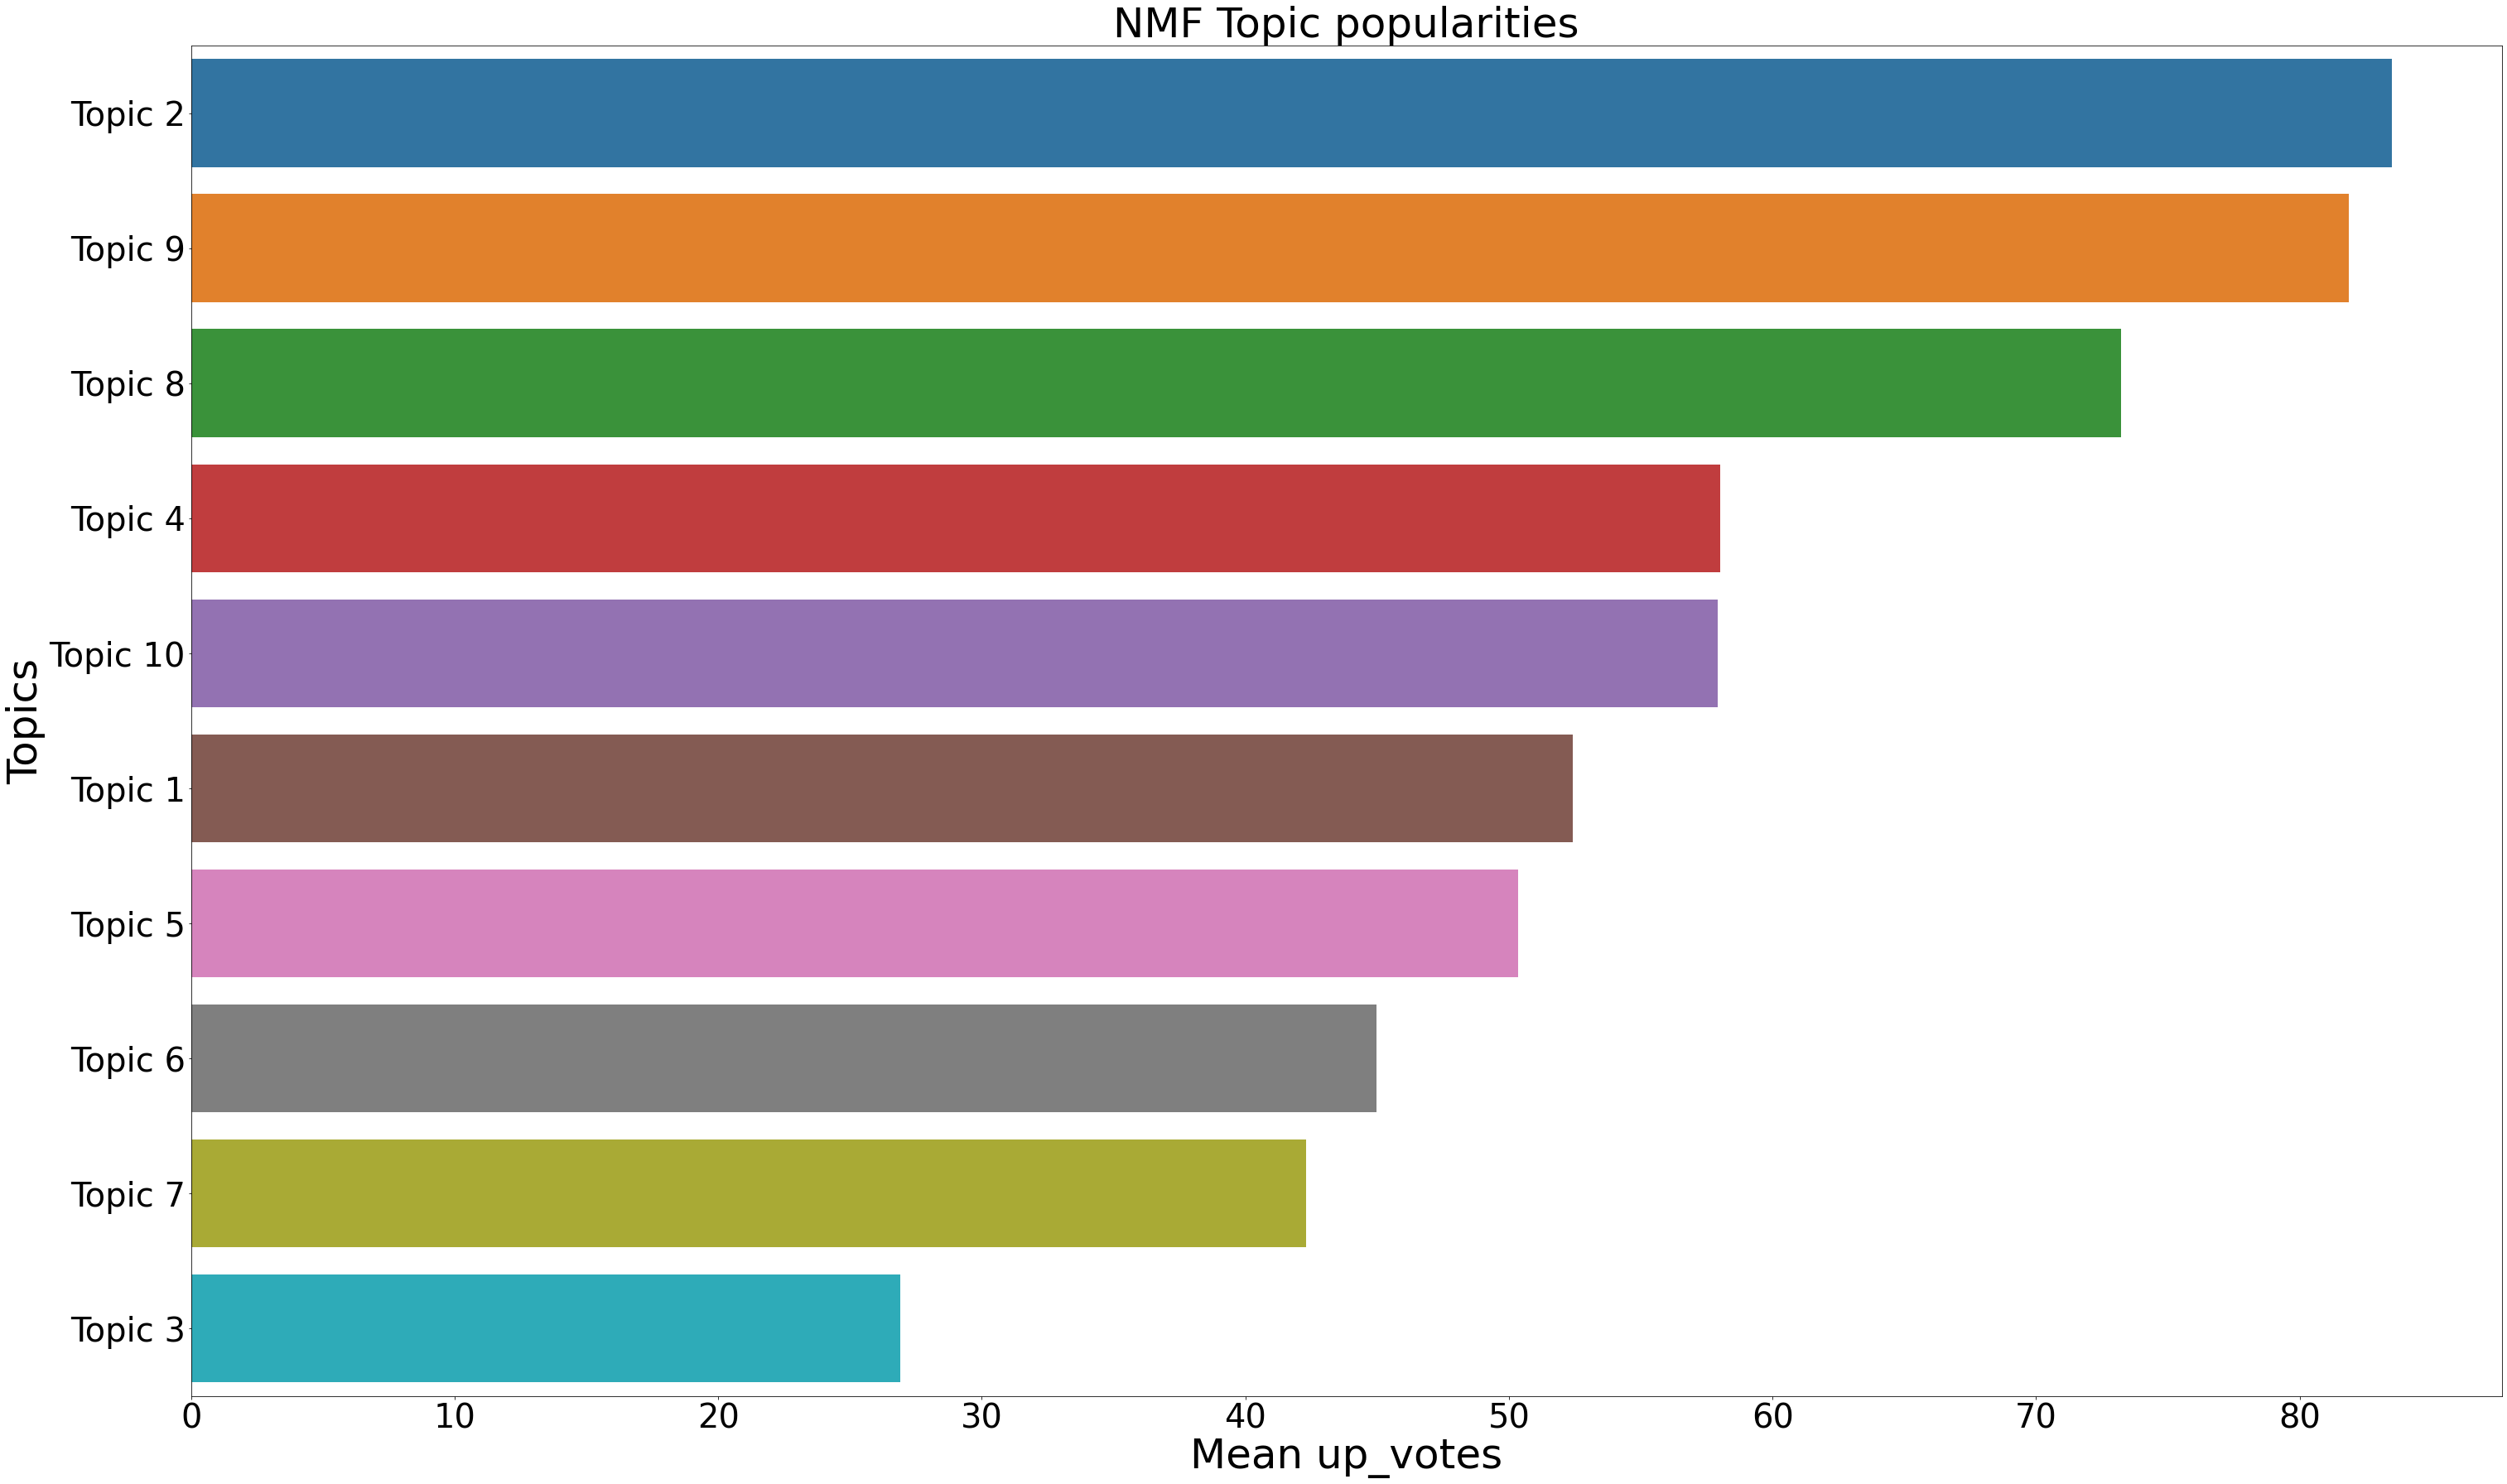

In [37]:
# Let's look at a year we haven't explored before.
# News of osama bin laden's being shot dead in 2011
year = 2011

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000, ngram_range=(2,2))
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==year,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=500).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {year} (with only bigrams)', year)

**So the basic takeaway here is to analyize different n_grams to extract all possible and equally important information from a dataset like this.**

## How about the authors of the articles?

Now we could use the same functions to charcterize the authors by looking at the kind of news they cover.

In [38]:
def plot_popular_topics_by_author(nmf, tfidf_feature_names, n_top_words, title, author):
    
    plot_top_words(nmf, tfidf_feature_names, 10,
               title)

    df_copy = df.loc[df['author']==author,:].reset_index()
    nmf_topic_values = nmf.transform(tfidf)
    df_copy['nmf_topics'] = nmf_topic_values.argmax(axis=1)

    nmf_remap = {0: 'Topic 1', 1: 'Topic 2', 2: 'Topic 3', 3: 'Topic 4', 
                 4: 'Topic 5', 5: 'Topic 6', 6: 'Topic 7', 7: 'Topic 8', 
                 8: 'Topic 9', 9: 'Topic 10'}
    df_copy['nmf_topics'] = df_copy['nmf_topics'].map(nmf_remap)

    nmf_x = df_copy.groupby('nmf_topics')['up_votes'].mean().sort_values(ascending=False)
    nmf_y = list(nmf_x.index)
    plt.figure(figsize=(50,30))
    sns.barplot(x = nmf_x, y = nmf_y)
    plt.title("NMF Topic popularities", fontsize=50)
    plt.ylabel('Topics', fontsize=50)
    plt.yticks(fontsize=40)
    plt.xlabel('Mean up_votes', fontsize=50)
    plt.xticks(fontsize=40)
    plt.show()

In [39]:
df.author.value_counts()[:10]

davidreiss666    8185
DoremusJessup    5032
anutensil        4921
igeldard         4012
maxwellhill      3846
readerseven      3087
twolf1           2922
madam1           2657
nimobo           2564
madazzahatter    2503
Name: author, dtype: int64

**Let's explore only the top two authors here. The same function can be used for the other authors.**

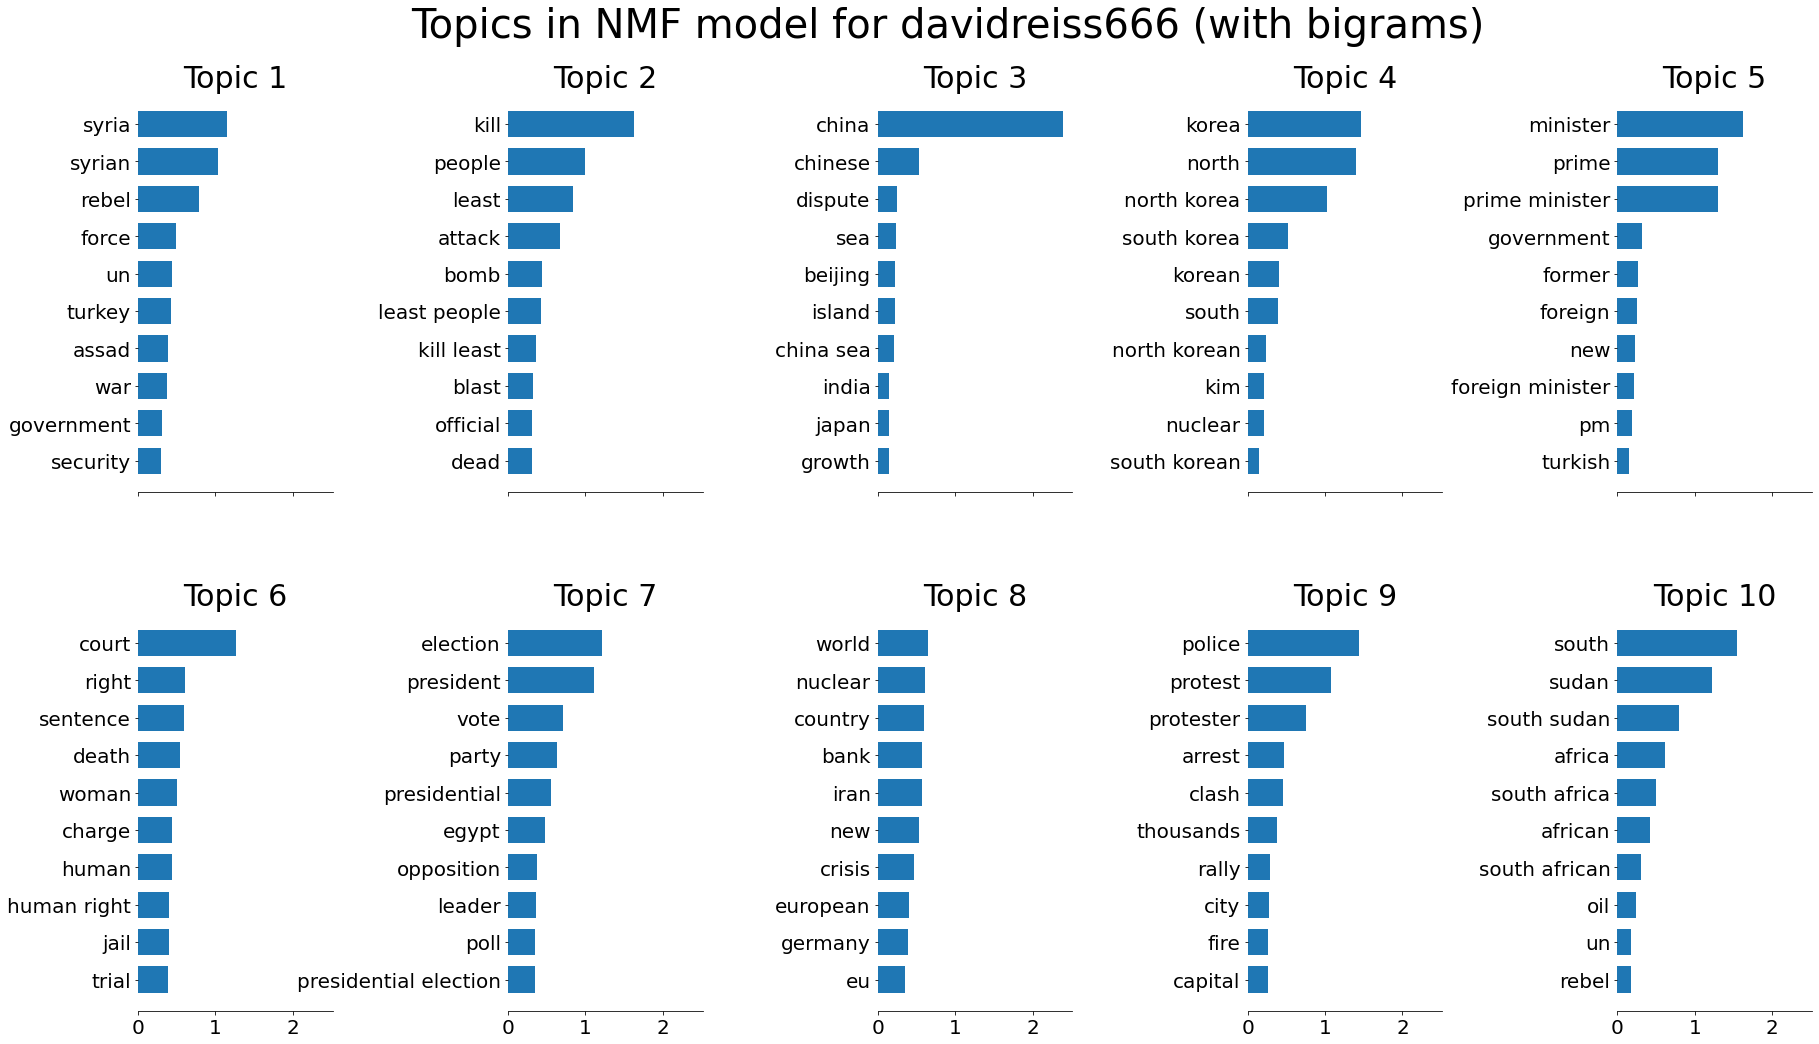

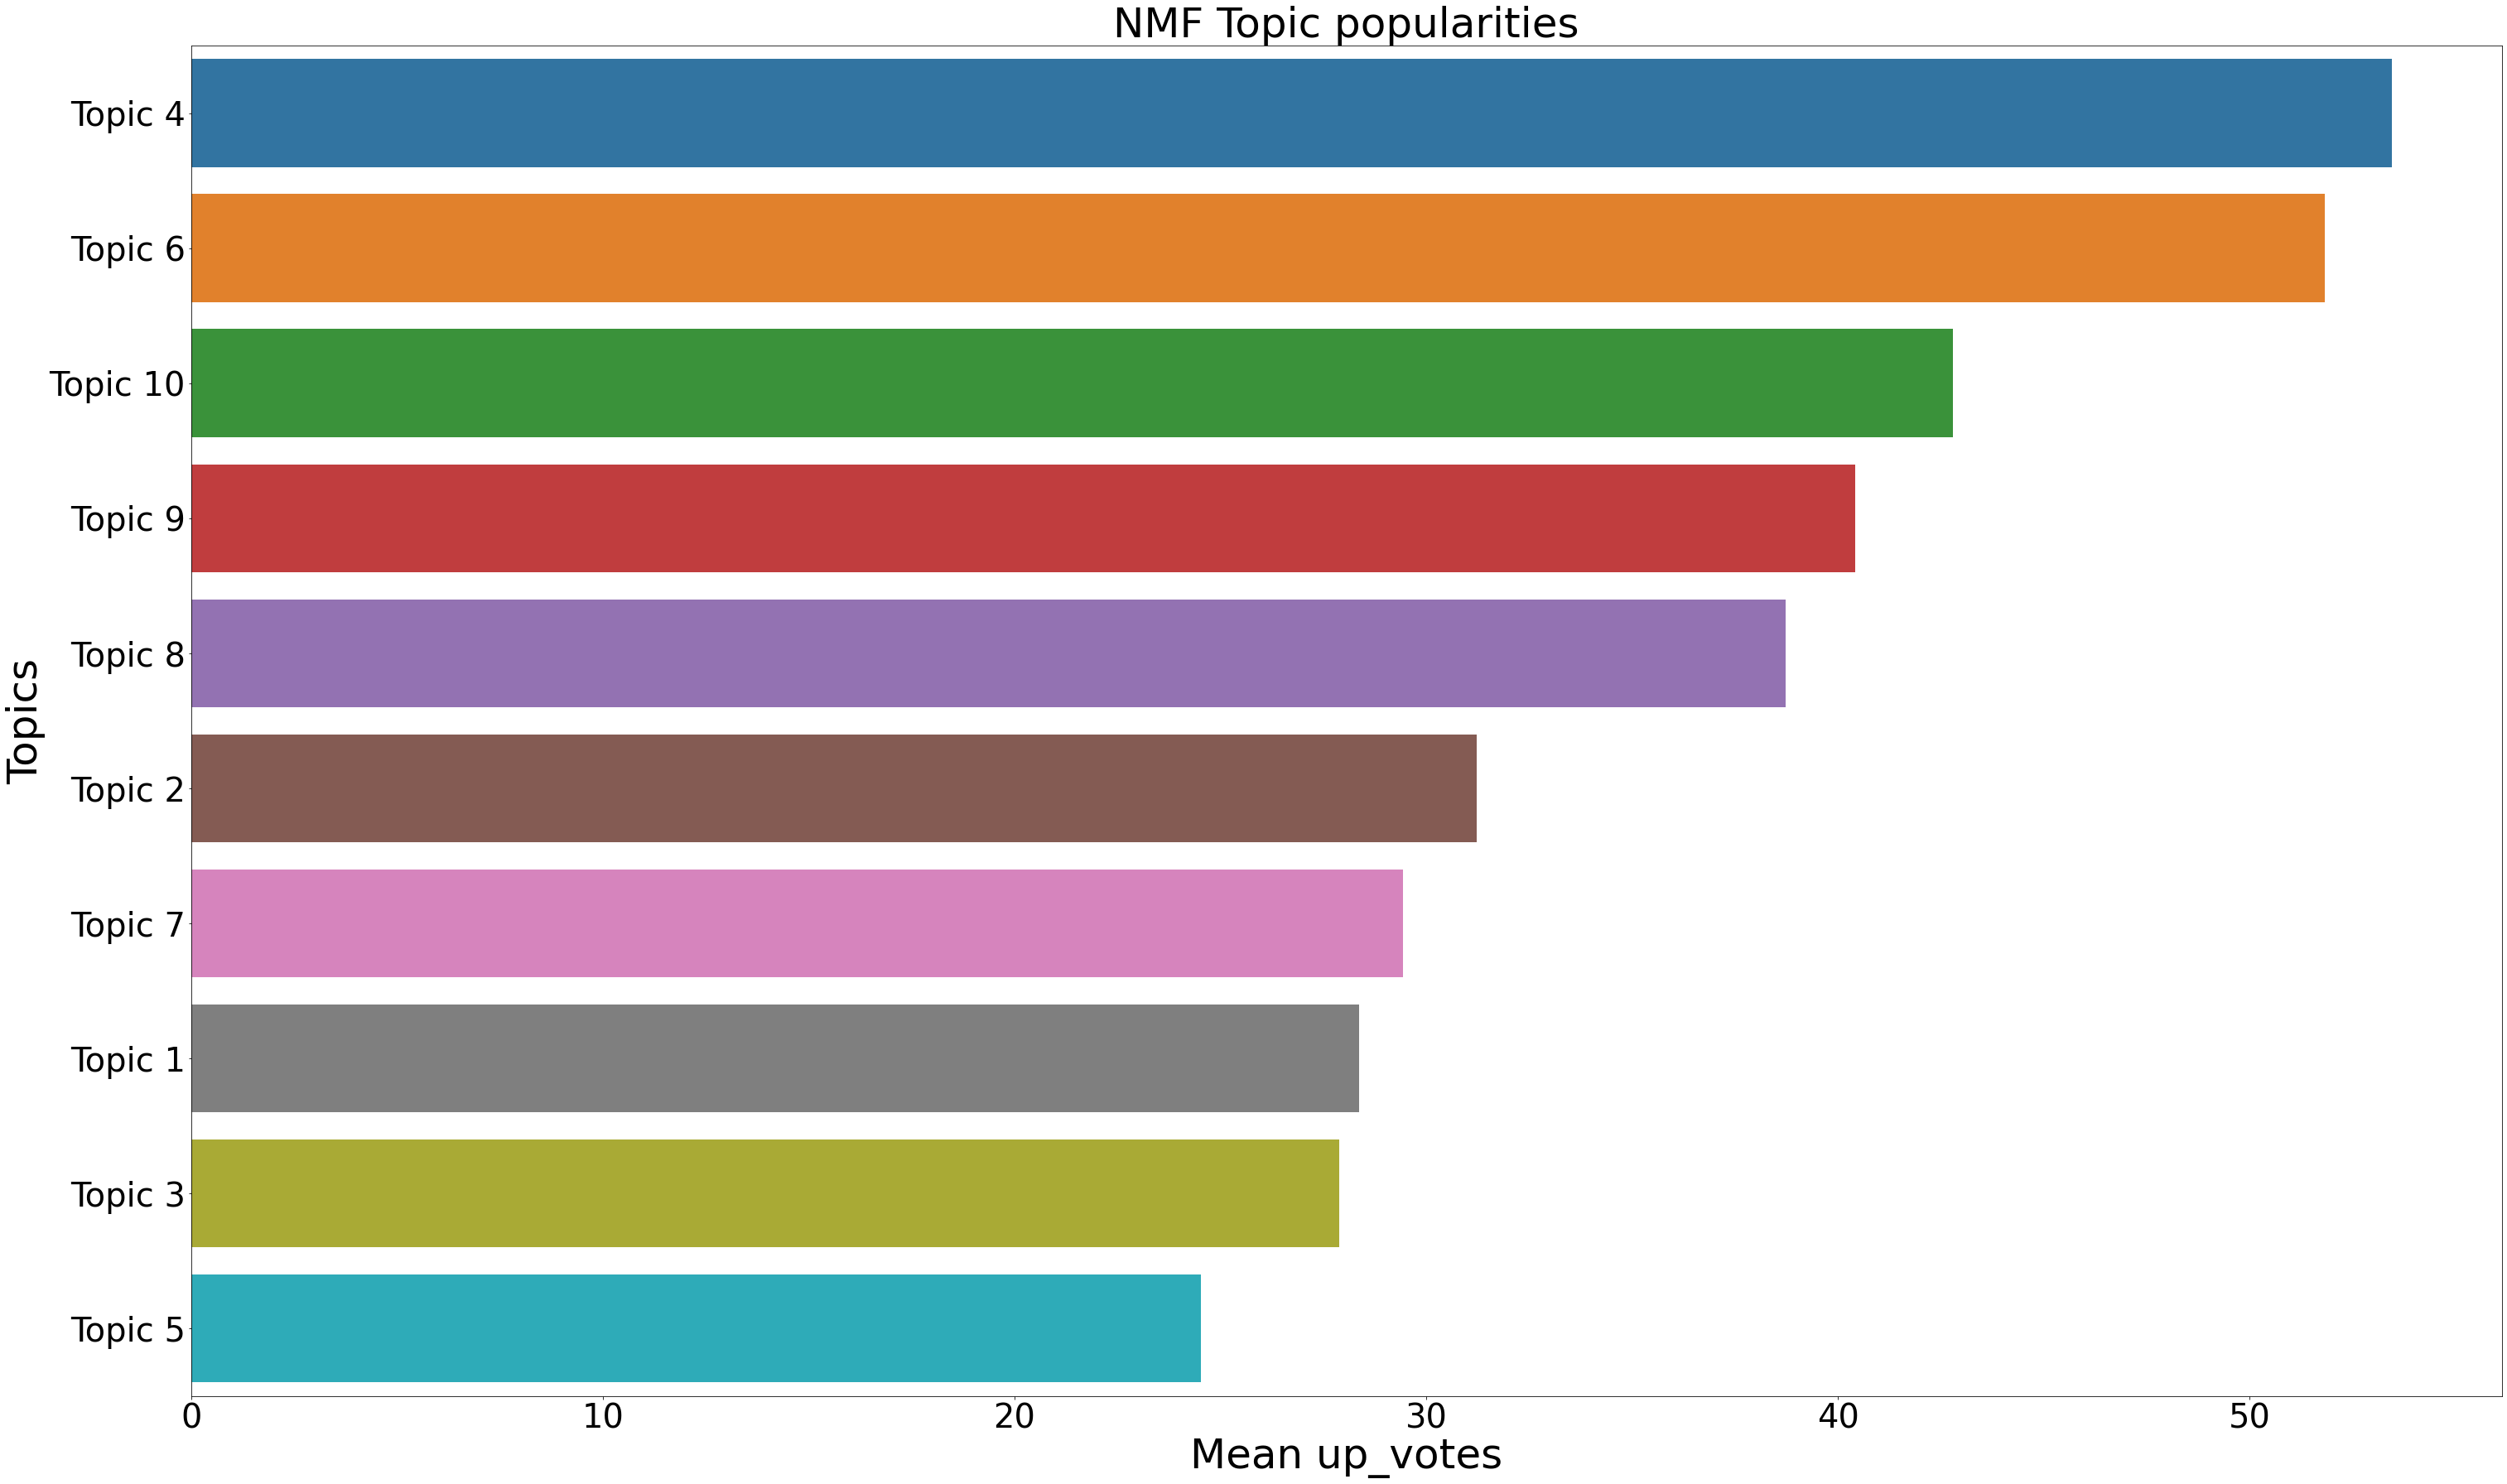

In [40]:
author = 'davidreiss666'

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000, ngram_range=(1,2))
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['author']==author,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=1000).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics_by_author(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {author} (with bigrams)', author)

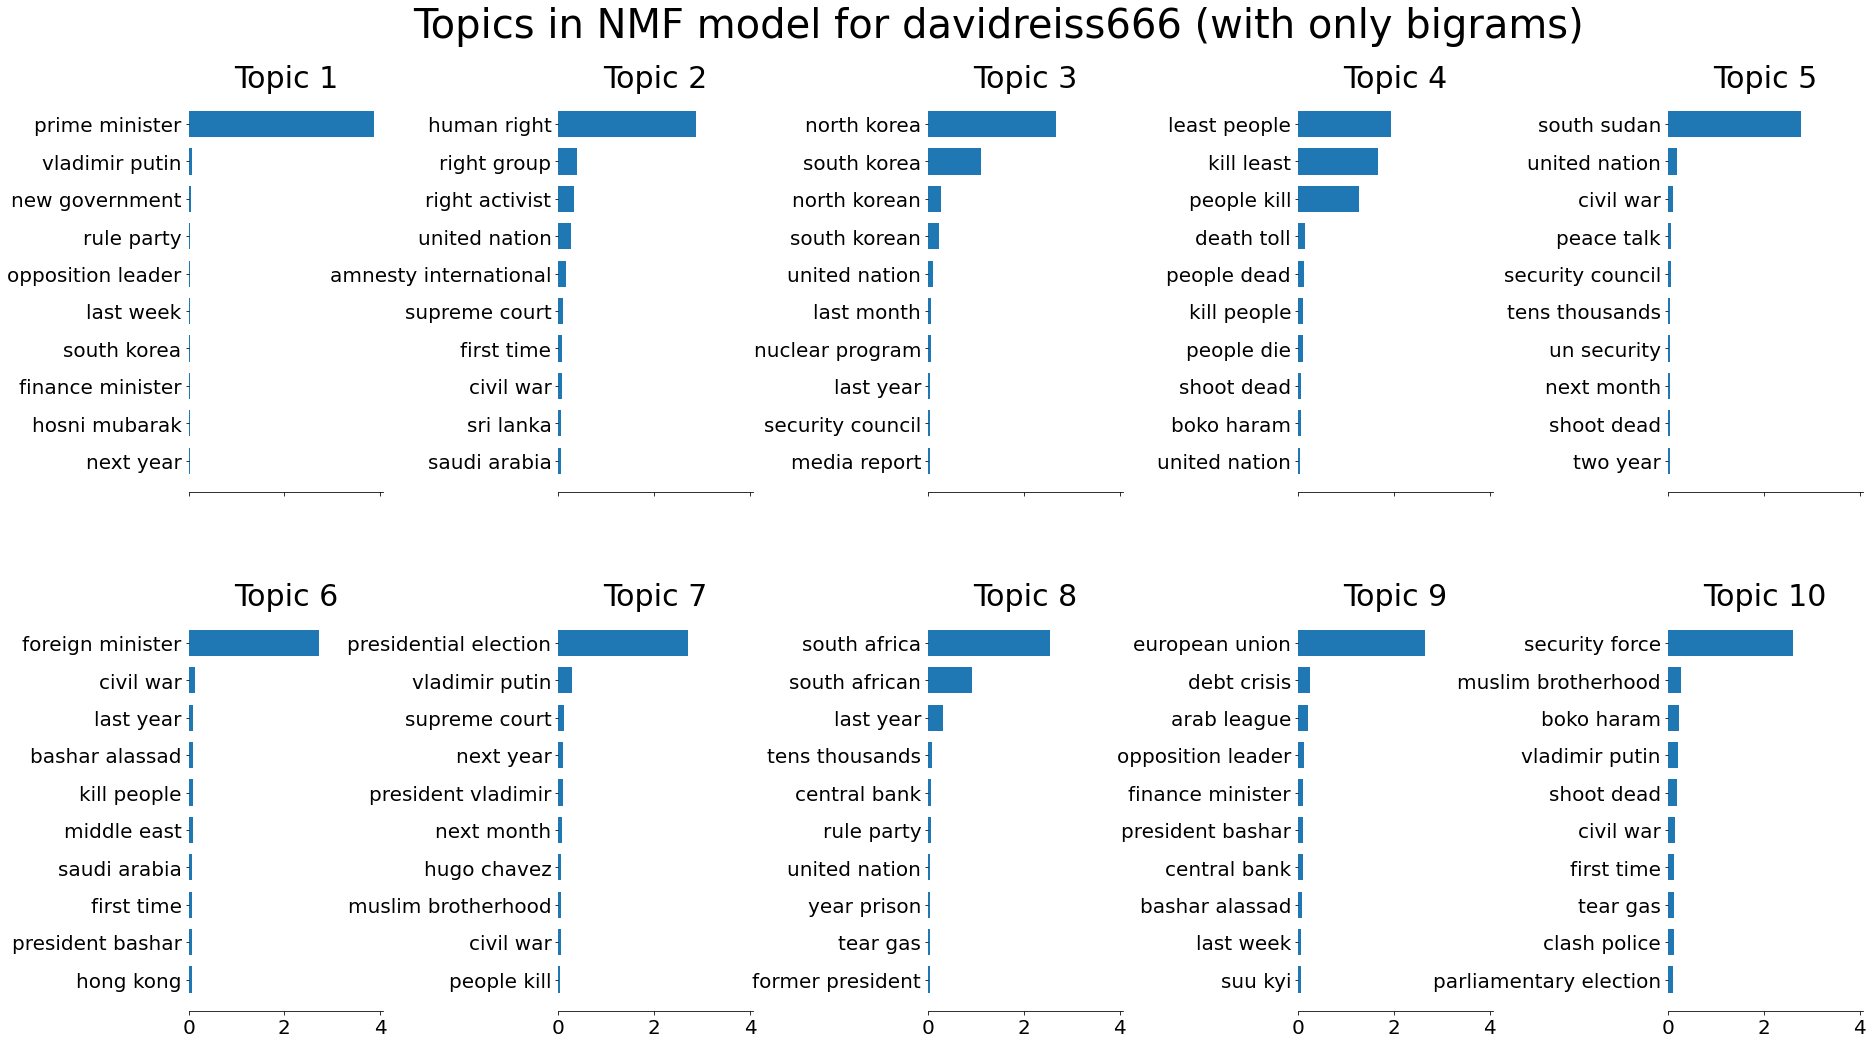

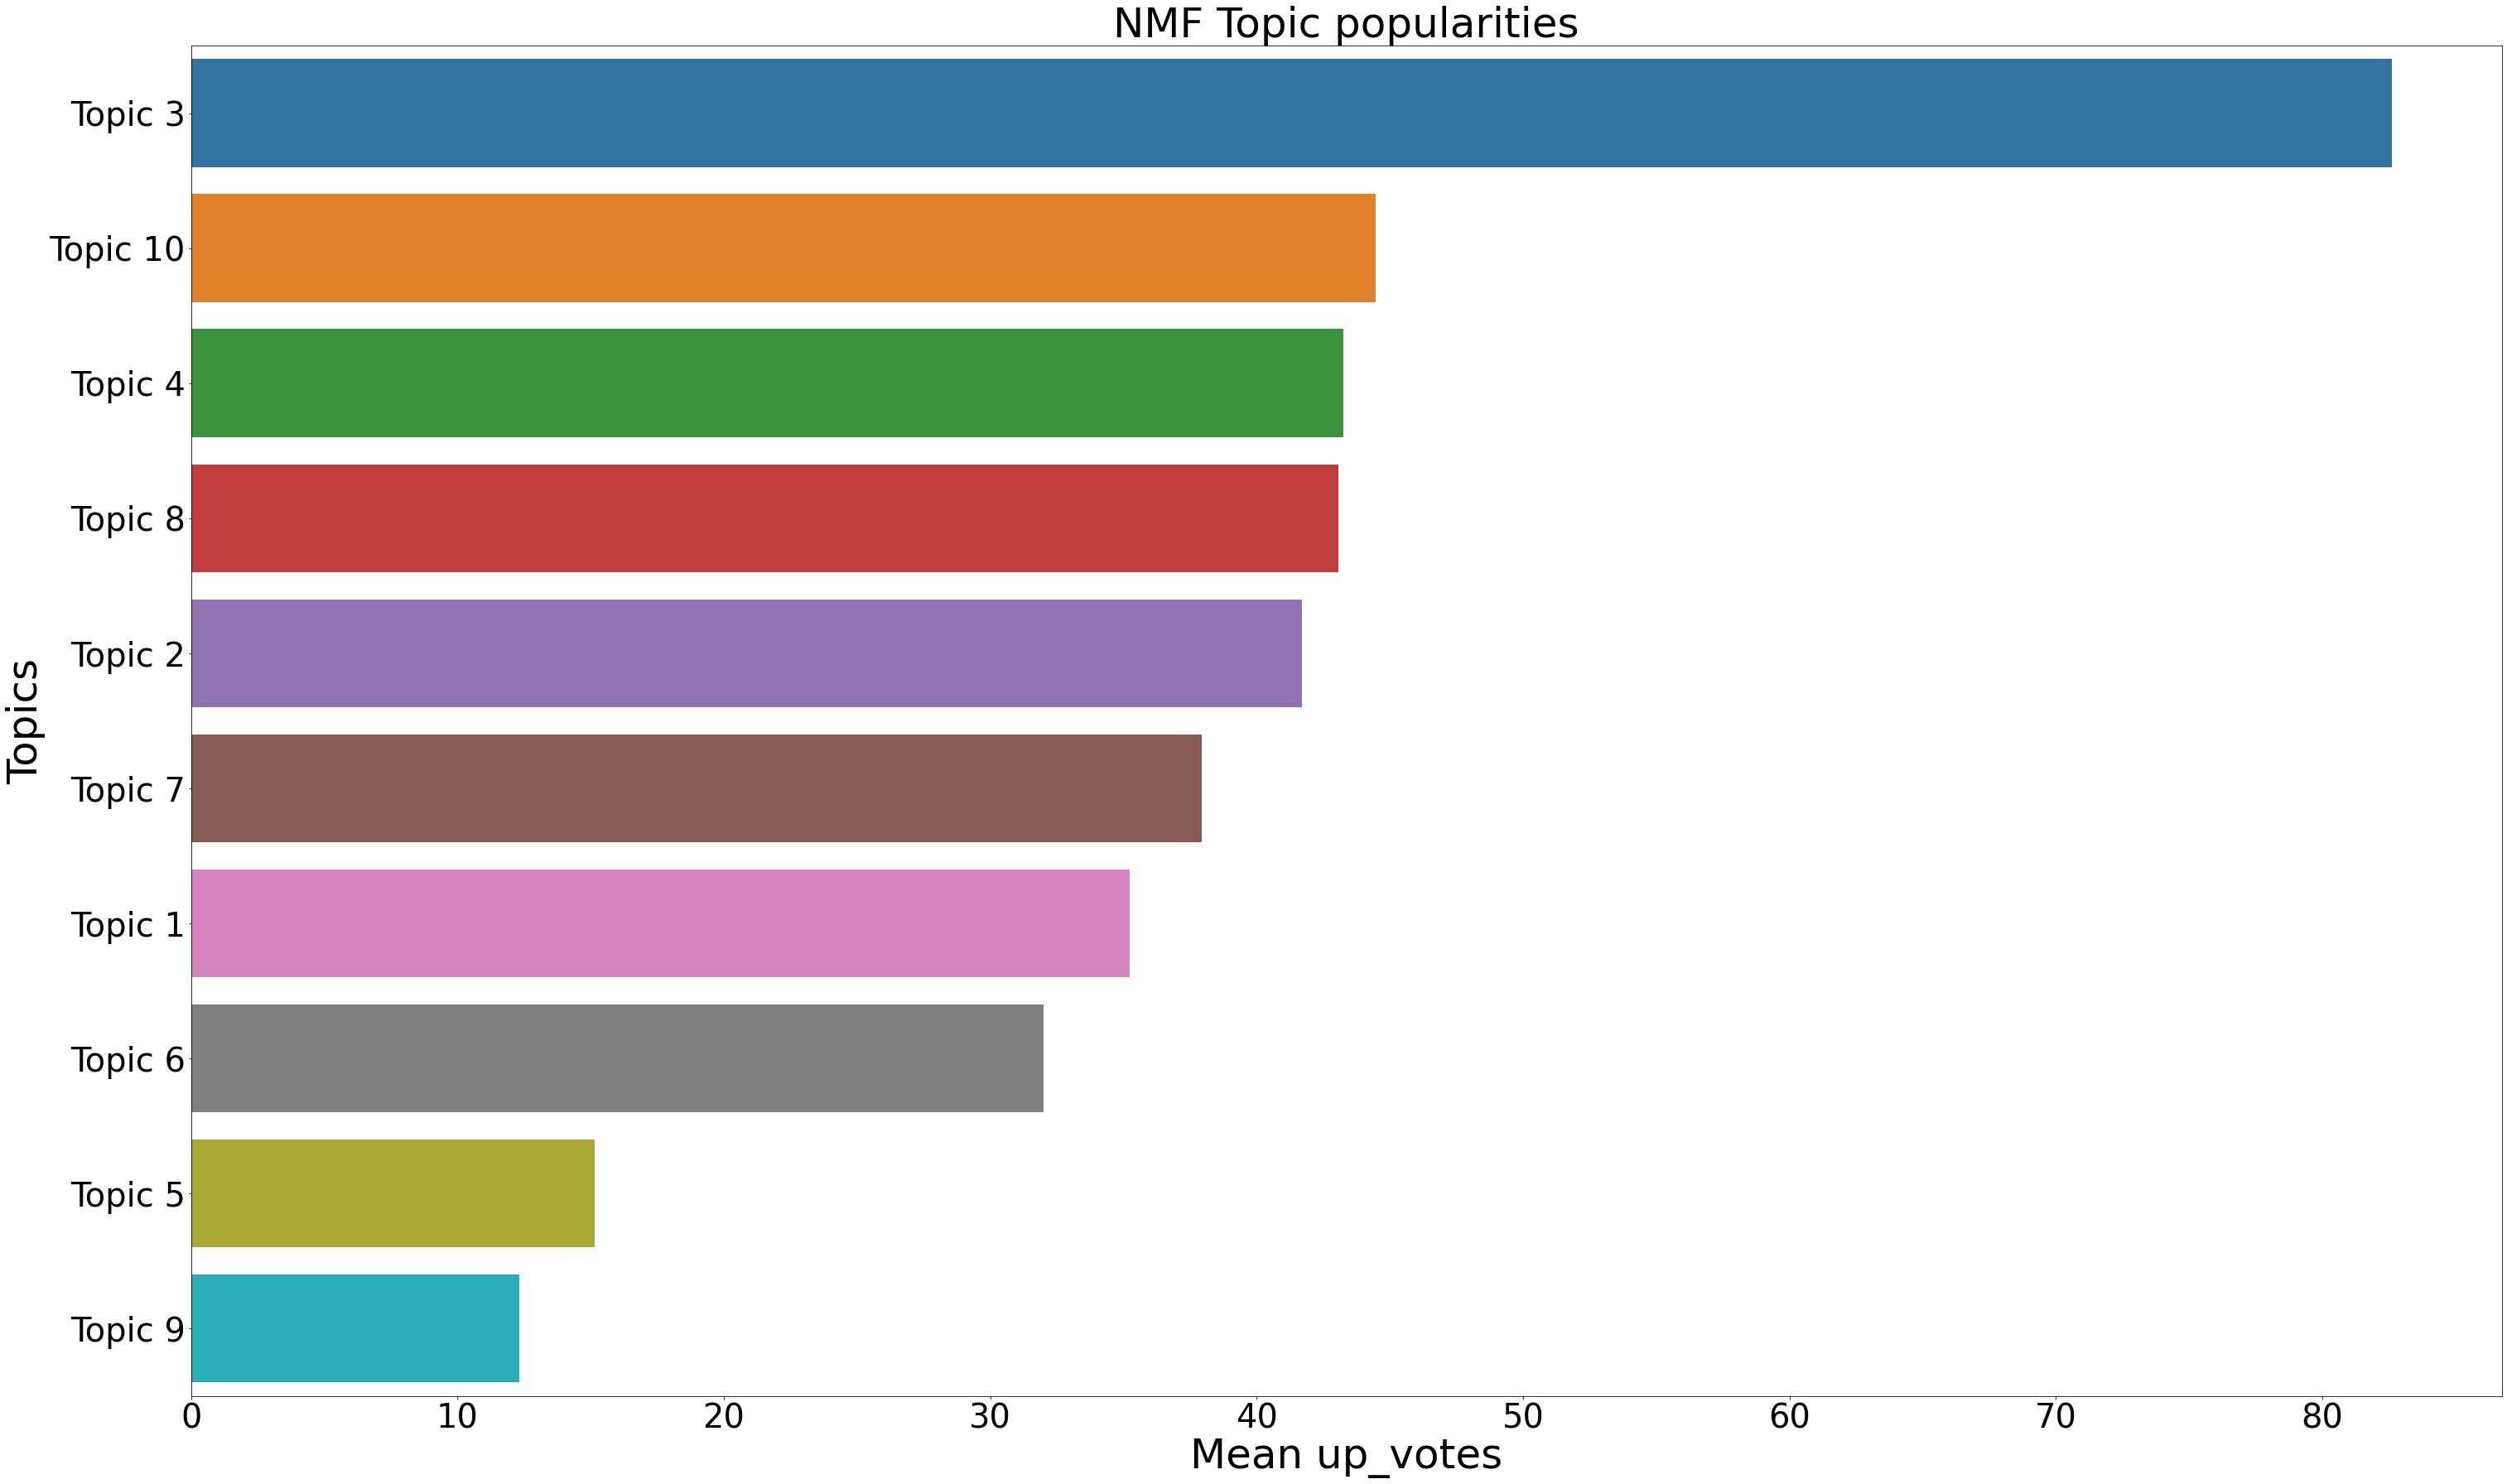

In [41]:
author = 'davidreiss666'

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000, ngram_range=(2,2))
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['author']==author,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=1000).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics_by_author(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {author} (with only bigrams)', author)

### 'davidreiss666' mostly covers *terrorism*, *killings*, *human rights*, etc. like north-south Korea tensions, Boko Haram.

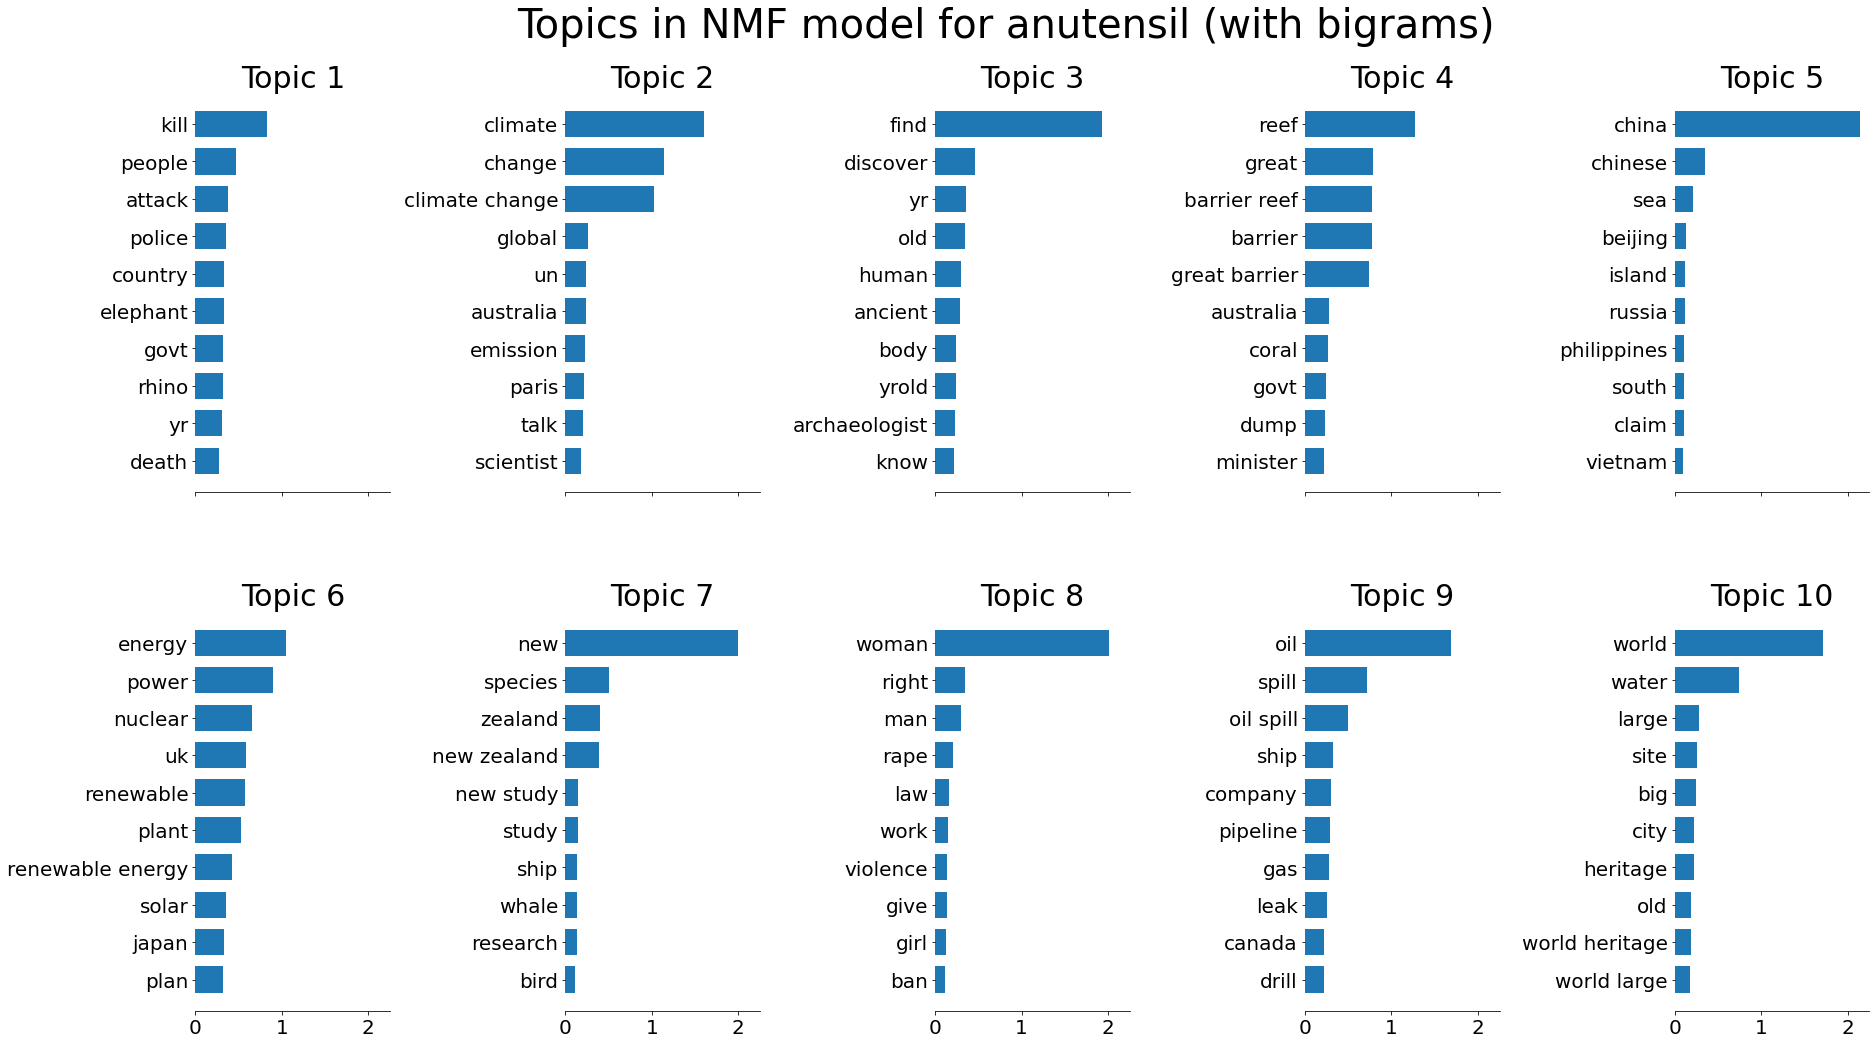

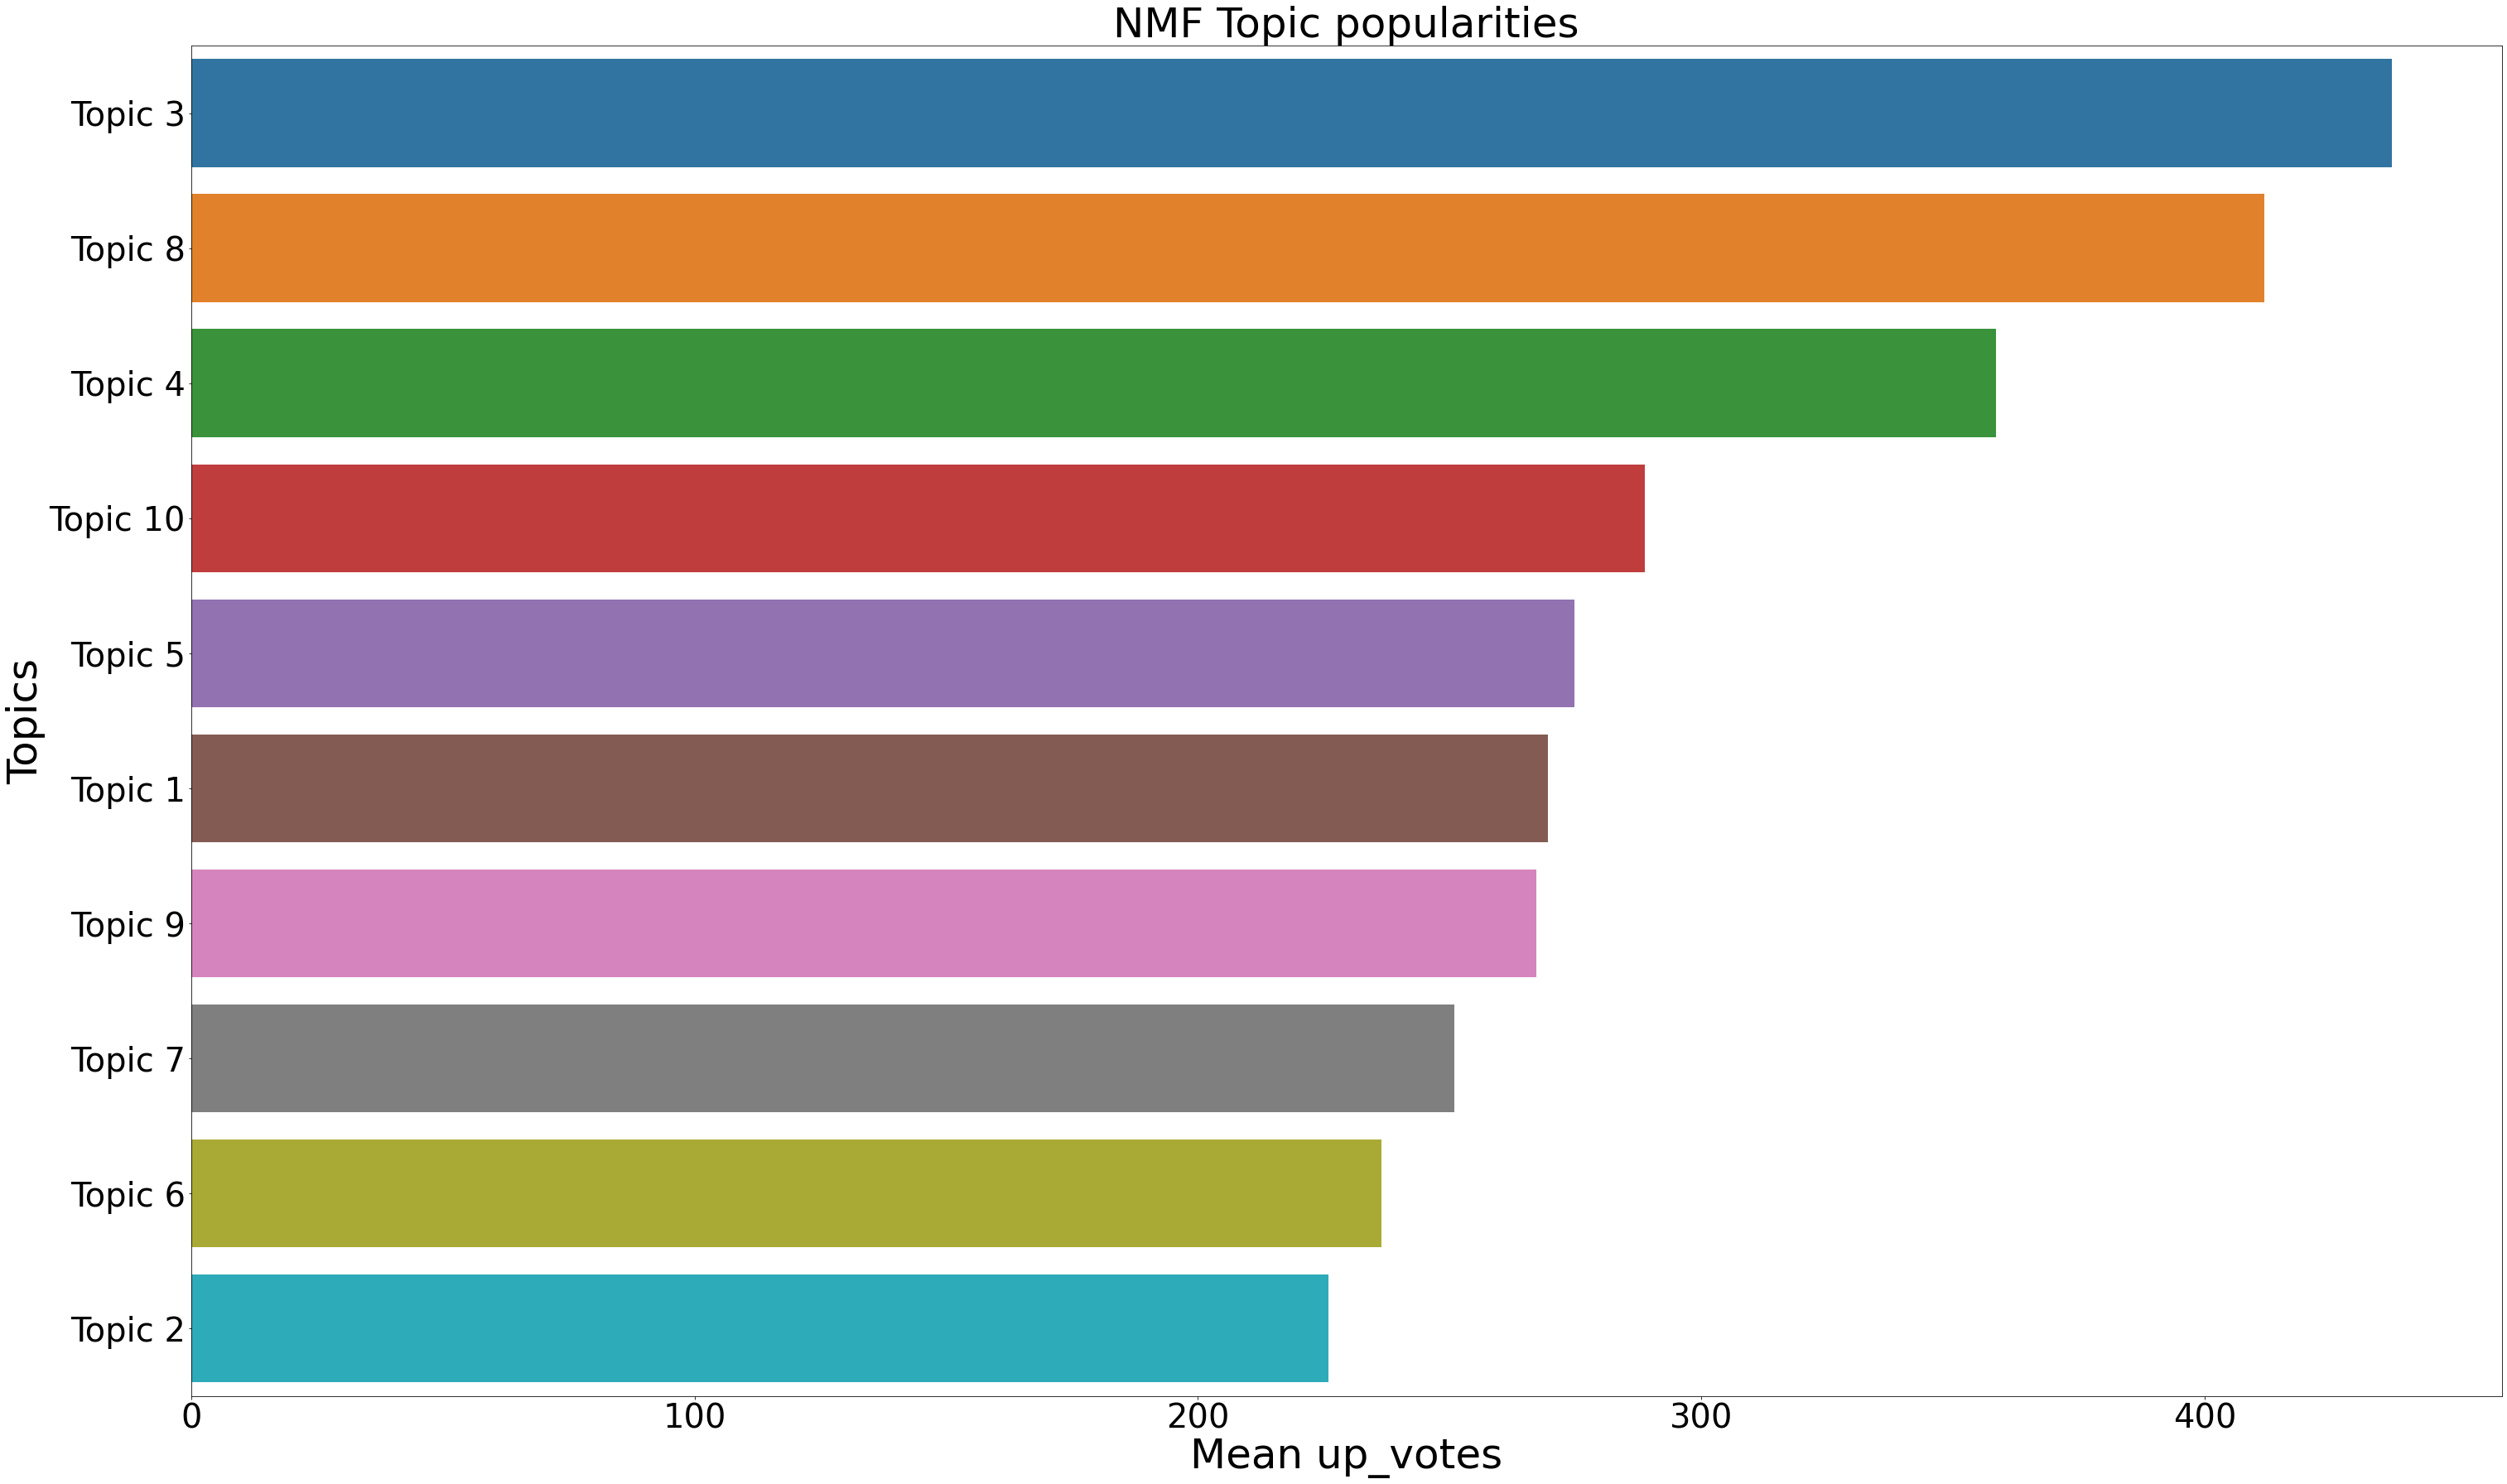

In [42]:
author = 'anutensil'

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000, ngram_range=(1,2))
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['author']==author,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=1000).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics_by_author(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {author} (with bigrams)', author)

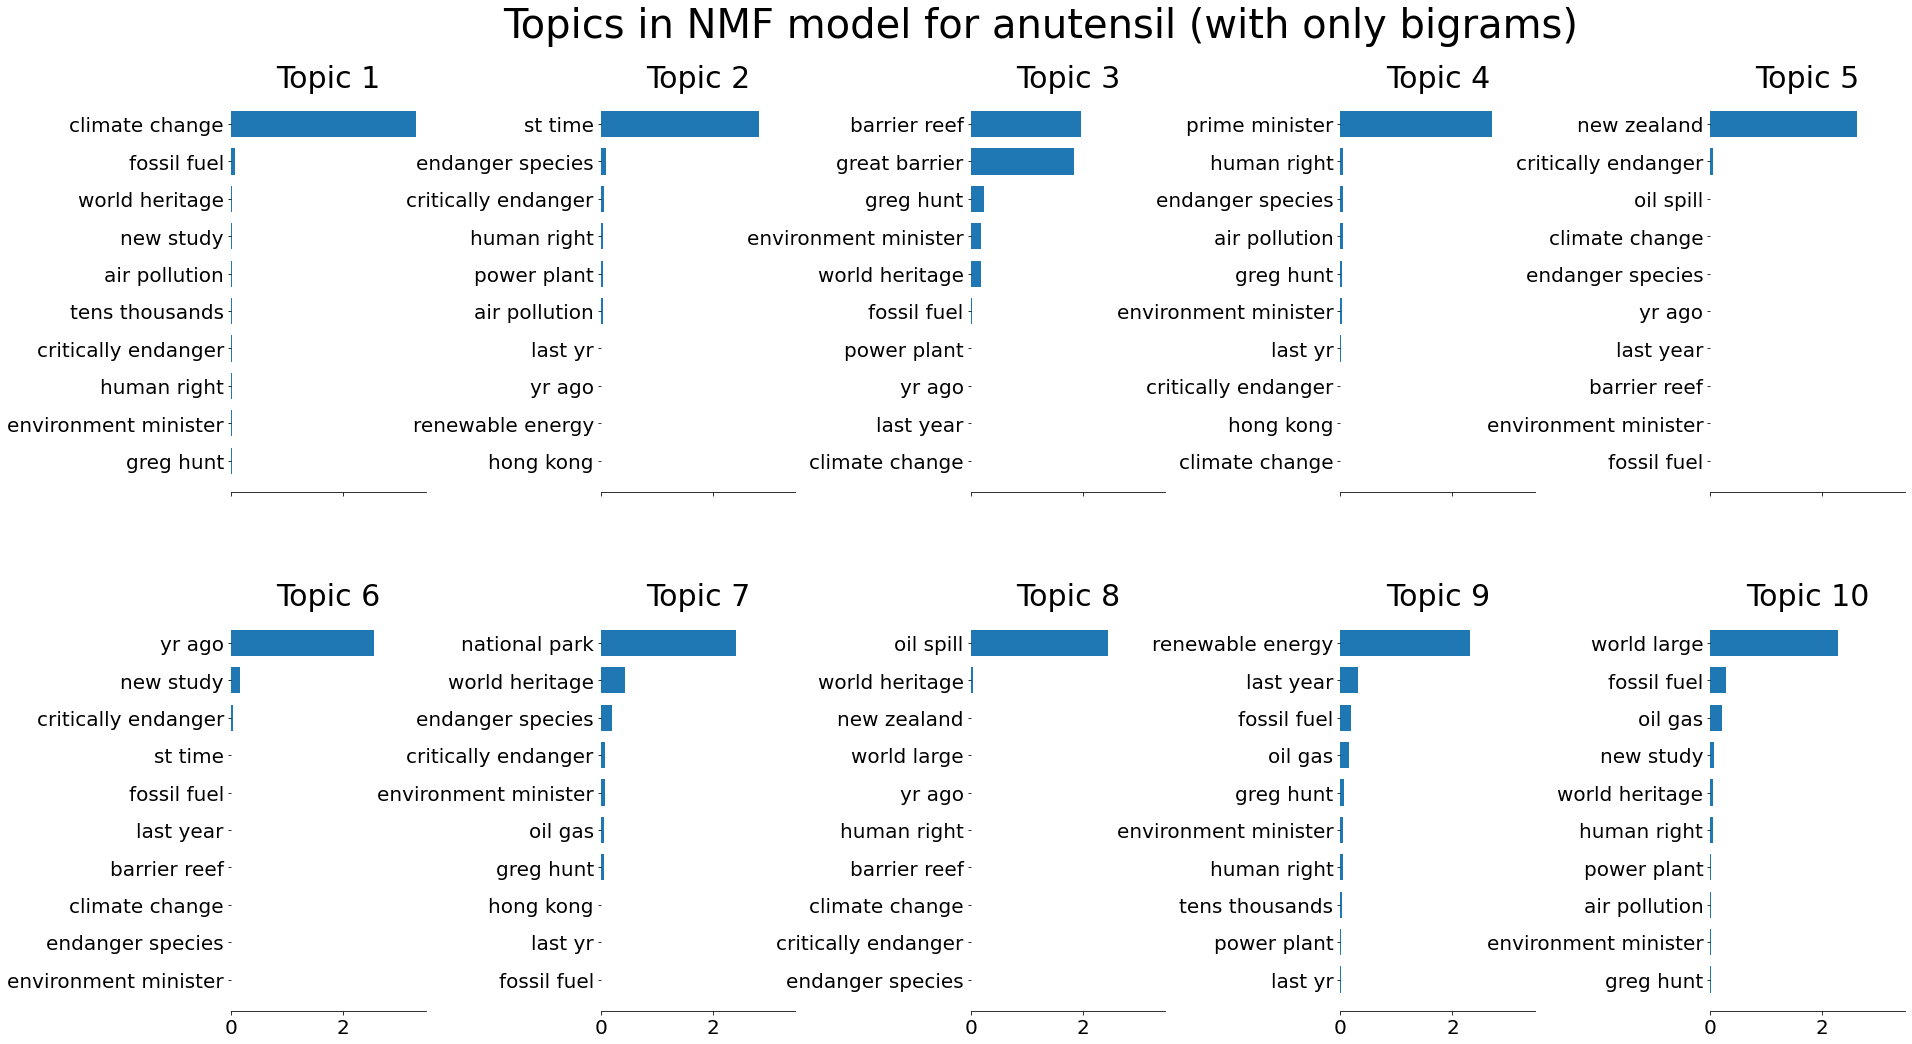

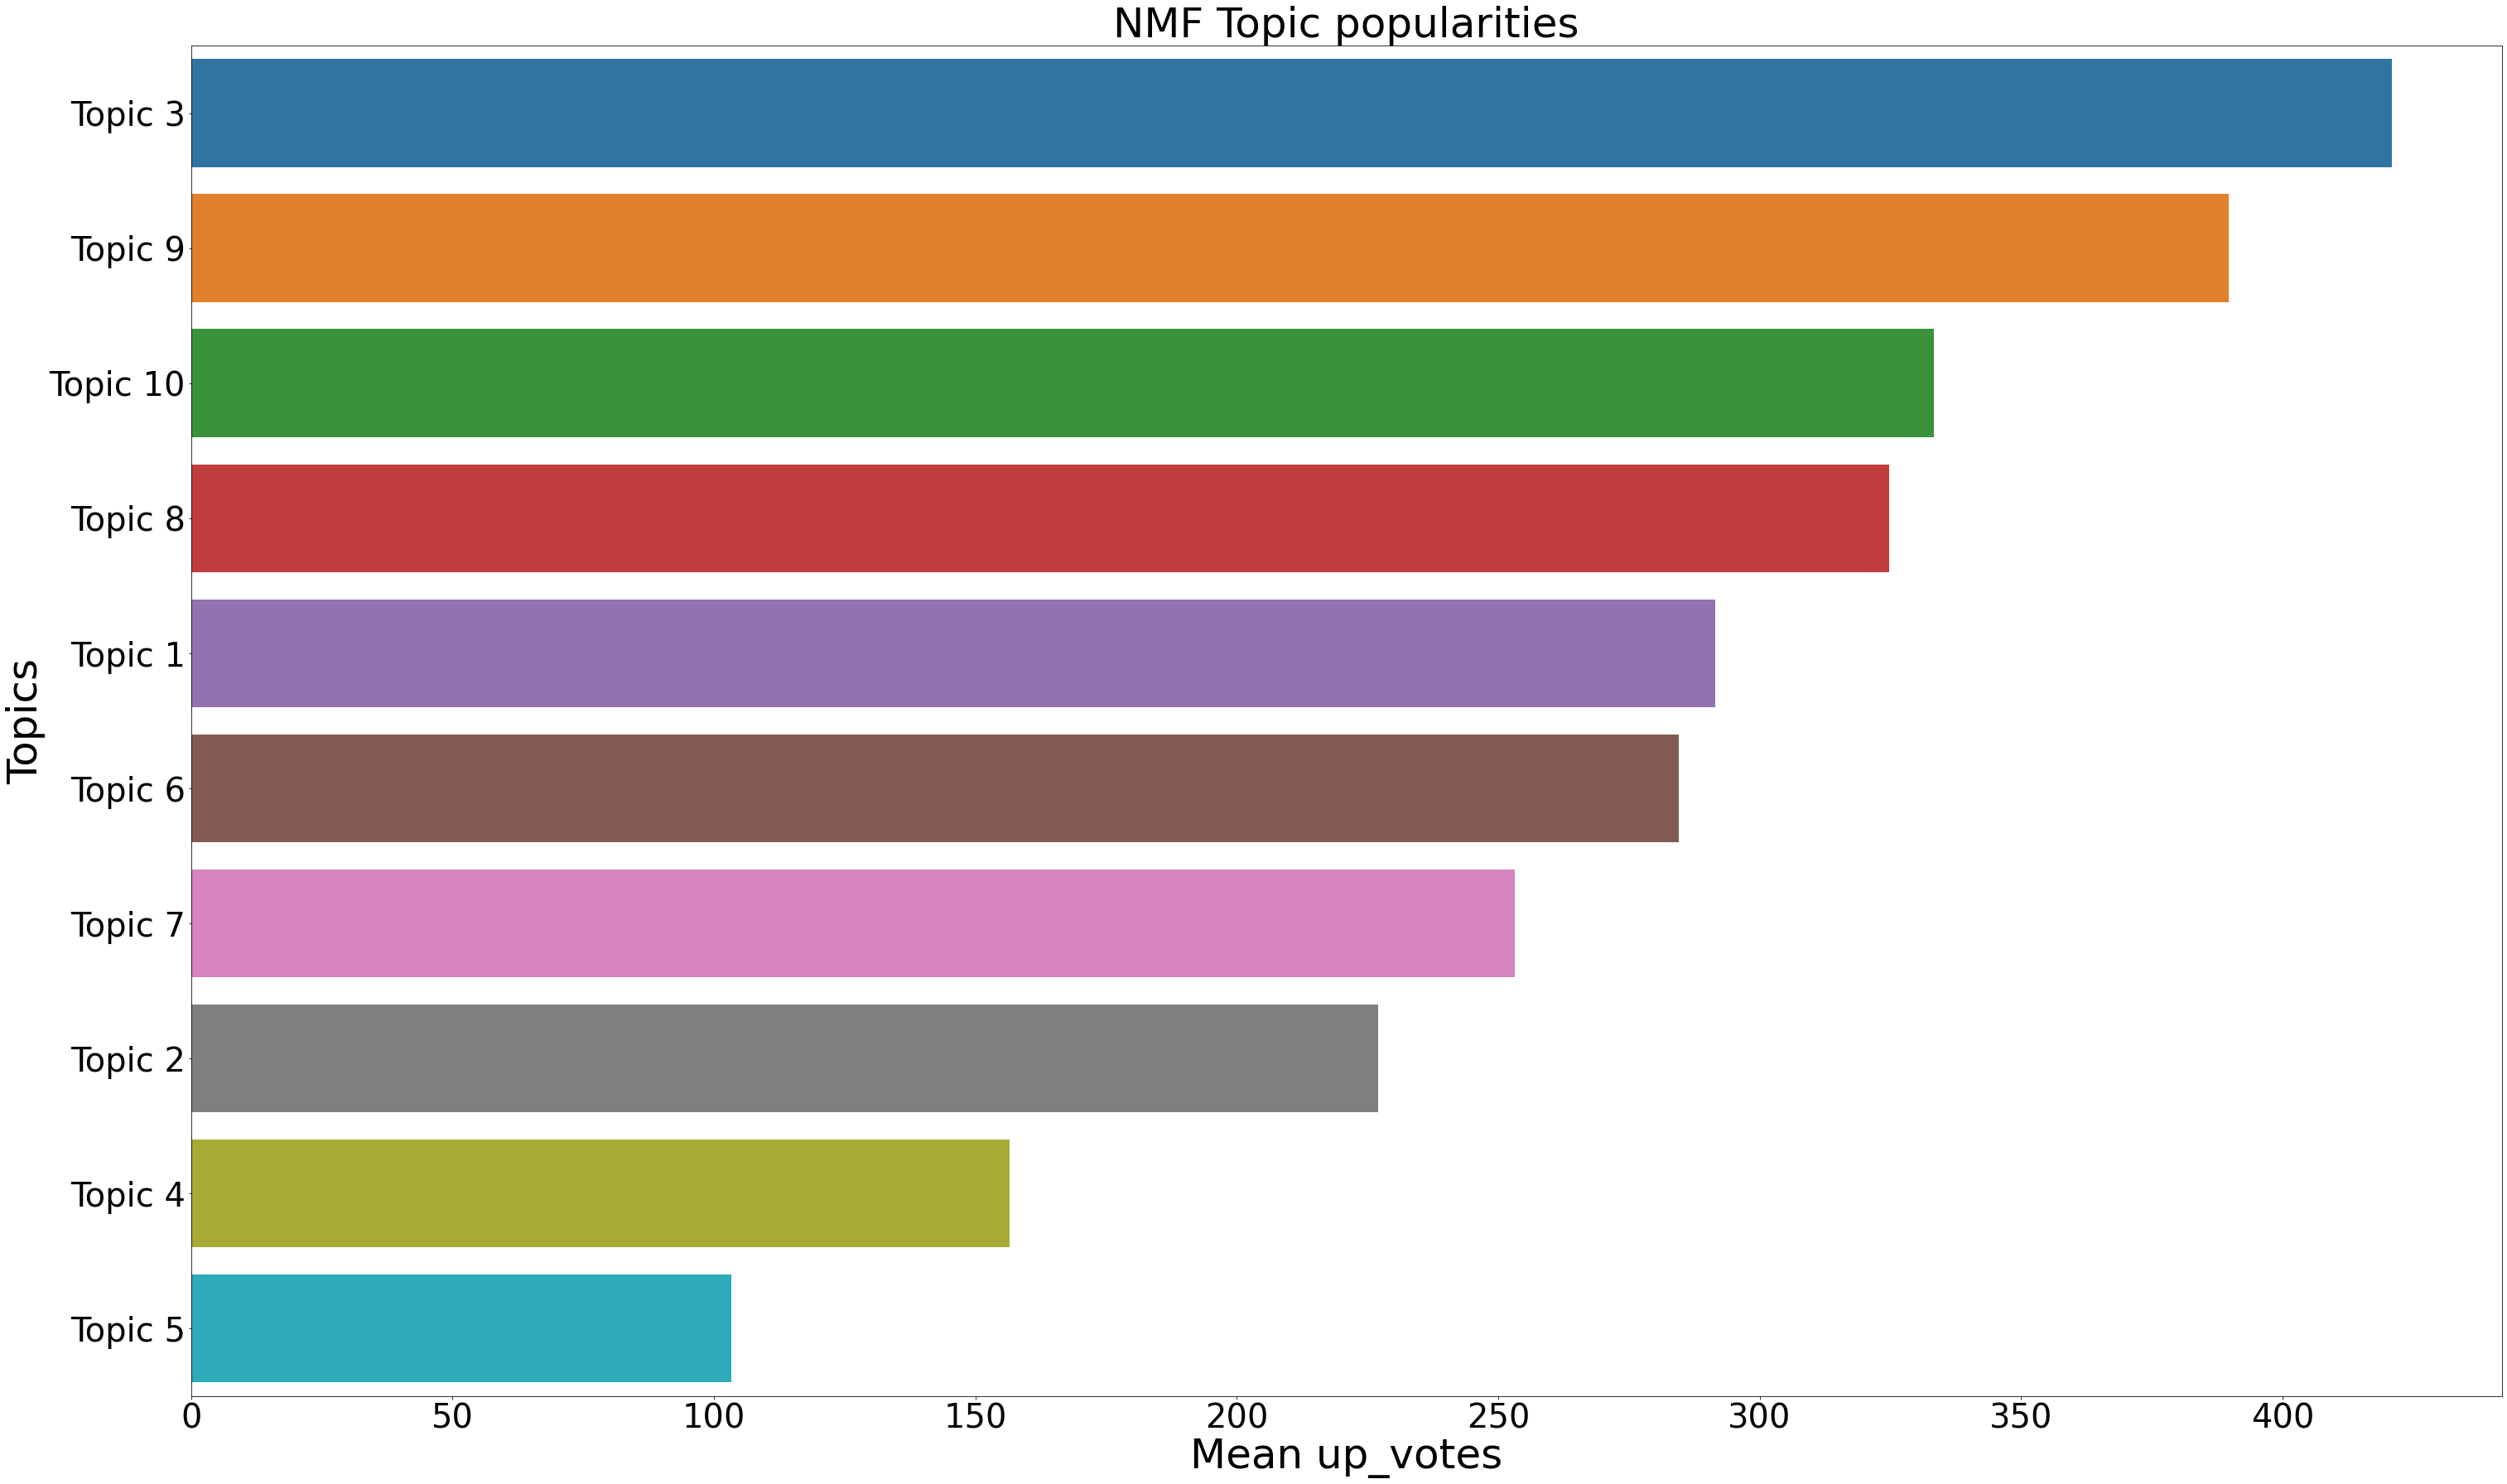

In [43]:
author = 'anutensil'

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000, ngram_range=(2,2))
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['author']==author,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=1000).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics_by_author(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {author} (with only bigrams)', author)

### 'anutensil' mostly covers 'conservation' related topics like *climate change*, *renewables*, *endangered species* etc. 